In [112]:
import numpy as np
import argparse
import time
import os
import collections
import json
import queue
import time

from utils.data_utils import load_dataset_numpy

import scipy.spatial.distance

from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import maximum_flow
from utils.flow import _make_edge_pointers

from cvxopt import solvers, matrix, spdiag, log, mul, sparse, spmatrix

In [113]:
def minll(G,h,p):
    m,v_in=G.size
    def F(x=None,z=None):
        if x is None:
            return 0, matrix(1.0,(v,1))
        if min(x)<=0.0:
            return None
        f = -sum(mul(p,log(x)))
        Df = mul(p.T,-(x**-1).T)
        if z is None:
            return f,Df
        # Fix the Hessian
        H = spdiag(z[0]*mul(p,x**-2))
        return f,Df,H
    return solvers.cp(F,G=G,h=h)

In [114]:
def find_remaining_cap_edges(edge_ptr,capacities,heads,tails, source, sink):
    ITYPE = np.int32
    n_verts = edge_ptr.shape[0] - 1
    n_edges = capacities.shape[0]
    ITYPE_MAX = np.iinfo(ITYPE).max

    # Our result array will keep track of the flow along each edge
    flow = np.zeros(n_edges, dtype=ITYPE)

    # Create a circular queue for breadth-first search. Elements are
    # popped dequeued at index start and queued at index end.
    q = np.empty(n_verts, dtype=ITYPE)

    # Create an array indexing predecessor edges
    pred_edge = np.empty(n_verts, dtype=ITYPE)

    # While augmenting paths from source to sink exist
    for k in range(n_verts):
        pred_edge[k] = -1
    path_edges = []
    # Reset queue to consist only of source
    q[0] = source
    start = 0
    end = 1
    # While we have not found a path, and queue is not empty
    path_found = False
    while start != end and not path_found:
        # Pop queue
        cur = q[start]
        start += 1
        if start == n_verts:
            start = 0
        # Loop over all edges from the current vertex
        for e in range(edge_ptr[cur], edge_ptr[cur + 1]):
            t = heads[e]
            if pred_edge[t] == -1 and t != source and\
                    capacities[e] > flow[e]:
                pred_edge[t] = e
                path_edges.append((cur,t))
                if t == sink:
                    path_found = True
                    break
                # Push to queue
                q[end] = t
                end += 1
                if end == n_verts:
                    end = 0
    return path_edges


In [115]:
def create_graph_rep(edge_matrix,n_1,n_2,weights):
    graph_rep = []
    for i in range(n_1+n_2+2):
        graph_rep.append([])
        if i==0:
            #source
            for j in range(n_1+n_2+2):
                if j==0:
                    graph_rep[i].append(0)
                elif 1<=j<=n_1:
                    graph_rep[i].append(weights[j-1])
                elif n_1<j<=n_1+n_2+1:
                    graph_rep[i].append(0)
        elif 1<=i<=n_1:
            # LHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1:
                    graph_rep[i].append(0)
                elif n_1<j<=n_1+n_2:
                    if edge_matrix[i-1,j-n_1-1]:
                        graph_rep[i].append(1)
                    else:
                        graph_rep[i].append(0)
                elif n_1+n_2<j:
                    graph_rep[i].append(0)
        elif n_1<i<=n_1+n_2:
            #RHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1+n_2:
                    graph_rep[i].append(0)
                elif j>n_1+n_2:
                    graph_rep[i].append(weights[i-1])
        elif i==n_1+n_2+1:
            #Sink
            for j in range(n_1+n_2+2):
                graph_rep[i].append(0)

    graph_rep_array=np.array(graph_rep)

    return graph_rep_array

In [116]:
def set_classifier_prob_full_flow(top_level_vertices,w_1_curr,w_2_curr):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            classifier_probs[item-1,0]=w_1_curr/(w_1_curr+w_2_curr)
            classifier_probs[item-1,1]=w_2_curr/(w_1_curr+w_2_curr)

In [117]:
def set_classifier_prob_no_flow(top_level_vertices):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            if item<=n_1:
                classifier_probs[item-1,0]=1
                classifier_probs[item-1,1]=0
            elif item>n_1:
                classifier_probs[item-1,0]=0
                classifier_probs[item-1,1]=1

In [118]:
def graph_rescale(graph_rep_curr,top_level_indices,weights):
    class_1_vertices=top_level_indices[( top_level_indices> 0) & (top_level_indices<=n_1)]
    class_1_weights=weights[class_1_vertices-1]
    w_1_curr=np.sum(class_1_weights)
    class_2_vertices=top_level_indices[ (top_level_indices>n_1) & (top_level_indices<=n_1+n_2)]
    class_2_weights=weights[class_2_vertices-1]
    w_2_curr=np.sum(class_2_weights)
    n_1_curr=len(class_1_vertices)
    n_2_curr=len(class_2_vertices)
    #n_1_curr=len(np.where(top_level_indices<=n_1)[0])-1
    #n_2_curr=len(np.where(top_level_indices>n_1)[0])-1
    # source rescale
    # print(graph_rep_curr[0])
    #graph_rep_curr[0,:]=graph_rep_curr[0,:]/n_2
    graph_rep_curr[0,:]= (graph_rep_curr[0,:]*w_2_curr)
    # print(graph_rep_curr[0])
    # bipartite graph edge scale
    #graph_rep_curr[1:n_1_curr+1,:]=graph_rep_curr[1:n_1_curr+1,:]/(n_1*n_2)
    graph_rep_curr[1:n_1_curr+1,:]=(graph_rep_curr[1:n_1_curr+1,:]*(w_1_curr*w_2_curr))
    # sink edges rescale
    #graph_rep_curr[n_1_curr+1:,:]=graph_rep_curr[n_1_curr+1:,:]/n_1
    graph_rep_curr[n_1_curr+1:,:]=(graph_rep_curr[n_1_curr+1:,:]*w_1_curr)
    #print(f"The graph_rep_curr is {graph_rep_curr}, w_1_curr is : {w_1_curr},w_2_curr is : {w_2_curr}")
    return graph_rep_curr,w_1_curr,w_2_curr

In [119]:
def find_flow_and_split(top_level_indices,weights):
    top_level_indices_1=None
    top_level_indices_2=None
    #Create subgraph from index array provided
    graph_rep_curr = graph_rep_array[top_level_indices]
    graph_rep_curr = graph_rep_curr[:,top_level_indices]
    graph_rep_curr,w_1_curr,w_2_curr = graph_rescale(graph_rep_curr,top_level_indices,weights)
    print(f"The weight1 is : {w_1_curr} , the weight2 is:{w_2_curr}")
    graph_curr=csr_matrix(graph_rep_curr)
    flow_curr = maximum_flow(graph_curr,0,len(top_level_indices)-1)
    print(f"The flow value is:{flow_curr.flow_value}")
    # Checking if full flow occurred, so no need to split
    if flow_curr.flow_value==0:
        set_classifier_prob_no_flow(top_level_indices)
        return top_level_indices_1,top_level_indices_2, flow_curr
    elif flow_curr.flow_value==w_1_curr*w_2_curr:
        if (w_1_curr*w_2_curr)>=2**32:
            print("There is overflow")
        set_classifier_prob_full_flow(top_level_indices,w_1_curr,w_2_curr)
        return top_level_indices_1,top_level_indices_2, flow_curr
    # Finding remaining capacity edges
    remainder_array = graph_curr-flow_curr.residual
    #print(f"The remainder array is :{ remainder_array}")

    rev_edge_ptr, tails = _make_edge_pointers(remainder_array)
    #print(f"The rev_edge and tails are : {rev_edge_ptr} and {tails}")
    edge_ptr=remainder_array.indptr
    capacities=remainder_array.data
    heads=remainder_array.indices

    edge_list_curr = find_remaining_cap_edges(edge_ptr,capacities,heads,tails,0,len(top_level_indices)-1)

    #print(f"The edge_list_curr is {edge_list_curr}")
    gz_idx = []
    for item in edge_list_curr:
        gz_idx.append(item[0])
        gz_idx.append(item[1])
    #print(f"The gz_idx is {gz_idx}")
    if len(gz_idx)>0:
        gz_idx=np.array(gz_idx)
        gz_idx_unique=np.unique(gz_idx)
        top_level_gz_idx=top_level_indices[gz_idx_unique]
        top_level_gz_idx=np.insert(top_level_gz_idx,len(top_level_gz_idx),sink_idx)
        top_level_indices_1=top_level_gz_idx
    else:
        top_level_gz_idx=np.array([0,sink_idx])
    # Indices without flow
    top_level_z_idx=np.setdiff1d(top_level_indices,top_level_gz_idx)
    if len(top_level_z_idx)>0:
        # Add source and sink back to zero flow idx array
        top_level_z_idx=np.insert(top_level_z_idx,0,0)
        top_level_z_idx=np.insert(top_level_z_idx,len(top_level_z_idx),sink_idx)
        top_level_indices_2=top_level_z_idx
    #print(top_level_indices_1, top_level_indices_2, flow_curr)
    return top_level_indices_1,top_level_indices_2, flow_curr

In [120]:
parser = argparse.ArgumentParser()

In [121]:
parser.add_argument("--dataset_in", default='MNIST',
                    help="dataset to be used")
parser.add_argument("--norm", default='l2',
                    help="norm to be used")
parser.add_argument('--num_samples', type=int, default=None)
parser.add_argument('--n_classes', type=int, default=2)
parser.add_argument('--eps', type=str, default=None)
parser.add_argument('--approx_only', dest='approx_only', action='store_true')
parser.add_argument('--use_test', dest='use_test', action='store_true')
parser.add_argument('--track_hard', dest='track_hard', action='store_true')
parser.add_argument('--use_full', dest='use_full', action='store_true')
parser.add_argument('--run_generic', dest='run_generic', action='store_true')
parser.add_argument('--new_marking_strat', type=str, default=None)
parser.add_argument('--num_reps', type=int, default=2)
parser.add_argument('--class_1', type=int, default=3)
parser.add_argument('--class_2', type=int, default=7)

_StoreAction(option_strings=['--class_2'], dest='class_2', nargs=None, const=None, default=7, type=<class 'int'>, choices=None, help=None, metavar=None)

In [122]:
args = parser.parse_args("--dataset_in=MNIST --num_samples=2500 --use_full --eps=0,4".split())

In [123]:
args

Namespace(approx_only=False, class_1=3, class_2=7, dataset_in='MNIST', eps='0,4', n_classes=2, new_marking_strat=None, norm='l2', num_reps=2, num_samples=2500, run_generic=False, track_hard=False, use_full=True, use_test=False)

In [124]:
eps=args.eps

In [125]:
eps

'0,4'

In [126]:
eps=eps.split(',')
eps

['0', '4']

In [127]:
eps=[float(i) for i in eps]
eps

[0.0, 4.0]

In [128]:
train_data, test_data, data_details = load_dataset_numpy(args, data_dir='data',
                                                        training_time=False)

In [129]:
train_data

Dataset MNIST
    Number of datapoints: 5000
    Root location: data
    Split: Train

In [130]:
test_data

Dataset MNIST
    Number of datapoints: 2020
    Root location: data
    Split: Test

In [131]:
data_details

{'n_channels': 1, 'h_in': 28, 'w_in': 28, 'scale': 255.0}

In [132]:
DATA_DIM = data_details['n_channels']*data_details['h_in']*data_details['w_in']

X = []
Y = []

# Pytorch normalizes tensors (so need manual here!)
if args.use_test:
    for (x,y,_, _, _) in test_data:
        X.append(x/255.)
        Y.append(y)
else:
    for (x,y,_, _, _) in train_data:
        X.append(x/255.)
        Y.append(y)

X = np.array(X)
Y = np.array(Y)

num_samples = int(len(X)/2)
print(num_samples)

2500


In [133]:
X_c1 = X[:num_samples].reshape(num_samples, DATA_DIM)
X_c2 = X[num_samples:].reshape(num_samples, DATA_DIM)

class_1 = args.class_1
class_2 = args.class_2

if not os.path.exists('distances'):
    os.makedirs('distances')

if not os.path.exists('cost_results'):
    os.makedirs('cost_results')

if args.use_full:
    subsample_sizes = [args.num_samples]
else:
    subsample_sizes = [args.num_samples]
   

rng = np.random.default_rng(77)

In [134]:
subsample_sizes

[2500]

In [135]:
eps=[3.5]

In [136]:
#eps[0][0][1]

In [137]:
#eps_user=[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12]]

In [138]:
import MultipleBudgetEdgeMatrix

In [139]:
from tqdm import tqdm

In [140]:
import math

In [141]:
from numpy import random

In [142]:
z = np.random.default_rng().geometric(p=0.075, size=100)

In [143]:
z

array([25,  4,  1,  1, 18, 11, 24, 42, 13,  4,  5,  3, 11, 10,  2, 25, 12,
        8, 19, 13, 14,  3, 11, 11, 15,  3, 30, 27, 23,  3,  9, 20,  8,  6,
        9, 10,  1,  1,  2, 10,  4, 22, 31, 76,  4, 12,  7, 32, 11, 19, 22,
       11, 13, 11,  1, 10,  1, 18, 43, 16, 18, 18,  5, 26,  8, 28,  8, 35,
       36, 32, 22, 23, 11,  3,  5,  6, 17, 14,  1,  4, 35, 21,  6, 10,  4,
        1, 15, 22, 17,  1,  4,  5, 17,  8,  2,  6, 14, 38,  6,  2],
      dtype=int64)

In [145]:
loss_final=[]
weight_list=[]
avg_list_loss_adversary1=[]
avg_list_loss_adversary2=[]
loss_final_100=[]
for i in tqdm(range(0,100)):
  weights = np.random.default_rng().geometric(p=0.075, size=5000)
  
 
  for subsample_size in subsample_sizes:
  
    
    loss_list = []
    time_list = []
    num_edges_list = []

    if args.run_generic:
        time_generic_list = []

    if subsample_size == args.num_samples:
        num_reps=1
    else:
        num_reps=args.num_reps
    for rep in range(num_reps):
        if args.use_full:
            X_c1_curr = X_c1
            X_c2_curr = X_c2

        if args.use_test:
            dist_mat_name = args.dataset_in + '_test_' + str(class_1) + '_' + str(class_2) + '_' + str(subsample_size) + '_' + args.norm + '_rep' + str(rep) + '.npy'
        else:
            dist_mat_name = args.dataset_in + '_' + str(class_1) + '_' + str(class_2) + '_' + str(subsample_size) + '_' + args.norm + '_rep' + str(rep) + '.npy'
        if os.path.exists(dist_mat_name):
            print('Loading distances')
            D_12 = np.load('distances/' + dist_mat_name)
        else:
            if args.norm == 'l2':
                D_12 = scipy.spatial.distance.cdist(X_c1_curr,X_c2_curr,metric='euclidean')
            elif args.norm == 'linf':
                D_12 = scipy.spatial.distance.cdist(X_c1_curr,X_c2_curr,metric='chebyshev')
            np.save('distances/' + dist_mat_name, D_12)

        for m in range(len(eps)):
         # Add edge if cost 0
         edge_matrix = D_12 <= 2*eps[m]
         edge_matrix = edge_matrix.astype(float)

         num_edges = len(np.where(edge_matrix!=0)[0])
         print(num_edges,eps[m])
         num_edges_list.append(num_edges)

         n_1=subsample_size
         n_2=subsample_size

         # Create graph representation
         graph_rep_array = create_graph_rep(edge_matrix,n_1,n_2,weights)

         time1= time.clock()
         q = queue.Queue()
         # Initial graph indices
         q.put(np.arange(n_1+n_2+2))
         sink_idx=n_1+n_2+1
         count=0
         classifier_probs=np.zeros(((n_1)+(n_2),2))
         while not q.empty():
            print('Current queue size at eps %s is %s' % (eps[m],q.qsize()))
            curr_idx_list=q.get()
            # print(q.qsize())
            list_1, list_2, flow_curr=find_flow_and_split(curr_idx_list,weights)
            # print(list_1,list_2,flow_curr.flow_value)
            if list_1 is not None:
                q.put(list_1)
            if list_2 is not None:
                q.put(list_2)
         time2 = time.clock()

         if args.run_generic:
            v=(n_1+n_2)
            num_edges=len(np.where(edge_matrix==1)[0])
            edges=np.where(edge_matrix==1)
            incidence_matrix=np.zeros((num_edges,v))

            for i in range(num_edges):
                j1=edges[0][i]
                j2=edges[1][i]+(n_1-1)
                incidence_matrix[i,j1]=1
                incidence_matrix[i,j2]=1

            G_in=np.vstack((incidence_matrix,np.eye(v)))
            h_in=np.ones((num_edges+v,1))
            p=(1.0/v)*np.ones((v,1))

            G_in_sparse_np=coo_matrix(G_in)

            G_in_sparse=spmatrix(1.0,G_in_sparse_np.nonzero()[0],G_in_sparse_np.nonzero()[1])

            solvers.options['maxiters']=1000

            time3=time.clock()
            output=minll(G_in_sparse,matrix(h_in),matrix(p))
            print(output['primal objective'])
            time4=time.clock()
            if output['status'] == 'optimal':
                time_generic_list.append(time4-time3)
            else:
                time_generic_list.append(-1.0*(time4-time3))
         loss_adversary1=0
         loss_adversary2=0
         for i in range(0,n_1//2):
                ans=np.log(classifier_probs[i][0])*weights[i]
                if math.isnan(ans)==True:
                 loss_adversary1+=0
                else:
                 loss_adversary1+=np.log(classifier_probs[i][0])*weights[i]
         for i in range(n_1//2,n_1):
                ans=np.log(classifier_probs[i][0])*weights[i]
                if math.isnan(ans) == True:
                    loss_adversary2+=0
                else:
                    loss_adversary2+=np.log(classifier_probs[i][0])*weights[i]
         for i in range(n_1,(n_1+(n_2//2))):
                ans=np.log(classifier_probs[i][1])*weights[i]
                if math.isnan(ans) == True:
                    loss_adversary1+=0
                else:
                    loss_adversary1+=np.log(classifier_probs[i][1])*weights[i]
         for i in range((n_1+(n_2//2)),n_1+n_2):
                ans=np.log(classifier_probs[i][1])*weights[i]
                if math.isnan(ans)==True:
                      loss_adversary2+=0
                else:
                      loss_adversary2+=np.log(classifier_probs[i][1])*weights[i]
           

         avg_loss_adversary1=-1*loss_adversary1/(np.sum(weights[0:n_1//2])+np.sum(weights[n_1:(n_1+(n_2//2))]))

         avg_loss_adversary2=-1*loss_adversary2/(np.sum(weights[n_1//2:n_1])+np.sum(weights[(n_1+(n_2//2)):n_1+n_2]))
         avg_list_loss_adversary1.append(avg_loss_adversary1)
         avg_list_loss_adversary2.append(avg_loss_adversary2)
         avg_loss=-1*(loss_adversary1+loss_adversary2)/(np.sum(weights))
         loss_final_100.append(avg_loss) 

         print('Log loss for eps %s is %s' % (eps,avg_loss))
         loss_final.append([eps,avg_loss_adversary1,avg_loss_adversary2,avg_loss,subsample_size])
         weight_list.append([np.sum(weights[0:n_1//2]),np.sum(weights[n_1:(n_1+(n_2//2))]),np.sum(weights[n_1//2:n_1]),np.sum(weights[(n_1+(n_2//2)):n_1+n_2])])
         time_list.append(time2-time1)

         

    loss_avg=np.mean(loss_list)
    loss_var=np.var(loss_list)
    time_avg=np.mean(time_list)
    time_var=np.var(time_list)
    num_edges_avg=np.mean(num_edges_list)

   

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

13333 3.5


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Current queue size at eps 3.5 is 1
The weight1 is : 34306 , the weight2 is:34188
The flow value is:131836576
Current queue size at eps 3.5 is 2
The weight1 is : 31387 , the weight2 is:934
The flow value is:2055365
Current queue size at eps 3.5 is 3
The weight1 is : 2919 , the weight2 is:33254
The flow value is:33673497
Current queue size at eps 3.5 is 4
The weight1 is : 29220 , the weight2 is:1
The flow value is:34
Current queue size at eps 3.5 is 5
The weight1 is : 2167 , the weight2 is:933
The flow value is:1376361
Current queue size at eps 3.5 is 6
The weight1 is : 2631 , the weight2 is:8255
The flow value is:16537144
Current queue size at eps 3.5 is 7
The weight1 is : 288 , the weight2 is:24999
The flow value is:2335395
Current queue size at eps 3.5 is 8
The weight1 is : 29186 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 34 , the weight2 is:1
The flow value is:34
Current queue size at eps 3.5 is 6
The weight1 is : 1082 , the weight2 is:

Current queue size at eps 3.5 is 72
The weight1 is : 31 , the weight2 is:902
The flow value is:27962
Current queue size at eps 3.5 is 71
The weight1 is : 8 , the weight2 is:271
The flow value is:2115
Current queue size at eps 3.5 is 72
The weight1 is : 32 , the weight2 is:1808
The flow value is:57360
Current queue size at eps 3.5 is 73
The weight1 is : 28 , the weight2 is:1899
The flow value is:53172
Current queue size at eps 3.5 is 72
The weight1 is : 39 , the weight2 is:2
The flow value is:75
Current queue size at eps 3.5 is 73
The weight1 is : 63 , the weight2 is:4
The flow value is:251
Current queue size at eps 3.5 is 74
The weight1 is : 361 , the weight2 is:25
The flow value is:9025
Current queue size at eps 3.5 is 73
The weight1 is : 13 , the weight2 is:1
The flow value is:13
Current queue size at eps 3.5 is 72
The weight1 is : 73 , the weight2 is:7
The flow value is:511
Current queue size at eps 3.5 is 71
The weight1 is : 10 , the weight2 is:1
The flow value is:10
Current queue 

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  1%|▊                                                                                 | 1/100 [00:26<42:58, 26.04s/it]


Current queue size at eps 3.5 is 27
The weight1 is : 13 , the weight2 is:16
The flow value is:208
Current queue size at eps 3.5 is 26
The weight1 is : 44 , the weight2 is:56
The flow value is:2464
Current queue size at eps 3.5 is 25
The weight1 is : 36 , the weight2 is:46
The flow value is:1656
Current queue size at eps 3.5 is 24
The weight1 is : 20 , the weight2 is:34
The flow value is:680
Current queue size at eps 3.5 is 23
The weight1 is : 24 , the weight2 is:41
The flow value is:984
Current queue size at eps 3.5 is 22
The weight1 is : 14 , the weight2 is:30
The flow value is:420
Current queue size at eps 3.5 is 21
The weight1 is : 19 , the weight2 is:41
The flow value is:779
Current queue size at eps 3.5 is 20
The weight1 is : 67 , the weight2 is:160
The flow value is:10717
Current queue size at eps 3.5 is 21
The weight1 is : 7 , the weight2 is:17
The flow value is:119
Current queue size at eps 3.5 is 20
The weight1 is : 25 , the weight2 is:62
The flow value is:1550
Current queue 

The weight1 is : 241 , the weight2 is:171
The flow value is:41127
Current queue size at eps 3.5 is 51
The weight1 is : 19 , the weight2 is:14
The flow value is:265
Current queue size at eps 3.5 is 52
The weight1 is : 119 , the weight2 is:93
The flow value is:11060
Current queue size at eps 3.5 is 53
The weight1 is : 83 , the weight2 is:69
The flow value is:5637
Current queue size at eps 3.5 is 54
The weight1 is : 222 , the weight2 is:207
The flow value is:45822
Current queue size at eps 3.5 is 55
The weight1 is : 50 , the weight2 is:48
The flow value is:2390
Current queue size at eps 3.5 is 56
The weight1 is : 211 , the weight2 is:224
The flow value is:46565
Current queue size at eps 3.5 is 57
The weight1 is : 258 , the weight2 is:298
The flow value is:76312
Current queue size at eps 3.5 is 58
The weight1 is : 251 , the weight2 is:359
The flow value is:88684
Current queue size at eps 3.5 is 59
The weight1 is : 416 , the weight2 is:624
The flow value is:258960
Current queue size at eps 

  2%|█▋                                                                                | 2/100 [00:48<40:39, 24.89s/it]


The weight1 is : 8 , the weight2 is:204
The flow value is:1632
Current queue size at eps 3.5 is 5
The weight1 is : 3 , the weight2 is:77
The flow value is:231
Current queue size at eps 3.5 is 4
The weight1 is : 5 , the weight2 is:156
The flow value is:780
Current queue size at eps 3.5 is 3
The weight1 is : 1 , the weight2 is:32
The flow value is:32
Current queue size at eps 3.5 is 2
The weight1 is : 20 , the weight2 is:106
The flow value is:2120
Current queue size at eps 3.5 is 1
The weight1 is : 3 , the weight2 is:16
The flow value is:48
Log loss for eps [3.5] is 0.13308630701105859
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33512 , the weight2 is:33259
The flow value is:126338902
Current queue size at eps 3.5 is 2
The weight1 is : 30990 , the weight2 is:1267
The flow value is:3108909
Current queue size at eps 3.5 is 3
The weight1 is : 2522 , the weight2 is:31992
The flow value is:27667922
Current queue size at eps 3.5 is 4
The weight1 is : 28683 , the weight2 is:6

The flow value is:87033
Current queue size at eps 3.5 is 60
The weight1 is : 97 , the weight2 is:131
The flow value is:12579
Current queue size at eps 3.5 is 61
The weight1 is : 39 , the weight2 is:56
The flow value is:2184
Current queue size at eps 3.5 is 60
The weight1 is : 50 , the weight2 is:79
The flow value is:3923
Current queue size at eps 3.5 is 61
The weight1 is : 105 , the weight2 is:174
The flow value is:18141
Current queue size at eps 3.5 is 62
The weight1 is : 43 , the weight2 is:81
The flow value is:3467
Current queue size at eps 3.5 is 63
The weight1 is : 82 , the weight2 is:158
The flow value is:12956
Current queue size at eps 3.5 is 62
The weight1 is : 259 , the weight2 is:595
The flow value is:154105
Current queue size at eps 3.5 is 61
The weight1 is : 111 , the weight2 is:261
The flow value is:28878
Current queue size at eps 3.5 is 62
The weight1 is : 42 , the weight2 is:105
The flow value is:4389
Current queue size at eps 3.5 is 63
The weight1 is : 72 , the weight2 

  3%|██▍                                                                               | 3/100 [01:07<37:44, 23.34s/it]

The weight1 is : 29 , the weight2 is:126
The flow value is:3649
Current queue size at eps 3.5 is 36
The weight1 is : 13 , the weight2 is:62
The flow value is:803
Current queue size at eps 3.5 is 37
The weight1 is : 20 , the weight2 is:104
The flow value is:2068
Current queue size at eps 3.5 is 38
The weight1 is : 11 , the weight2 is:78
The flow value is:858
Current queue size at eps 3.5 is 37
The weight1 is : 258 , the weight2 is:1830
The flow value is:472140
Current queue size at eps 3.5 is 36
The weight1 is : 19 , the weight2 is:161
The flow value is:3059
Current queue size at eps 3.5 is 35
The weight1 is : 5 , the weight2 is:43
The flow value is:215
Current queue size at eps 3.5 is 34
The weight1 is : 15 , the weight2 is:182
The flow value is:2728
Current queue size at eps 3.5 is 35
The weight1 is : 8 , the weight2 is:98
The flow value is:784
Current queue size at eps 3.5 is 34
The weight1 is : 21 , the weight2 is:6
The flow value is:126
Current queue size at eps 3.5 is 33
The weigh

The flow value is:220
Current queue size at eps 3.5 is 62
The weight1 is : 53 , the weight2 is:9
The flow value is:477
Current queue size at eps 3.5 is 61
The weight1 is : 22 , the weight2 is:4
The flow value is:88
Current queue size at eps 3.5 is 60
The weight1 is : 130 , the weight2 is:34
The flow value is:4420
Current queue size at eps 3.5 is 59
The weight1 is : 94 , the weight2 is:25
The flow value is:2347
Current queue size at eps 3.5 is 60
The weight1 is : 34 , the weight2 is:11
The flow value is:371
Current queue size at eps 3.5 is 61
The weight1 is : 22 , the weight2 is:8
The flow value is:176
Current queue size at eps 3.5 is 60
The weight1 is : 65 , the weight2 is:28
The flow value is:1820
Current queue size at eps 3.5 is 59
The weight1 is : 31 , the weight2 is:15
The flow value is:465
Current queue size at eps 3.5 is 58
The weight1 is : 116 , the weight2 is:58
The flow value is:6728
Current queue size at eps 3.5 is 57
The weight1 is : 85 , the weight2 is:45
The flow value is:

  4%|███▎                                                                              | 4/100 [01:25<34:47, 21.75s/it]


Current queue size at eps 3.5 is 28
The weight1 is : 3 , the weight2 is:21
The flow value is:63
Current queue size at eps 3.5 is 27
The weight1 is : 11 , the weight2 is:84
The flow value is:924
Current queue size at eps 3.5 is 26
The weight1 is : 7 , the weight2 is:58
The flow value is:406
Current queue size at eps 3.5 is 25
The weight1 is : 27 , the weight2 is:232
The flow value is:6264
Current queue size at eps 3.5 is 24
The weight1 is : 3 , the weight2 is:27
The flow value is:81
Current queue size at eps 3.5 is 23
The weight1 is : 21 , the weight2 is:190
The flow value is:3990
Current queue size at eps 3.5 is 22
The weight1 is : 16 , the weight2 is:156
The flow value is:2496
Current queue size at eps 3.5 is 21
The weight1 is : 22 , the weight2 is:219
The flow value is:4818
Current queue size at eps 3.5 is 20
The weight1 is : 12 , the weight2 is:159
The flow value is:1908
Current queue size at eps 3.5 is 19
The weight1 is : 7 , the weight2 is:94
The flow value is:658
Current queue s

  5%|████                                                                              | 5/100 [01:44<32:48, 20.72s/it]


The weight1 is : 64 , the weight2 is:357
The flow value is:22820
Current queue size at eps 3.5 is 60
The weight1 is : 35 , the weight2 is:203
The flow value is:7105
Current queue size at eps 3.5 is 59
The weight1 is : 23 , the weight2 is:138
The flow value is:3174
Current queue size at eps 3.5 is 58
The weight1 is : 91 , the weight2 is:577
The flow value is:52474
Current queue size at eps 3.5 is 59
The weight1 is : 1 , the weight2 is:7
The flow value is:7
Current queue size at eps 3.5 is 58
The weight1 is : 172 , the weight2 is:1321
The flow value is:227212
Current queue size at eps 3.5 is 57
The weight1 is : 36 , the weight2 is:282
The flow value is:10152
Current queue size at eps 3.5 is 56
The weight1 is : 28 , the weight2 is:235
The flow value is:6537
Current queue size at eps 3.5 is 57
The weight1 is : 75 , the weight2 is:688
The flow value is:51396
Current queue size at eps 3.5 is 58
The weight1 is : 11 , the weight2 is:111
The flow value is:1221
Current queue size at eps 3.5 is 

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 34143 , the weight2 is:33206
The flow value is:134460562
Current queue size at eps 3.5 is 2
The weight1 is : 30760 , the weight2 is:648
The flow value is:1150160
Current queue size at eps 3.5 is 3
The weight1 is : 3383 , the weight2 is:32558
The flow value is:38951918
Current queue size at eps 3.5 is 4
The weight1 is : 29080 , the weight2 is:2
The flow value is:212
Current queue size at eps 3.5 is 5
The weight1 is : 1680 , the weight2 is:646
The flow value is:693206
Current queue size at eps 3.5 is 6
The weight1 is : 3149 , the weight2 is:9262
The flow value is:21062771
Current queue size at eps 3.5 is 7
The weight1 is : 234 , the weight2 is:23296
The flow value is:1614834
Current queue size at eps 3.5 is 8
The weight1 is : 28974 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 106 , the weight2 is:2
The flow value is:212
Current queue size at eps 3.5 is 6
The weight1 is : 919 , the 

  6%|████▉                                                                             | 6/100 [02:02<31:10, 19.90s/it]

The flow value is:62142
Current queue size at eps 3.5 is 53
The weight1 is : 25 , the weight2 is:141
The flow value is:3525
Current queue size at eps 3.5 is 52
The weight1 is : 42 , the weight2 is:273
The flow value is:11151
Current queue size at eps 3.5 is 53
The weight1 is : 47 , the weight2 is:339
The flow value is:15845
Current queue size at eps 3.5 is 54
The weight1 is : 48 , the weight2 is:368
The flow value is:17664
Current queue size at eps 3.5 is 53
The weight1 is : 82 , the weight2 is:648
The flow value is:53112
Current queue size at eps 3.5 is 54
The weight1 is : 54 , the weight2 is:467
The flow value is:25218
Current queue size at eps 3.5 is 53
The weight1 is : 38 , the weight2 is:341
The flow value is:12958
Current queue size at eps 3.5 is 52
The weight1 is : 10 , the weight2 is:90
The flow value is:900
Current queue size at eps 3.5 is 51
The weight1 is : 45 , the weight2 is:422
The flow value is:18975
Current queue size at eps 3.5 is 52
The weight1 is : 34 , the weight2 i

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33262 , the weight2 is:33278
The flow value is:134365348
Current queue size at eps 3.5 is 2
The weight1 is : 29925 , the weight2 is:701
The flow value is:1139873
Current queue size at eps 3.5 is 3
The weight1 is : 3337 , the weight2 is:32577
The flow value is:38207379
Current queue size at eps 3.5 is 4
The weight1 is : 28427 , the weight2 is:3
The flow value is:627
Current queue size at eps 3.5 is 5
The weight1 is : 1498 , the weight2 is:698
The flow value is:811728
Current queue size at eps 3.5 is 6
The weight1 is : 3024 , the weight2 is:8394
The flow value is:19113834
Current queue size at eps 3.5 is 7
The weight1 is : 313 , the weight2 is:24183
The flow value is:2670651
Current queue size at eps 3.5 is 8
The weight1 is : 28218 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 209 , the weight2 is:3
The flow value is:530
Current queue size at eps 3.5 is 8
The weight1 is : 760 , the 

  7%|█████▋                                                                            | 7/100 [02:20<30:02, 19.39s/it]


The flow value is:737099
Current queue size at eps 3.5 is 57
The weight1 is : 105 , the weight2 is:224
The flow value is:23478
Current queue size at eps 3.5 is 58
The weight1 is : 49 , the weight2 is:109
The flow value is:5338
Current queue size at eps 3.5 is 59
The weight1 is : 45 , the weight2 is:102
The flow value is:4587
Current queue size at eps 3.5 is 60
The weight1 is : 180 , the weight2 is:431
The flow value is:77580
Current queue size at eps 3.5 is 59
The weight1 is : 34 , the weight2 is:88
The flow value is:2964
Current queue size at eps 3.5 is 60
The weight1 is : 39 , the weight2 is:115
The flow value is:4457
Current queue size at eps 3.5 is 61
The weight1 is : 31 , the weight2 is:102
The flow value is:3162
Current queue size at eps 3.5 is 60
The weight1 is : 355 , the weight2 is:1193
The flow value is:423515
Current queue size at eps 3.5 is 59
The weight1 is : 10 , the weight2 is:35
The flow value is:350
Current queue size at eps 3.5 is 58
The weight1 is : 78 , the weight2

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33422 , the weight2 is:32863
The flow value is:124019434
Current queue size at eps 3.5 is 2
The weight1 is : 30236 , the weight2 is:578
The flow value is:1019592
Current queue size at eps 3.5 is 3
The weight1 is : 3186 , the weight2 is:32285
The flow value is:35272263
Current queue size at eps 3.5 is 4
The weight1 is : 28472 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1764 , the weight2 is:578
The flow value is:638746
Current queue size at eps 3.5 is 4
The weight1 is : 2901 , the weight2 is:8183
The flow value is:16249011
Current queue size at eps 3.5 is 5
The weight1 is : 285 , the weight2 is:24102
The flow value is:2349294
Current queue size at eps 3.5 is 6
The weight1 is : 1135 , the weight2 is:156
The flow value is:125584
Current queue size at eps 3.5 is 7
The weight1 is : 629 , the weight2 is:422
The flow value is:232289
Current queue size at eps 3.5 is 8
The weight1 is : 1

Current queue size at eps 3.5 is 68
The weight1 is : 234 , the weight2 is:58
The flow value is:13572
Current queue size at eps 3.5 is 67
The weight1 is : 12 , the weight2 is:3
The flow value is:36
Current queue size at eps 3.5 is 66
The weight1 is : 27 , the weight2 is:7
The flow value is:189
Current queue size at eps 3.5 is 65
The weight1 is : 37 , the weight2 is:11
The flow value is:407
Current queue size at eps 3.5 is 64
The weight1 is : 15 , the weight2 is:5
The flow value is:75
Current queue size at eps 3.5 is 63
The weight1 is : 60 , the weight2 is:22
The flow value is:1316
Current queue size at eps 3.5 is 64
The weight1 is : 21 , the weight2 is:10
The flow value is:210
Current queue size at eps 3.5 is 63
The weight1 is : 63 , the weight2 is:32
The flow value is:1999
Current queue size at eps 3.5 is 64
The weight1 is : 34 , the weight2 is:19
The flow value is:646
Current queue size at eps 3.5 is 63
The weight1 is : 10 , the weight2 is:6
The flow value is:60
Current queue size at 

  8%|██████▌                                                                           | 8/100 [02:38<29:03, 18.95s/it]


Current queue size at eps 3.5 is 47
The weight1 is : 95 , the weight2 is:194
The flow value is:18430
Current queue size at eps 3.5 is 46
The weight1 is : 20 , the weight2 is:48
The flow value is:952
Current queue size at eps 3.5 is 47
The weight1 is : 63 , the weight2 is:155
The flow value is:9765
Current queue size at eps 3.5 is 46
The weight1 is : 69 , the weight2 is:176
The flow value is:12144
Current queue size at eps 3.5 is 45
The weight1 is : 17 , the weight2 is:45
The flow value is:765
Current queue size at eps 3.5 is 44
The weight1 is : 35 , the weight2 is:102
The flow value is:3565
Current queue size at eps 3.5 is 45
The weight1 is : 70 , the weight2 is:210
The flow value is:14700
Current queue size at eps 3.5 is 44
The weight1 is : 163 , the weight2 is:572
The flow value is:93236
Current queue size at eps 3.5 is 43
The weight1 is : 14 , the weight2 is:51
The flow value is:707
Current queue size at eps 3.5 is 44
The weight1 is : 7 , the weight2 is:29
The flow value is:203
Cur

The flow value is:1691
Current queue size at eps 3.5 is 39
The weight1 is : 0 , the weight2 is:14664
The flow value is:0
Current queue size at eps 3.5 is 38
The weight1 is : 132 , the weight2 is:7
The flow value is:864
Current queue size at eps 3.5 is 39
The weight1 is : 298 , the weight2 is:24
The flow value is:7152
Current queue size at eps 3.5 is 38
The weight1 is : 23 , the weight2 is:2
The flow value is:46
Current queue size at eps 3.5 is 37
The weight1 is : 71 , the weight2 is:10
The flow value is:684
Current queue size at eps 3.5 is 38
The weight1 is : 212 , the weight2 is:51
The flow value is:10791
Current queue size at eps 3.5 is 39
The weight1 is : 183 , the weight2 is:51
The flow value is:9201
Current queue size at eps 3.5 is 40
The weight1 is : 30 , the weight2 is:12
The flow value is:360
Current queue size at eps 3.5 is 39
The weight1 is : 63 , the weight2 is:29
The flow value is:1827
Current queue size at eps 3.5 is 38
The weight1 is : 138 , the weight2 is:82
The flow val

  9%|███████▍                                                                          | 9/100 [02:56<28:32, 18.82s/it]

The flow value is:83
Current queue size at eps 3.5 is 24
The weight1 is : 2 , the weight2 is:2
The flow value is:4
Current queue size at eps 3.5 is 23
The weight1 is : 14 , the weight2 is:15
The flow value is:210
Current queue size at eps 3.5 is 22
The weight1 is : 13 , the weight2 is:16
The flow value is:208
Current queue size at eps 3.5 is 21
The weight1 is : 32 , the weight2 is:40
The flow value is:1280
Current queue size at eps 3.5 is 20
The weight1 is : 13 , the weight2 is:24
The flow value is:312
Current queue size at eps 3.5 is 19
The weight1 is : 10 , the weight2 is:19
The flow value is:190
Current queue size at eps 3.5 is 18
The weight1 is : 26 , the weight2 is:52
The flow value is:1352
Current queue size at eps 3.5 is 17
The weight1 is : 39 , the weight2 is:79
The flow value is:3081
Current queue size at eps 3.5 is 16
The weight1 is : 8 , the weight2 is:18
The flow value is:144
Current queue size at eps 3.5 is 15
The weight1 is : 7 , the weight2 is:16
The flow value is:112
Cu

The weight1 is : 7 , the weight2 is:4
The flow value is:28
Current queue size at eps 3.5 is 63
The weight1 is : 68 , the weight2 is:40
The flow value is:2716
Current queue size at eps 3.5 is 64
The weight1 is : 89 , the weight2 is:57
The flow value is:5062
Current queue size at eps 3.5 is 65
The weight1 is : 9 , the weight2 is:6
The flow value is:54
Current queue size at eps 3.5 is 64
The weight1 is : 22 , the weight2 is:17
The flow value is:374
Current queue size at eps 3.5 is 63
The weight1 is : 74 , the weight2 is:59
The flow value is:4366
Current queue size at eps 3.5 is 62
The weight1 is : 18 , the weight2 is:15
The flow value is:270
Current queue size at eps 3.5 is 61
The weight1 is : 36 , the weight2 is:31
The flow value is:1116
Current queue size at eps 3.5 is 60
The weight1 is : 9 , the weight2 is:8
The flow value is:72
Current queue size at eps 3.5 is 59
The weight1 is : 68 , the weight2 is:62
The flow value is:4214
Current queue size at eps 3.5 is 60
The weight1 is : 136 , t

 10%|████████                                                                         | 10/100 [03:15<28:08, 18.76s/it]


The flow value is:3904
Current queue size at eps 3.5 is 48
The weight1 is : 3 , the weight2 is:15
The flow value is:45
Current queue size at eps 3.5 is 47
The weight1 is : 18 , the weight2 is:92
The flow value is:1656
Current queue size at eps 3.5 is 46
The weight1 is : 11 , the weight2 is:76
The flow value is:836
Current queue size at eps 3.5 is 45
The weight1 is : 102 , the weight2 is:715
The flow value is:72927
Current queue size at eps 3.5 is 46
The weight1 is : 16 , the weight2 is:114
The flow value is:1824
Current queue size at eps 3.5 is 45
The weight1 is : 3 , the weight2 is:22
The flow value is:66
Current queue size at eps 3.5 is 44
The weight1 is : 10 , the weight2 is:77
The flow value is:770
Current queue size at eps 3.5 is 43
The weight1 is : 91 , the weight2 is:703
The flow value is:63973
Current queue size at eps 3.5 is 42
The weight1 is : 25 , the weight2 is:197
The flow value is:4925
Current queue size at eps 3.5 is 41
The weight1 is : 1 , the weight2 is:8
The flow val

The flow value is:267402
Current queue size at eps 3.5 is 36
The weight1 is : 134 , the weight2 is:1676
The flow value is:214078
Current queue size at eps 3.5 is 37
The weight1 is : 39 , the weight2 is:701
The flow value is:27186
Current queue size at eps 3.5 is 38
The weight1 is : 33 , the weight2 is:1062
The flow value is:32439
Current queue size at eps 3.5 is 39
The weight1 is : 22 , the weight2 is:977
The flow value is:19322
Current queue size at eps 3.5 is 40
The weight1 is : 28 , the weight2 is:3342
The flow value is:93224
Current queue size at eps 3.5 is 41
The weight1 is : 8 , the weight2 is:1442
The flow value is:11536
Current queue size at eps 3.5 is 40
The weight1 is : 208 , the weight2 is:10
The flow value is:2080
Current queue size at eps 3.5 is 39
The weight1 is : 147 , the weight2 is:14
The flow value is:1876
Current queue size at eps 3.5 is 40
The weight1 is : 100 , the weight2 is:15
The flow value is:1470
Current queue size at eps 3.5 is 41
The weight1 is : 117 , the w

 11%|████████▉                                                                        | 11/100 [03:33<27:39, 18.64s/it]


Current queue size at eps 3.5 is 9
The weight1 is : 14 , the weight2 is:130
The flow value is:1820
Current queue size at eps 3.5 is 8
The weight1 is : 4 , the weight2 is:6
The flow value is:24
Current queue size at eps 3.5 is 7
The weight1 is : 9 , the weight2 is:14
The flow value is:126
Current queue size at eps 3.5 is 6
The weight1 is : 17 , the weight2 is:29
The flow value is:493
Current queue size at eps 3.5 is 5
The weight1 is : 7 , the weight2 is:12
The flow value is:84
Current queue size at eps 3.5 is 4
The weight1 is : 6 , the weight2 is:21
The flow value is:126
Current queue size at eps 3.5 is 3
The weight1 is : 7 , the weight2 is:25
The flow value is:175
Current queue size at eps 3.5 is 2
The weight1 is : 12 , the weight2 is:43
The flow value is:516
Current queue size at eps 3.5 is 1
The weight1 is : 25 , the weight2 is:90
The flow value is:2250
Log loss for eps [3.5] is 0.13095771900496816
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33382 , the weight2 is:

The flow value is:29486
Current queue size at eps 3.5 is 59
The weight1 is : 120 , the weight2 is:151
The flow value is:17904
Current queue size at eps 3.5 is 60
The weight1 is : 71 , the weight2 is:105
The flow value is:7446
Current queue size at eps 3.5 is 61
The weight1 is : 166 , the weight2 is:257
The flow value is:42552
Current queue size at eps 3.5 is 62
The weight1 is : 116 , the weight2 is:196
The flow value is:22616
Current queue size at eps 3.5 is 63
The weight1 is : 30 , the weight2 is:54
The flow value is:1620
Current queue size at eps 3.5 is 62
The weight1 is : 42 , the weight2 is:78
The flow value is:3276
Current queue size at eps 3.5 is 61
The weight1 is : 173 , the weight2 is:331
The flow value is:57219
Current queue size at eps 3.5 is 62
The weight1 is : 57 , the weight2 is:114
The flow value is:6498
Current queue size at eps 3.5 is 61
The weight1 is : 20 , the weight2 is:43
The flow value is:859
Current queue size at eps 3.5 is 62
The weight1 is : 493 , the weight2 i

 12%|█████████▋                                                                       | 12/100 [03:53<27:54, 19.03s/it]


The weight1 is : 35 , the weight2 is:13
The flow value is:455
Current queue size at eps 3.5 is 23
The weight1 is : 50 , the weight2 is:19
The flow value is:950
Current queue size at eps 3.5 is 22
The weight1 is : 28 , the weight2 is:11
The flow value is:308
Current queue size at eps 3.5 is 21
The weight1 is : 5 , the weight2 is:2
The flow value is:10
Current queue size at eps 3.5 is 20
The weight1 is : 15 , the weight2 is:16
The flow value is:240
Current queue size at eps 3.5 is 19
The weight1 is : 69 , the weight2 is:74
The flow value is:5106
Current queue size at eps 3.5 is 18
The weight1 is : 12 , the weight2 is:14
The flow value is:168
Current queue size at eps 3.5 is 17
The weight1 is : 38 , the weight2 is:45
The flow value is:1710
Current queue size at eps 3.5 is 16
The weight1 is : 38 , the weight2 is:46
The flow value is:1748
Current queue size at eps 3.5 is 15
The weight1 is : 69 , the weight2 is:84
The flow value is:5796
Current queue size at eps 3.5 is 14
The weight1 is : 3

The flow value is:86640
Current queue size at eps 3.5 is 73
The weight1 is : 6 , the weight2 is:524
The flow value is:3144
Current queue size at eps 3.5 is 72
The weight1 is : 87 , the weight2 is:4
The flow value is:348
Current queue size at eps 3.5 is 71
The weight1 is : 224 , the weight2 is:11
The flow value is:2461
Current queue size at eps 3.5 is 72
The weight1 is : 78 , the weight2 is:4
The flow value is:312
Current queue size at eps 3.5 is 71
The weight1 is : 15 , the weight2 is:1
The flow value is:15
Current queue size at eps 3.5 is 70
The weight1 is : 29 , the weight2 is:3
The flow value is:87
Current queue size at eps 3.5 is 69
The weight1 is : 191 , the weight2 is:21
The flow value is:4011
Current queue size at eps 3.5 is 68
The weight1 is : 80 , the weight2 is:10
The flow value is:800
Current queue size at eps 3.5 is 67
The weight1 is : 46 , the weight2 is:7
The flow value is:319
Current queue size at eps 3.5 is 68
The weight1 is : 10 , the weight2 is:2
The flow value is:20


 13%|██████████▌                                                                      | 13/100 [04:13<28:00, 19.32s/it]

The weight1 is : 41 , the weight2 is:67
The flow value is:2744
Current queue size at eps 3.5 is 50
The weight1 is : 40 , the weight2 is:70
The flow value is:2780
Current queue size at eps 3.5 is 51
The weight1 is : 123 , the weight2 is:221
The flow value is:27183
Current queue size at eps 3.5 is 50
The weight1 is : 83 , the weight2 is:151
The flow value is:12533
Current queue size at eps 3.5 is 49
The weight1 is : 12 , the weight2 is:22
The flow value is:264
Current queue size at eps 3.5 is 48
The weight1 is : 38 , the weight2 is:74
The flow value is:2796
Current queue size at eps 3.5 is 49
The weight1 is : 27 , the weight2 is:55
The flow value is:1474
Current queue size at eps 3.5 is 50
The weight1 is : 38 , the weight2 is:80
The flow value is:3040
Current queue size at eps 3.5 is 49
The weight1 is : 24 , the weight2 is:54
The flow value is:1290
Current queue size at eps 3.5 is 50
The weight1 is : 44 , the weight2 is:106
The flow value is:4660
Current queue size at eps 3.5 is 51
The w

The flow value is:4936510
Current queue size at eps 3.5 is 9
The weight1 is : 1207 , the weight2 is:6730
The flow value is:7167264
Current queue size at eps 3.5 is 10
The weight1 is : 164 , the weight2 is:7138
The flow value is:704260
Current queue size at eps 3.5 is 11
The weight1 is : 5 , the weight2 is:17032
The flow value is:11040
Current queue size at eps 3.5 is 12
The weight1 is : 662 , the weight2 is:58
The flow value is:33496
Current queue size at eps 3.5 is 13
The weight1 is : 503 , the weight2 is:124
The flow value is:56674
Current queue size at eps 3.5 is 14
The weight1 is : 383 , the weight2 is:207
The flow value is:72701
Current queue size at eps 3.5 is 15
The weight1 is : 365 , the weight2 is:300
The flow value is:104235
Current queue size at eps 3.5 is 16
The weight1 is : 1238 , the weight2 is:1433
The flow value is:1656618
Current queue size at eps 3.5 is 17
The weight1 is : 726 , the weight2 is:1490
The flow value is:999494
Current queue size at eps 3.5 is 18
The weigh

 14%|███████████▎                                                                     | 14/100 [04:32<27:15, 19.02s/it]


Current queue size at eps 3.5 is 40
The weight1 is : 33 , the weight2 is:141
The flow value is:4653
Current queue size at eps 3.5 is 39
The weight1 is : 16 , the weight2 is:69
The flow value is:1101
Current queue size at eps 3.5 is 40
The weight1 is : 282 , the weight2 is:1227
The flow value is:346014
Current queue size at eps 3.5 is 39
The weight1 is : 65 , the weight2 is:286
The flow value is:18590
Current queue size at eps 3.5 is 38
The weight1 is : 12 , the weight2 is:56
The flow value is:668
Current queue size at eps 3.5 is 39
The weight1 is : 12 , the weight2 is:59
The flow value is:708
Current queue size at eps 3.5 is 38
The weight1 is : 10 , the weight2 is:63
The flow value is:630
Current queue size at eps 3.5 is 37
The weight1 is : 3 , the weight2 is:21
The flow value is:63
Current queue size at eps 3.5 is 36
The weight1 is : 7 , the weight2 is:134
The flow value is:938
Current queue size at eps 3.5 is 35
The weight1 is : 2 , the weight2 is:42
The flow value is:82
Current que

The weight1 is : 2 , the weight2 is:1893
The flow value is:3786
Current queue size at eps 3.5 is 41
The weight1 is : 1 , the weight2 is:1441
The flow value is:1441
Current queue size at eps 3.5 is 40
The weight1 is : 159 , the weight2 is:7
The flow value is:1025
Current queue size at eps 3.5 is 41
The weight1 is : 42 , the weight2 is:4
The flow value is:168
Current queue size at eps 3.5 is 40
The weight1 is : 230 , the weight2 is:27
The flow value is:6096
Current queue size at eps 3.5 is 41
The weight1 is : 117 , the weight2 is:19
The flow value is:2183
Current queue size at eps 3.5 is 42
The weight1 is : 93 , the weight2 is:20
The flow value is:1783
Current queue size at eps 3.5 is 43
The weight1 is : 243 , the weight2 is:71
The flow value is:17239
Current queue size at eps 3.5 is 44
The weight1 is : 43 , the weight2 is:15
The flow value is:639
Current queue size at eps 3.5 is 45
The weight1 is : 112 , the weight2 is:44
The flow value is:4864
Current queue size at eps 3.5 is 46
The we

The flow value is:183286
Current queue size at eps 3.5 is 58
The weight1 is : 17 , the weight2 is:63
The flow value is:1058
Current queue size at eps 3.5 is 59
The weight1 is : 28 , the weight2 is:115
The flow value is:3193
Current queue size at eps 3.5 is 60
The weight1 is : 49 , the weight2 is:213
The flow value is:10357
Current queue size at eps 3.5 is 61
The weight1 is : 371 , the weight2 is:1690
The flow value is:626990
Current queue size at eps 3.5 is 60
The weight1 is : 53 , the weight2 is:259
The flow value is:13669
Current queue size at eps 3.5 is 61
The weight1 is : 58 , the weight2 is:290
The flow value is:16762
Current queue size at eps 3.5 is 62
The weight1 is : 35 , the weight2 is:207
The flow value is:7235
Current queue size at eps 3.5 is 63
The weight1 is : 29 , the weight2 is:176
The flow value is:5087
Current queue size at eps 3.5 is 64
The weight1 is : 48 , the weight2 is:337
The flow value is:16176
Current queue size at eps 3.5 is 63
The weight1 is : 16 , the weight

 15%|████████████▏                                                                    | 15/100 [04:50<26:39, 18.82s/it]

The flow value is:475
Current queue size at eps 3.5 is 1
The weight1 is : 16 , the weight2 is:312
The flow value is:4992
Log loss for eps [3.5] is 0.12501199897661194
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32401 , the weight2 is:33799
The flow value is:128196164
Current queue size at eps 3.5 is 2
The weight1 is : 29468 , the weight2 is:897
The flow value is:1704300
Current queue size at eps 3.5 is 3
The weight1 is : 2933 , the weight2 is:32902
The flow value is:34048175
Current queue size at eps 3.5 is 4
The weight1 is : 27568 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1900 , the weight2 is:897
The flow value is:1258007
Current queue size at eps 3.5 is 4
The weight1 is : 2751 , the weight2 is:9567
The flow value is:19361370
Current queue size at eps 3.5 is 5
The weight1 is : 182 , the weight2 is:23335
The flow value is:996021
Current queue size at eps 3.5 is 6
The weight1 is : 1169 , the weight2 is:317
The flow valu

The weight1 is : 169 , the weight2 is:69
The flow value is:11658
Current queue size at eps 3.5 is 55
The weight1 is : 46 , the weight2 is:19
The flow value is:874
Current queue size at eps 3.5 is 54
The weight1 is : 78 , the weight2 is:34
The flow value is:2652
Current queue size at eps 3.5 is 53
The weight1 is : 95 , the weight2 is:43
The flow value is:4083
Current queue size at eps 3.5 is 54
The weight1 is : 21 , the weight2 is:12
The flow value is:252
Current queue size at eps 3.5 is 53
The weight1 is : 29 , the weight2 is:17
The flow value is:493
Current queue size at eps 3.5 is 52
The weight1 is : 50 , the weight2 is:42
The flow value is:2096
Current queue size at eps 3.5 is 53
The weight1 is : 42 , the weight2 is:36
The flow value is:1512
Current queue size at eps 3.5 is 52
The weight1 is : 31 , the weight2 is:28
The flow value is:867
Current queue size at eps 3.5 is 53
The weight1 is : 28 , the weight2 is:28
The flow value is:784
Current queue size at eps 3.5 is 52
The weight1 i

 16%|████████████▉                                                                    | 16/100 [05:08<26:05, 18.63s/it]


The flow value is:21175
Current queue size at eps 3.5 is 29
The weight1 is : 8 , the weight2 is:57
The flow value is:456
Current queue size at eps 3.5 is 28
The weight1 is : 7 , the weight2 is:112
The flow value is:784
Current queue size at eps 3.5 is 27
The weight1 is : 13 , the weight2 is:211
The flow value is:2743
Current queue size at eps 3.5 is 26
The weight1 is : 4 , the weight2 is:168
The flow value is:672
Current queue size at eps 3.5 is 25
The weight1 is : 27 , the weight2 is:1185
The flow value is:31995
Current queue size at eps 3.5 is 24
The weight1 is : 25 , the weight2 is:21
The flow value is:525
Current queue size at eps 3.5 is 23
The weight1 is : 13 , the weight2 is:11
The flow value is:143
Current queue size at eps 3.5 is 22
The weight1 is : 10 , the weight2 is:11
The flow value is:110
Current queue size at eps 3.5 is 21
The weight1 is : 45 , the weight2 is:50
The flow value is:2250
Current queue size at eps 3.5 is 20
The weight1 is : 7 , the weight2 is:8
The flow valu

The weight1 is : 19 , the weight2 is:1
The flow value is:19
Current queue size at eps 3.5 is 58
The weight1 is : 34 , the weight2 is:3
The flow value is:94
Current queue size at eps 3.5 is 59
The weight1 is : 25 , the weight2 is:3
The flow value is:73
Current queue size at eps 3.5 is 60
The weight1 is : 322 , the weight2 is:52
The flow value is:16744
Current queue size at eps 3.5 is 59
The weight1 is : 29 , the weight2 is:5
The flow value is:145
Current queue size at eps 3.5 is 58
The weight1 is : 161 , the weight2 is:32
The flow value is:5152
Current queue size at eps 3.5 is 57
The weight1 is : 10 , the weight2 is:2
The flow value is:20
Current queue size at eps 3.5 is 56
The weight1 is : 25 , the weight2 is:6
The flow value is:150
Current queue size at eps 3.5 is 55
The weight1 is : 98 , the weight2 is:24
The flow value is:2352
Current queue size at eps 3.5 is 54
The weight1 is : 96 , the weight2 is:31
The flow value is:2976
Current queue size at eps 3.5 is 53
The weight1 is : 45 , t

 17%|█████████████▊                                                                   | 17/100 [05:26<25:34, 18.49s/it]


The flow value is:96
Current queue size at eps 3.5 is 30
The weight1 is : 26 , the weight2 is:162
The flow value is:4174
Current queue size at eps 3.5 is 31
The weight1 is : 43 , the weight2 is:278
The flow value is:11954
Current queue size at eps 3.5 is 30
The weight1 is : 6 , the weight2 is:41
The flow value is:246
Current queue size at eps 3.5 is 29
The weight1 is : 10 , the weight2 is:69
The flow value is:690
Current queue size at eps 3.5 is 28
The weight1 is : 11 , the weight2 is:85
The flow value is:929
Current queue size at eps 3.5 is 29
The weight1 is : 14 , the weight2 is:118
The flow value is:1642
Current queue size at eps 3.5 is 30
The weight1 is : 4 , the weight2 is:54
The flow value is:216
Current queue size at eps 3.5 is 29
The weight1 is : 6 , the weight2 is:89
The flow value is:534
Current queue size at eps 3.5 is 28
The weight1 is : 9 , the weight2 is:244
The flow value is:2196
Current queue size at eps 3.5 is 27
The weight1 is : 2 , the weight2 is:59
The flow value i

The flow value is:1178
Current queue size at eps 3.5 is 45
The weight1 is : 262 , the weight2 is:57
The flow value is:14934
Current queue size at eps 3.5 is 44
The weight1 is : 55 , the weight2 is:16
The flow value is:844
Current queue size at eps 3.5 is 45
The weight1 is : 106 , the weight2 is:35
The flow value is:3686
Current queue size at eps 3.5 is 46
The weight1 is : 138 , the weight2 is:49
The flow value is:6741
Current queue size at eps 3.5 is 47
The weight1 is : 65 , the weight2 is:27
The flow value is:1740
Current queue size at eps 3.5 is 48
The weight1 is : 41 , the weight2 is:20
The flow value is:818
Current queue size at eps 3.5 is 49
The weight1 is : 75 , the weight2 is:40
The flow value is:2955
Current queue size at eps 3.5 is 50
The weight1 is : 144 , the weight2 is:92
The flow value is:13196
Current queue size at eps 3.5 is 51
The weight1 is : 76 , the weight2 is:53
The flow value is:4017
Current queue size at eps 3.5 is 52
The weight1 is : 109 , the weight2 is:88
The f

The flow value is:1606
Current queue size at eps 3.5 is 58
The weight1 is : 2 , the weight2 is:14
The flow value is:28
Current queue size at eps 3.5 is 57
The weight1 is : 173 , the weight2 is:1237
The flow value is:214001
Current queue size at eps 3.5 is 56
The weight1 is : 56 , the weight2 is:693
The flow value is:38808
Current queue size at eps 3.5 is 55
The weight1 is : 13 , the weight2 is:165
The flow value is:2145
Current queue size at eps 3.5 is 54
The weight1 is : 45 , the weight2 is:601
The flow value is:26793
Current queue size at eps 3.5 is 55
The weight1 is : 12 , the weight2 is:181
The flow value is:2172
Current queue size at eps 3.5 is 54
The weight1 is : 24 , the weight2 is:451
The flow value is:10663
Current queue size at eps 3.5 is 55
The weight1 is : 28 , the weight2 is:565
The flow value is:15810
Current queue size at eps 3.5 is 56
The weight1 is : 4 , the weight2 is:97
The flow value is:388
Current queue size at eps 3.5 is 55
The weight1 is : 3 , the weight2 is:85
T

 18%|██████████████▌                                                                  | 18/100 [05:45<25:09, 18.41s/it]

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33793 , the weight2 is:32822
The flow value is:127341899
Current queue size at eps 3.5 is 2
The weight1 is : 31193 , the weight2 is:1243
The flow value is:3174740
Current queue size at eps 3.5 is 3
The weight1 is : 2600 , the weight2 is:31579
The flow value is:25945596
Current queue size at eps 3.5 is 4
The weight1 is : 28664 , the weight2 is:1
The flow value is:36
Current queue size at eps 3.5 is 5
The weight1 is : 2529 , the weight2 is:1242
The flow value is:2207367
Current queue size at eps 3.5 is 6
The weight1 is : 2476 , the weight2 is:8473
The flow value is:15649559
Current queue size at eps 3.5 is 7
The weight1 is : 124 , the weight2 is:23106
The flow value is:736772
Current queue size at eps 3.5 is 8
The weight1 is : 28628 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 36 , the weight2 is:1
The flow value is:36
Current queue size at eps 3.5 is 6
The weight1 is : 1385 , the 

 19%|███████████████▍                                                                 | 19/100 [06:03<24:48, 18.38s/it]

The weight1 is : 18 , the weight2 is:10
The flow value is:180
Current queue size at eps 3.5 is 41
The weight1 is : 25 , the weight2 is:14
The flow value is:350
Current queue size at eps 3.5 is 40
The weight1 is : 27 , the weight2 is:16
The flow value is:432
Current queue size at eps 3.5 is 39
The weight1 is : 33 , the weight2 is:20
The flow value is:659
Current queue size at eps 3.5 is 40
The weight1 is : 22 , the weight2 is:18
The flow value is:396
Current queue size at eps 3.5 is 39
The weight1 is : 12 , the weight2 is:10
The flow value is:120
Current queue size at eps 3.5 is 38
The weight1 is : 38 , the weight2 is:48
The flow value is:1810
Current queue size at eps 3.5 is 39
The weight1 is : 24 , the weight2 is:33
The flow value is:792
Current queue size at eps 3.5 is 38
The weight1 is : 56 , the weight2 is:81
The flow value is:4520
Current queue size at eps 3.5 is 39
The weight1 is : 31 , the weight2 is:46
The flow value is:1417
Current queue size at eps 3.5 is 40
The weight1 is : 

The flow value is:69684
Current queue size at eps 3.5 is 29
The weight1 is : 116 , the weight2 is:106
The flow value is:11960
Current queue size at eps 3.5 is 30
The weight1 is : 666 , the weight2 is:719
The flow value is:475321
Current queue size at eps 3.5 is 31
The weight1 is : 281 , the weight2 is:400
The flow value is:106369
Current queue size at eps 3.5 is 32
The weight1 is : 192 , the weight2 is:422
The flow value is:76468
Current queue size at eps 3.5 is 33
The weight1 is : 501 , the weight2 is:1406
The flow value is:702934
Current queue size at eps 3.5 is 34
The weight1 is : 472 , the weight2 is:1696
The flow value is:792384
Current queue size at eps 3.5 is 35
The weight1 is : 202 , the weight2 is:917
The flow value is:180144
Current queue size at eps 3.5 is 36
The weight1 is : 291 , the weight2 is:1711
The flow value is:483995
Current queue size at eps 3.5 is 37
The weight1 is : 160 , the weight2 is:1498
The flow value is:233434
Current queue size at eps 3.5 is 38
The weight1

 20%|████████████████▏                                                                | 20/100 [06:30<27:55, 20.94s/it]

Current queue size at eps 3.5 is 55
The weight1 is : 16 , the weight2 is:6
The flow value is:96
Current queue size at eps 3.5 is 54
The weight1 is : 5 , the weight2 is:2
The flow value is:10
Current queue size at eps 3.5 is 53
The weight1 is : 12 , the weight2 is:5
The flow value is:60
Current queue size at eps 3.5 is 52
The weight1 is : 41 , the weight2 is:24
The flow value is:982
Current queue size at eps 3.5 is 53
The weight1 is : 15 , the weight2 is:9
The flow value is:135
Current queue size at eps 3.5 is 52
The weight1 is : 6 , the weight2 is:5
The flow value is:30
Current queue size at eps 3.5 is 51
The weight1 is : 26 , the weight2 is:22
The flow value is:572
Current queue size at eps 3.5 is 50
The weight1 is : 14 , the weight2 is:13
The flow value is:182
Current queue size at eps 3.5 is 49
The weight1 is : 32 , the weight2 is:30
The flow value is:960
Current queue size at eps 3.5 is 48
The weight1 is : 61 , the weight2 is:64
The flow value is:3904
Current queue size at eps 3.5 

The flow value is:37158515
Current queue size at eps 3.5 is 4
The weight1 is : 27250 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 2040 , the weight2 is:650
The flow value is:787550
Current queue size at eps 3.5 is 4
The weight1 is : 3046 , the weight2 is:8533
The flow value is:19178787
Current queue size at eps 3.5 is 5
The weight1 is : 269 , the weight2 is:24447
The flow value is:2303556
Current queue size at eps 3.5 is 6
The weight1 is : 1205 , the weight2 is:120
The flow value is:108330
Current queue size at eps 3.5 is 7
The weight1 is : 835 , the weight2 is:530
The flow value is:385355
Current queue size at eps 3.5 is 8
The weight1 is : 2187 , the weight2 is:3890
The flow value is:7562134
Current queue size at eps 3.5 is 9
The weight1 is : 859 , the weight2 is:4643
The flow value is:3241939
Current queue size at eps 3.5 is 10
The weight1 is : 264 , the weight2 is:8109
The flow value is:1577139
Current queue size at eps 3.5 is 11
The wei

The flow value is:36351
Current queue size at eps 3.5 is 73
The weight1 is : 6 , the weight2 is:56
The flow value is:336
Current queue size at eps 3.5 is 72
The weight1 is : 21 , the weight2 is:218
The flow value is:4554
Current queue size at eps 3.5 is 73
The weight1 is : 34 , the weight2 is:479
The flow value is:16286
Current queue size at eps 3.5 is 72
The weight1 is : 10 , the weight2 is:150
The flow value is:1500
Current queue size at eps 3.5 is 71
The weight1 is : 24 , the weight2 is:425
The flow value is:10180
Current queue size at eps 3.5 is 72
The weight1 is : 46 , the weight2 is:905
The flow value is:41630
Current queue size at eps 3.5 is 71
The weight1 is : 14 , the weight2 is:303
The flow value is:4225
Current queue size at eps 3.5 is 72
The weight1 is : 6 , the weight2 is:149
The flow value is:885
Current queue size at eps 3.5 is 73
The weight1 is : 14 , the weight2 is:427
The flow value is:5978
Current queue size at eps 3.5 is 72
The weight1 is : 8 , the weight2 is:252
Th

 21%|█████████████████                                                                | 21/100 [06:51<27:34, 20.94s/it]

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33460 , the weight2 is:33913
The flow value is:124909976
Current queue size at eps 3.5 is 2
The weight1 is : 31088 , the weight2 is:1329
The flow value is:3201508
Current queue size at eps 3.5 is 3
The weight1 is : 2372 , the weight2 is:32584
The flow value is:25625740
Current queue size at eps 3.5 is 4
The weight1 is : 28796 , the weight2 is:5
The flow value is:1300
Current queue size at eps 3.5 is 5
The weight1 is : 2292 , the weight2 is:1324
The flow value is:2348288
Current queue size at eps 3.5 is 6
The weight1 is : 2252 , the weight2 is:9155
The flow value is:14639548
Current queue size at eps 3.5 is 7
The weight1 is : 120 , the weight2 is:23429
The flow value is:769606
Current queue size at eps 3.5 is 8
The weight1 is : 28536 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 260 , the weight2 is:5
The flow value is:1160
Current queue size at eps 3.5 is 8
The weight1 is : 1171 ,

The flow value is:40
Current queue size at eps 3.5 is 61
The weight1 is : 443 , the weight2 is:1180
The flow value is:522740
Current queue size at eps 3.5 is 60
The weight1 is : 77 , the weight2 is:212
The flow value is:16301
Current queue size at eps 3.5 is 61
The weight1 is : 78 , the weight2 is:227
The flow value is:17661
Current queue size at eps 3.5 is 62
The weight1 is : 84 , the weight2 is:258
The flow value is:21606
Current queue size at eps 3.5 is 63
The weight1 is : 143 , the weight2 is:451
The flow value is:64493
Current queue size at eps 3.5 is 62
The weight1 is : 67 , the weight2 is:251
The flow value is:16702
Current queue size at eps 3.5 is 63
The weight1 is : 112 , the weight2 is:430
The flow value is:48160
Current queue size at eps 3.5 is 62
The weight1 is : 12 , the weight2 is:63
The flow value is:729
Current queue size at eps 3.5 is 63
The weight1 is : 55 , the weight2 is:333
The flow value is:18250
Current queue size at eps 3.5 is 64
The weight1 is : 57 , the weight

 22%|█████████████████▊                                                               | 22/100 [07:09<26:12, 20.16s/it]

Current queue size at eps 3.5 is 13
The weight1 is : 23 , the weight2 is:71
The flow value is:1633
Current queue size at eps 3.5 is 12
The weight1 is : 2 , the weight2 is:7
The flow value is:14
Current queue size at eps 3.5 is 11
The weight1 is : 7 , the weight2 is:25
The flow value is:175
Current queue size at eps 3.5 is 10
The weight1 is : 3 , the weight2 is:14
The flow value is:42
Current queue size at eps 3.5 is 9
The weight1 is : 2 , the weight2 is:10
The flow value is:20
Current queue size at eps 3.5 is 8
The weight1 is : 11 , the weight2 is:67
The flow value is:737
Current queue size at eps 3.5 is 7
The weight1 is : 4 , the weight2 is:25
The flow value is:100
Current queue size at eps 3.5 is 6
The weight1 is : 12 , the weight2 is:86
The flow value is:1032
Current queue size at eps 3.5 is 5
The weight1 is : 5 , the weight2 is:36
The flow value is:180
Current queue size at eps 3.5 is 4
The weight1 is : 23 , the weight2 is:67
The flow value is:1541
Current queue size at eps 3.5 is 

The flow value is:246740
Current queue size at eps 3.5 is 60
The weight1 is : 40 , the weight2 is:76
The flow value is:3032
Current queue size at eps 3.5 is 61
The weight1 is : 84 , the weight2 is:166
The flow value is:13906
Current queue size at eps 3.5 is 62
The weight1 is : 39 , the weight2 is:85
The flow value is:3235
Current queue size at eps 3.5 is 63
The weight1 is : 87 , the weight2 is:207
The flow value is:18009
Current queue size at eps 3.5 is 62
The weight1 is : 24 , the weight2 is:71
The flow value is:1683
Current queue size at eps 3.5 is 63
The weight1 is : 40 , the weight2 is:127
The flow value is:5080
Current queue size at eps 3.5 is 62
The weight1 is : 24 , the weight2 is:81
The flow value is:1944
Current queue size at eps 3.5 is 61
The weight1 is : 30 , the weight2 is:105
The flow value is:3150
Current queue size at eps 3.5 is 60
The weight1 is : 66 , the weight2 is:245
The flow value is:16170
Current queue size at eps 3.5 is 59
The weight1 is : 81 , the weight2 is:318

 23%|██████████████████▋                                                              | 23/100 [07:28<25:12, 19.64s/it]


The flow value is:36
Current queue size at eps 3.5 is 11
The weight1 is : 18 , the weight2 is:41
The flow value is:738
Current queue size at eps 3.5 is 10
The weight1 is : 8 , the weight2 is:31
The flow value is:248
Current queue size at eps 3.5 is 9
The weight1 is : 32 , the weight2 is:125
The flow value is:4000
Current queue size at eps 3.5 is 8
The weight1 is : 37 , the weight2 is:146
The flow value is:5402
Current queue size at eps 3.5 is 7
The weight1 is : 4 , the weight2 is:16
The flow value is:64
Current queue size at eps 3.5 is 6
The weight1 is : 10 , the weight2 is:51
The flow value is:510
Current queue size at eps 3.5 is 5
The weight1 is : 19 , the weight2 is:99
The flow value is:1881
Current queue size at eps 3.5 is 4
The weight1 is : 60 , the weight2 is:325
The flow value is:19500
Current queue size at eps 3.5 is 3
The weight1 is : 23 , the weight2 is:125
The flow value is:2875
Current queue size at eps 3.5 is 2
The weight1 is : 6 , the weight2 is:51
The flow value is:306


 24%|███████████████████▍                                                             | 24/100 [07:46<24:27, 19.31s/it]

The weight1 is : 18 , the weight2 is:39
The flow value is:693
Current queue size at eps 3.5 is 47
The weight1 is : 10 , the weight2 is:24
The flow value is:240
Current queue size at eps 3.5 is 46
The weight1 is : 45 , the weight2 is:117
The flow value is:5265
Current queue size at eps 3.5 is 45
The weight1 is : 30 , the weight2 is:79
The flow value is:2356
Current queue size at eps 3.5 is 46
The weight1 is : 34 , the weight2 is:104
The flow value is:3462
Current queue size at eps 3.5 is 47
The weight1 is : 60 , the weight2 is:201
The flow value is:12027
Current queue size at eps 3.5 is 48
The weight1 is : 32 , the weight2 is:116
The flow value is:3712
Current queue size at eps 3.5 is 47
The weight1 is : 68 , the weight2 is:281
The flow value is:19000
Current queue size at eps 3.5 is 48
The weight1 is : 341 , the weight2 is:1553
The flow value is:529573
Current queue size at eps 3.5 is 47
The weight1 is : 1 , the weight2 is:5
The flow value is:5
Current queue size at eps 3.5 is 46
The w

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 34163 , the weight2 is:33011
The flow value is:124764052
Current queue size at eps 3.5 is 2
The weight1 is : 31554 , the weight2 is:1131
The flow value is:2967744
Current queue size at eps 3.5 is 3
The weight1 is : 2609 , the weight2 is:31880
The flow value is:26812437
Current queue size at eps 3.5 is 4
The weight1 is : 28930 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 2624 , the weight2 is:1131
The flow value is:2198189
Current queue size at eps 3.5 is 4
The weight1 is : 2427 , the weight2 is:8053
The flow value is:13873990
Current queue size at eps 3.5 is 5
The weight1 is : 182 , the weight2 is:23827
The flow value is:1164348
Current queue size at eps 3.5 is 6
The weight1 is : 1337 , the weight2 is:283
The flow value is:293147
Current queue size at eps 3.5 is 7
The weight1 is : 1287 , the weight2 is:848
The flow value is:967051
Current queue size at eps 3.5 is 8
The weight1 is

The flow value is:1064
Current queue size at eps 3.5 is 64
The weight1 is : 49 , the weight2 is:38
The flow value is:1862
Current queue size at eps 3.5 is 63
The weight1 is : 10 , the weight2 is:8
The flow value is:80
Current queue size at eps 3.5 is 62
The weight1 is : 296 , the weight2 is:241
The flow value is:71336
Current queue size at eps 3.5 is 61
The weight1 is : 162 , the weight2 is:133
The flow value is:21546
Current queue size at eps 3.5 is 60
The weight1 is : 41 , the weight2 is:35
The flow value is:1428
Current queue size at eps 3.5 is 61
The weight1 is : 24 , the weight2 is:22
The flow value is:528
Current queue size at eps 3.5 is 60
The weight1 is : 133 , the weight2 is:140
The flow value is:18487
Current queue size at eps 3.5 is 61
The weight1 is : 92 , the weight2 is:103
The flow value is:9458
Current queue size at eps 3.5 is 62
The weight1 is : 123 , the weight2 is:145
The flow value is:17835
Current queue size at eps 3.5 is 61
The weight1 is : 18 , the weight2 is:24
T

 25%|████████████████████▎                                                            | 25/100 [08:04<23:44, 18.99s/it]


Current queue size at eps 3.5 is 33
The weight1 is : 4 , the weight2 is:26
The flow value is:104
Current queue size at eps 3.5 is 32
The weight1 is : 3 , the weight2 is:26
The flow value is:78
Current queue size at eps 3.5 is 31
The weight1 is : 9 , the weight2 is:81
The flow value is:729
Current queue size at eps 3.5 is 30
The weight1 is : 21 , the weight2 is:196
The flow value is:4116
Current queue size at eps 3.5 is 29
The weight1 is : 2 , the weight2 is:19
The flow value is:38
Current queue size at eps 3.5 is 28
The weight1 is : 6 , the weight2 is:67
The flow value is:400
Current queue size at eps 3.5 is 29
The weight1 is : 56 , the weight2 is:640
The flow value is:35840
Current queue size at eps 3.5 is 28
The weight1 is : 24 , the weight2 is:277
The flow value is:6645
Current queue size at eps 3.5 is 29
The weight1 is : 4 , the weight2 is:47
The flow value is:188
Current queue size at eps 3.5 is 28
The weight1 is : 7 , the weight2 is:109
The flow value is:763
Current queue size a

The flow value is:196
Current queue size at eps 3.5 is 62
The weight1 is : 75 , the weight2 is:20
The flow value is:1500
Current queue size at eps 3.5 is 61
The weight1 is : 101 , the weight2 is:28
The flow value is:2828
Current queue size at eps 3.5 is 60
The weight1 is : 29 , the weight2 is:12
The flow value is:348
Current queue size at eps 3.5 is 59
The weight1 is : 16 , the weight2 is:7
The flow value is:112
Current queue size at eps 3.5 is 58
The weight1 is : 85 , the weight2 is:41
The flow value is:3485
Current queue size at eps 3.5 is 57
The weight1 is : 20 , the weight2 is:11
The flow value is:218
Current queue size at eps 3.5 is 58
The weight1 is : 117 , the weight2 is:69
The flow value is:8073
Current queue size at eps 3.5 is 57
The weight1 is : 32 , the weight2 is:19
The flow value is:608
Current queue size at eps 3.5 is 56
The weight1 is : 31 , the weight2 is:20
The flow value is:617
Current queue size at eps 3.5 is 57
The weight1 is : 51 , the weight2 is:35
The flow value 

 26%|█████████████████████                                                            | 26/100 [08:23<23:12, 18.82s/it]


The flow value is:8516
Current queue size at eps 3.5 is 45
The weight1 is : 18 , the weight2 is:44
The flow value is:792
Current queue size at eps 3.5 is 44
The weight1 is : 21 , the weight2 is:55
The flow value is:1155
Current queue size at eps 3.5 is 43
The weight1 is : 9 , the weight2 is:24
The flow value is:216
Current queue size at eps 3.5 is 42
The weight1 is : 9 , the weight2 is:27
The flow value is:243
Current queue size at eps 3.5 is 41
The weight1 is : 39 , the weight2 is:124
The flow value is:4836
Current queue size at eps 3.5 is 40
The weight1 is : 23 , the weight2 is:77
The flow value is:1768
Current queue size at eps 3.5 is 41
The weight1 is : 10 , the weight2 is:36
The flow value is:360
Current queue size at eps 3.5 is 40
The weight1 is : 18 , the weight2 is:67
The flow value is:1206
Current queue size at eps 3.5 is 39
The weight1 is : 124 , the weight2 is:468
The flow value is:58032
Current queue size at eps 3.5 is 38
The weight1 is : 16 , the weight2 is:61
The flow va

The flow value is:0
Current queue size at eps 3.5 is 22
The weight1 is : 322 , the weight2 is:14
The flow value is:4088
Current queue size at eps 3.5 is 23
The weight1 is : 368 , the weight2 is:28
The flow value is:9756
Current queue size at eps 3.5 is 24
The weight1 is : 267 , the weight2 is:43
The flow value is:10681
Current queue size at eps 3.5 is 25
The weight1 is : 100 , the weight2 is:29
The flow value is:2704
Current queue size at eps 3.5 is 26
The weight1 is : 239 , the weight2 is:90
The flow value is:20695
Current queue size at eps 3.5 is 27
The weight1 is : 262 , the weight2 is:126
The flow value is:31448
Current queue size at eps 3.5 is 28
The weight1 is : 255 , the weight2 is:209
The flow value is:52059
Current queue size at eps 3.5 is 29
The weight1 is : 128 , the weight2 is:117
The flow value is:14834
Current queue size at eps 3.5 is 30
The weight1 is : 389 , the weight2 is:407
The flow value is:156156
Current queue size at eps 3.5 is 31
The weight1 is : 338 , the weight

 27%|█████████████████████▊                                                           | 27/100 [08:41<22:40, 18.63s/it]


Current queue size at eps 3.5 is 40
The weight1 is : 63 , the weight2 is:89
The flow value is:5606
Current queue size at eps 3.5 is 41
The weight1 is : 9 , the weight2 is:13
The flow value is:117
Current queue size at eps 3.5 is 40
The weight1 is : 48 , the weight2 is:74
The flow value is:3552
Current queue size at eps 3.5 is 39
The weight1 is : 41 , the weight2 is:64
The flow value is:2620
Current queue size at eps 3.5 is 40
The weight1 is : 12 , the weight2 is:19
The flow value is:227
Current queue size at eps 3.5 is 41
The weight1 is : 39 , the weight2 is:63
The flow value is:2457
Current queue size at eps 3.5 is 40
The weight1 is : 37 , the weight2 is:91
The flow value is:3351
Current queue size at eps 3.5 is 41
The weight1 is : 23 , the weight2 is:59
The flow value is:1357
Current queue size at eps 3.5 is 40
The weight1 is : 43 , the weight2 is:114
The flow value is:4902
Current queue size at eps 3.5 is 39
The weight1 is : 4 , the weight2 is:11
The flow value is:44
Current queue 

The flow value is:0
Current queue size at eps 3.5 is 22
The weight1 is : 310 , the weight2 is:20
The flow value is:4990
Current queue size at eps 3.5 is 23
The weight1 is : 472 , the weight2 is:60
The flow value is:27792
Current queue size at eps 3.5 is 24
The weight1 is : 141 , the weight2 is:22
The flow value is:3053
Current queue size at eps 3.5 is 25
The weight1 is : 260 , the weight2 is:66
The flow value is:16494
Current queue size at eps 3.5 is 26
The weight1 is : 141 , the weight2 is:60
The flow value is:8172
Current queue size at eps 3.5 is 27
The weight1 is : 337 , the weight2 is:181
The flow value is:59775
Current queue size at eps 3.5 is 28
The weight1 is : 273 , the weight2 is:187
The flow value is:50398
Current queue size at eps 3.5 is 29
The weight1 is : 171 , the weight2 is:143
The flow value is:23960
Current queue size at eps 3.5 is 30
The weight1 is : 471 , the weight2 is:640
The flow value is:295783
Current queue size at eps 3.5 is 31
The weight1 is : 499 , the weight

 28%|██████████████████████▋                                                          | 28/100 [08:59<22:11, 18.50s/it]


The flow value is:1632
Current queue size at eps 3.5 is 44
The weight1 is : 9 , the weight2 is:26
The flow value is:234
Current queue size at eps 3.5 is 43
The weight1 is : 28 , the weight2 is:83
The flow value is:2324
Current queue size at eps 3.5 is 42
The weight1 is : 38 , the weight2 is:113
The flow value is:4294
Current queue size at eps 3.5 is 41
The weight1 is : 19 , the weight2 is:57
The flow value is:1083
Current queue size at eps 3.5 is 40
The weight1 is : 34 , the weight2 is:105
The flow value is:3570
Current queue size at eps 3.5 is 39
The weight1 is : 40 , the weight2 is:127
The flow value is:5080
Current queue size at eps 3.5 is 38
The weight1 is : 36 , the weight2 is:118
The flow value is:4248
Current queue size at eps 3.5 is 37
The weight1 is : 2 , the weight2 is:7
The flow value is:14
Current queue size at eps 3.5 is 36
The weight1 is : 28 , the weight2 is:113
The flow value is:3153
Current queue size at eps 3.5 is 37
The weight1 is : 26 , the weight2 is:108
The flow 

Current queue size at eps 3.5 is 61
The weight1 is : 24 , the weight2 is:386
The flow value is:9264
Current queue size at eps 3.5 is 60
The weight1 is : 30 , the weight2 is:583
The flow value is:17163
Current queue size at eps 3.5 is 61
The weight1 is : 10 , the weight2 is:251
The flow value is:2478
Current queue size at eps 3.5 is 62
The weight1 is : 21 , the weight2 is:672
The flow value is:14112
Current queue size at eps 3.5 is 61
The weight1 is : 9 , the weight2 is:556
The flow value is:5004
Current queue size at eps 3.5 is 60
The weight1 is : 10 , the weight2 is:899
The flow value is:8990
Current queue size at eps 3.5 is 59
The weight1 is : 19 , the weight2 is:2051
The flow value is:38969
Current queue size at eps 3.5 is 58
The weight1 is : 82 , the weight2 is:4
The flow value is:328
Current queue size at eps 3.5 is 57
The weight1 is : 39 , the weight2 is:2
The flow value is:78
Current queue size at eps 3.5 is 56
The weight1 is : 61 , the weight2 is:7
The flow value is:427
Current

 29%|███████████████████████▍                                                         | 29/100 [09:18<21:50, 18.46s/it]

The weight1 is : 22 , the weight2 is:73
The flow value is:1606
Current queue size at eps 3.5 is 34
The weight1 is : 10 , the weight2 is:39
The flow value is:385
Current queue size at eps 3.5 is 35
The weight1 is : 75 , the weight2 is:304
The flow value is:22800
Current queue size at eps 3.5 is 34
The weight1 is : 6 , the weight2 is:29
The flow value is:174
Current queue size at eps 3.5 is 33
The weight1 is : 97 , the weight2 is:485
The flow value is:47045
Current queue size at eps 3.5 is 32
The weight1 is : 15 , the weight2 is:76
The flow value is:1140
Current queue size at eps 3.5 is 31
The weight1 is : 25 , the weight2 is:129
The flow value is:3225
Current queue size at eps 3.5 is 30
The weight1 is : 147 , the weight2 is:787
The flow value is:115689
Current queue size at eps 3.5 is 29
The weight1 is : 13 , the weight2 is:70
The flow value is:910
Current queue size at eps 3.5 is 28
The weight1 is : 12 , the weight2 is:73
The flow value is:876
Current queue size at eps 3.5 is 27
The we

The flow value is:40644
Current queue size at eps 3.5 is 60
The weight1 is : 60 , the weight2 is:329
The flow value is:18982
Current queue size at eps 3.5 is 61
The weight1 is : 40 , the weight2 is:256
The flow value is:9936
Current queue size at eps 3.5 is 62
The weight1 is : 123 , the weight2 is:912
The flow value is:111864
Current queue size at eps 3.5 is 63
The weight1 is : 55 , the weight2 is:543
The flow value is:29865
Current queue size at eps 3.5 is 62
The weight1 is : 36 , the weight2 is:396
The flow value is:14184
Current queue size at eps 3.5 is 63
The weight1 is : 16 , the weight2 is:233
The flow value is:3703
Current queue size at eps 3.5 is 64
The weight1 is : 41 , the weight2 is:626
The flow value is:25524
Current queue size at eps 3.5 is 65
The weight1 is : 42 , the weight2 is:791
The flow value is:32914
Current queue size at eps 3.5 is 66
The weight1 is : 30 , the weight2 is:686
The flow value is:20580
Current queue size at eps 3.5 is 65
The weight1 is : 10 , the weigh

 30%|████████████████████████▎                                                        | 30/100 [09:37<21:46, 18.66s/it]

The weight1 is : 80 , the weight2 is:14
The flow value is:1120
Current queue size at eps 3.5 is 46
The weight1 is : 32 , the weight2 is:11
The flow value is:352
Current queue size at eps 3.5 is 45
The weight1 is : 54 , the weight2 is:19
The flow value is:1026
Current queue size at eps 3.5 is 44
The weight1 is : 19 , the weight2 is:20
The flow value is:380
Current queue size at eps 3.5 is 43
The weight1 is : 47 , the weight2 is:51
The flow value is:2397
Current queue size at eps 3.5 is 42
The weight1 is : 8 , the weight2 is:9
The flow value is:72
Current queue size at eps 3.5 is 41
The weight1 is : 15 , the weight2 is:17
The flow value is:255
Current queue size at eps 3.5 is 40
The weight1 is : 16 , the weight2 is:21
The flow value is:336
Current queue size at eps 3.5 is 39
The weight1 is : 9 , the weight2 is:12
The flow value is:108
Current queue size at eps 3.5 is 38
The weight1 is : 17 , the weight2 is:25
The flow value is:425
Current queue size at eps 3.5 is 37
The weight1 is : 8 , 

Current queue size at eps 3.5 is 22
The weight1 is : 11 , the weight2 is:1648
The flow value is:18128
Current queue size at eps 3.5 is 21
The weight1 is : 0 , the weight2 is:14857
The flow value is:0
Current queue size at eps 3.5 is 20
The weight1 is : 269 , the weight2 is:17
The flow value is:4023
Current queue size at eps 3.5 is 21
The weight1 is : 242 , the weight2 is:30
The flow value is:6654
Current queue size at eps 3.5 is 22
The weight1 is : 216 , the weight2 is:43
The flow value is:9046
Current queue size at eps 3.5 is 23
The weight1 is : 272 , the weight2 is:78
The flow value is:20170
Current queue size at eps 3.5 is 24
The weight1 is : 88 , the weight2 is:38
The flow value is:3168
Current queue size at eps 3.5 is 25
The weight1 is : 163 , the weight2 is:95
The flow value is:14882
Current queue size at eps 3.5 is 26
The weight1 is : 193 , the weight2 is:150
The flow value is:28825
Current queue size at eps 3.5 is 27
The weight1 is : 149 , the weight2 is:122
The flow value is:1

 31%|█████████████████████████                                                        | 31/100 [09:55<21:24, 18.61s/it]


Current queue size at eps 3.5 is 63
The weight1 is : 69 , the weight2 is:6
The flow value is:414
Current queue size at eps 3.5 is 62
The weight1 is : 61 , the weight2 is:8
The flow value is:488
Current queue size at eps 3.5 is 61
The weight1 is : 14 , the weight2 is:2
The flow value is:28
Current queue size at eps 3.5 is 60
The weight1 is : 84 , the weight2 is:26
The flow value is:2184
Current queue size at eps 3.5 is 59
The weight1 is : 29 , the weight2 is:9
The flow value is:261
Current queue size at eps 3.5 is 58
The weight1 is : 32 , the weight2 is:17
The flow value is:544
Current queue size at eps 3.5 is 57
The weight1 is : 30 , the weight2 is:16
The flow value is:480
Current queue size at eps 3.5 is 56
The weight1 is : 12 , the weight2 is:7
The flow value is:84
Current queue size at eps 3.5 is 55
The weight1 is : 15 , the weight2 is:9
The flow value is:135
Current queue size at eps 3.5 is 54
The weight1 is : 6 , the weight2 is:4
The flow value is:24
Current queue size at eps 3.5

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 34226 , the weight2 is:32863
The flow value is:132632962
Current queue size at eps 3.5 is 2
The weight1 is : 30992 , the weight2 is:770
The flow value is:1469352
Current queue size at eps 3.5 is 3
The weight1 is : 3234 , the weight2 is:32093
The flow value is:35146745
Current queue size at eps 3.5 is 4
The weight1 is : 29124 , the weight2 is:1
The flow value is:53
Current queue size at eps 3.5 is 5
The weight1 is : 1868 , the weight2 is:769
The flow value is:908028
Current queue size at eps 3.5 is 6
The weight1 is : 2879 , the weight2 is:7345
The flow value is:14830228
Current queue size at eps 3.5 is 7
The weight1 is : 355 , the weight2 is:24748
The flow value is:2100270
Current queue size at eps 3.5 is 8
The weight1 is : 29071 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 53 , the weight2 is:1
The flow value is:53
Current queue size at eps 3.5 is 6
The weight1 is : 1020 , the we

The weight1 is : 88 , the weight2 is:47
The flow value is:4136
Current queue size at eps 3.5 is 54
The weight1 is : 39 , the weight2 is:23
The flow value is:892
Current queue size at eps 3.5 is 55
The weight1 is : 65 , the weight2 is:39
The flow value is:2535
Current queue size at eps 3.5 is 54
The weight1 is : 29 , the weight2 is:19
The flow value is:548
Current queue size at eps 3.5 is 55
The weight1 is : 55 , the weight2 is:39
The flow value is:2145
Current queue size at eps 3.5 is 54
The weight1 is : 22 , the weight2 is:17
The flow value is:372
Current queue size at eps 3.5 is 55
The weight1 is : 15 , the weight2 is:12
The flow value is:180
Current queue size at eps 3.5 is 54
The weight1 is : 48 , the weight2 is:40
The flow value is:1920
Current queue size at eps 3.5 is 53
The weight1 is : 51 , the weight2 is:43
The flow value is:2193
Current queue size at eps 3.5 is 52
The weight1 is : 484 , the weight2 is:481
The flow value is:232804
Current queue size at eps 3.5 is 51
The weight

 32%|█████████████████████████▉                                                       | 32/100 [10:14<21:02, 18.57s/it]


The weight1 is : 37 , the weight2 is:200
The flow value is:7400
Current queue size at eps 3.5 is 37
The weight1 is : 7 , the weight2 is:40
The flow value is:280
Current queue size at eps 3.5 is 36
The weight1 is : 51 , the weight2 is:315
The flow value is:16065
Current queue size at eps 3.5 is 35
The weight1 is : 5 , the weight2 is:33
The flow value is:165
Current queue size at eps 3.5 is 34
The weight1 is : 28 , the weight2 is:201
The flow value is:5614
Current queue size at eps 3.5 is 35
The weight1 is : 18 , the weight2 is:137
The flow value is:2458
Current queue size at eps 3.5 is 36
The weight1 is : 63 , the weight2 is:503
The flow value is:31689
Current queue size at eps 3.5 is 35
The weight1 is : 7 , the weight2 is:56
The flow value is:392
Current queue size at eps 3.5 is 34
The weight1 is : 6 , the weight2 is:72
The flow value is:432
Current queue size at eps 3.5 is 33
The weight1 is : 5 , the weight2 is:62
The flow value is:310
Current queue size at eps 3.5 is 32
The weight1 

The weight1 is : 121 , the weight2 is:1917
The flow value is:226911
Current queue size at eps 3.5 is 41
The weight1 is : 64 , the weight2 is:1450
The flow value is:88756
Current queue size at eps 3.5 is 42
The weight1 is : 11 , the weight2 is:542
The flow value is:5546
Current queue size at eps 3.5 is 43
The weight1 is : 33 , the weight2 is:2387
The flow value is:77737
Current queue size at eps 3.5 is 44
The weight1 is : 18 , the weight2 is:2536
The flow value is:44854
Current queue size at eps 3.5 is 45
The weight1 is : 4 , the weight2 is:1939
The flow value is:5866
Current queue size at eps 3.5 is 46
The weight1 is : 73 , the weight2 is:2
The flow value is:146
Current queue size at eps 3.5 is 45
The weight1 is : 34 , the weight2 is:1
The flow value is:34
Current queue size at eps 3.5 is 44
The weight1 is : 356 , the weight2 is:20
The flow value is:7120
Current queue size at eps 3.5 is 43
The weight1 is : 137 , the weight2 is:9
The flow value is:1233
Current queue size at eps 3.5 is 4

 33%|██████████████████████████▋                                                      | 33/100 [10:32<20:35, 18.44s/it]

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32708 , the weight2 is:33174
The flow value is:120963220
Current queue size at eps 3.5 is 2
The weight1 is : 30232 , the weight2 is:1187
The flow value is:2814085
Current queue size at eps 3.5 is 3
The weight1 is : 2476 , the weight2 is:31987
The flow value is:28265167
Current queue size at eps 3.5 is 4
The weight1 is : 28065 , the weight2 is:8
The flow value is:4200
Current queue size at eps 3.5 is 5
The weight1 is : 2167 , the weight2 is:1179
The flow value is:1952617
Current queue size at eps 3.5 is 6
The weight1 is : 2287 , the weight2 is:8974
The flow value is:15099253
Current queue size at eps 3.5 is 7
The weight1 is : 189 , the weight2 is:23013
The flow value is:1618893
Current queue size at eps 3.5 is 8
The weight1 is : 27540 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 525 , the weight2 is:8
The flow value is:3457
Current queue size at eps 3.5 is 8
The weight1 is : 838 ,

The flow value is:17337
Current queue size at eps 3.5 is 60
The weight1 is : 192 , the weight2 is:659
The flow value is:125819
Current queue size at eps 3.5 is 61
The weight1 is : 68 , the weight2 is:255
The flow value is:17119
Current queue size at eps 3.5 is 62
The weight1 is : 23 , the weight2 is:102
The flow value is:2336
Current queue size at eps 3.5 is 63
The weight1 is : 17 , the weight2 is:84
The flow value is:1372
Current queue size at eps 3.5 is 64
The weight1 is : 27 , the weight2 is:173
The flow value is:4663
Current queue size at eps 3.5 is 65
The weight1 is : 30 , the weight2 is:201
The flow value is:6030
Current queue size at eps 3.5 is 64
The weight1 is : 13 , the weight2 is:88
The flow value is:1144
Current queue size at eps 3.5 is 63
The weight1 is : 16 , the weight2 is:109
The flow value is:1744
Current queue size at eps 3.5 is 62
The weight1 is : 99 , the weight2 is:727
The flow value is:71964
Current queue size at eps 3.5 is 63
The weight1 is : 35 , the weight2 is:

 34%|███████████████████████████▌                                                     | 34/100 [10:50<20:14, 18.40s/it]


Current queue size at eps 3.5 is 5
The weight1 is : 5 , the weight2 is:53
The flow value is:265
Current queue size at eps 3.5 is 4
The weight1 is : 3 , the weight2 is:39
The flow value is:117
Current queue size at eps 3.5 is 3
The weight1 is : 13 , the weight2 is:177
The flow value is:2301
Current queue size at eps 3.5 is 2
The weight1 is : 28 , the weight2 is:97
The flow value is:2716
Current queue size at eps 3.5 is 1
The weight1 is : 2 , the weight2 is:7
The flow value is:14
Log loss for eps [3.5] is 0.12546107173484802
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32827 , the weight2 is:32915
The flow value is:132842394
Current queue size at eps 3.5 is 2
The weight1 is : 29566 , the weight2 is:777
The flow value is:1430657
Current queue size at eps 3.5 is 3
The weight1 is : 3261 , the weight2 is:32138
The flow value is:34491852
Current queue size at eps 3.5 is 4
The weight1 is : 27915 , the weight2 is:5
The flow value is:1005
Current queue size at eps 3.5 is 5
The 

The flow value is:138639
Current queue size at eps 3.5 is 57
The weight1 is : 4 , the weight2 is:484
The flow value is:1936
Current queue size at eps 3.5 is 56
The weight1 is : 37 , the weight2 is:3
The flow value is:111
Current queue size at eps 3.5 is 55
The weight1 is : 169 , the weight2 is:17
The flow value is:2849
Current queue size at eps 3.5 is 56
The weight1 is : 101 , the weight2 is:17
The flow value is:1714
Current queue size at eps 3.5 is 57
The weight1 is : 69 , the weight2 is:12
The flow value is:825
Current queue size at eps 3.5 is 58
The weight1 is : 33 , the weight2 is:7
The flow value is:231
Current queue size at eps 3.5 is 57
The weight1 is : 21 , the weight2 is:5
The flow value is:105
Current queue size at eps 3.5 is 56
The weight1 is : 39 , the weight2 is:10
The flow value is:390
Current queue size at eps 3.5 is 55
The weight1 is : 30 , the weight2 is:8
The flow value is:240
Current queue size at eps 3.5 is 54
The weight1 is : 125 , the weight2 is:40
The flow value 

 35%|████████████████████████████▎                                                    | 35/100 [11:18<23:07, 21.35s/it]


The weight1 is : 66 , the weight2 is:317
The flow value is:20897
Current queue size at eps 3.5 is 26
The weight1 is : 6 , the weight2 is:32
The flow value is:192
Current queue size at eps 3.5 is 25
The weight1 is : 2 , the weight2 is:11
The flow value is:22
Current queue size at eps 3.5 is 24
The weight1 is : 211 , the weight2 is:1335
The flow value is:281685
Current queue size at eps 3.5 is 23
The weight1 is : 8 , the weight2 is:52
The flow value is:416
Current queue size at eps 3.5 is 22
The weight1 is : 3 , the weight2 is:20
The flow value is:60
Current queue size at eps 3.5 is 21
The weight1 is : 29 , the weight2 is:209
The flow value is:6061
Current queue size at eps 3.5 is 20
The weight1 is : 5 , the weight2 is:64
The flow value is:320
Current queue size at eps 3.5 is 19
The weight1 is : 16 , the weight2 is:210
The flow value is:3360
Current queue size at eps 3.5 is 18
The weight1 is : 7 , the weight2 is:97
The flow value is:679
Current queue size at eps 3.5 is 17
The weight1 is

The weight1 is : 175 , the weight2 is:188
The flow value is:32552
Current queue size at eps 3.5 is 49
The weight1 is : 295 , the weight2 is:379
The flow value is:110716
Current queue size at eps 3.5 is 50
The weight1 is : 119 , the weight2 is:182
The flow value is:21147
Current queue size at eps 3.5 is 51
The weight1 is : 129 , the weight2 is:241
The flow value is:30906
Current queue size at eps 3.5 is 52
The weight1 is : 216 , the weight2 is:439
The flow value is:94824
Current queue size at eps 3.5 is 51
The weight1 is : 471 , the weight2 is:1042
The flow value is:489643
Current queue size at eps 3.5 is 52
The weight1 is : 204 , the weight2 is:523
The flow value is:104531
Current queue size at eps 3.5 is 53
The weight1 is : 129 , the weight2 is:386
The flow value is:49058
Current queue size at eps 3.5 is 54
The weight1 is : 58 , the weight2 is:194
The flow value is:11024
Current queue size at eps 3.5 is 55
The weight1 is : 103 , the weight2 is:391
The flow value is:39853
Current queue

 36%|█████████████████████████████▏                                                   | 36/100 [11:38<22:11, 20.81s/it]


Current queue size at eps 3.5 is 21
The weight1 is : 31 , the weight2 is:50
The flow value is:1550
Current queue size at eps 3.5 is 20
The weight1 is : 85 , the weight2 is:159
The flow value is:13515
Current queue size at eps 3.5 is 19
The weight1 is : 16 , the weight2 is:30
The flow value is:480
Current queue size at eps 3.5 is 18
The weight1 is : 23 , the weight2 is:54
The flow value is:1242
Current queue size at eps 3.5 is 17
The weight1 is : 13 , the weight2 is:31
The flow value is:403
Current queue size at eps 3.5 is 16
The weight1 is : 42 , the weight2 is:114
The flow value is:4788
Current queue size at eps 3.5 is 15
The weight1 is : 22 , the weight2 is:60
The flow value is:1320
Current queue size at eps 3.5 is 14
The weight1 is : 16 , the weight2 is:46
The flow value is:736
Current queue size at eps 3.5 is 13
The weight1 is : 9 , the weight2 is:26
The flow value is:234
Current queue size at eps 3.5 is 12
The weight1 is : 29 , the weight2 is:89
The flow value is:2581
Current que

The flow value is:31265
Current queue size at eps 3.5 is 66
The weight1 is : 87 , the weight2 is:280
The flow value is:24360
Current queue size at eps 3.5 is 65
The weight1 is : 55 , the weight2 is:188
The flow value is:10255
Current queue size at eps 3.5 is 66
The weight1 is : 4 , the weight2 is:14
The flow value is:56
Current queue size at eps 3.5 is 65
The weight1 is : 368 , the weight2 is:1360
The flow value is:500384
Current queue size at eps 3.5 is 66
The weight1 is : 16 , the weight2 is:63
The flow value is:1008
Current queue size at eps 3.5 is 65
The weight1 is : 66 , the weight2 is:263
The flow value is:17350
Current queue size at eps 3.5 is 66
The weight1 is : 122 , the weight2 is:587
The flow value is:71485
Current queue size at eps 3.5 is 67
The weight1 is : 12 , the weight2 is:59
The flow value is:706
Current queue size at eps 3.5 is 68
The weight1 is : 56 , the weight2 is:331
The flow value is:18449
Current queue size at eps 3.5 is 69
The weight1 is : 59 , the weight2 is:

 37%|█████████████████████████████▉                                                   | 37/100 [11:57<21:25, 20.41s/it]

The flow value is:968
Current queue size at eps 3.5 is 31
The weight1 is : 4 , the weight2 is:62
The flow value is:248
Current queue size at eps 3.5 is 30
The weight1 is : 24 , the weight2 is:570
The flow value is:13680
Current queue size at eps 3.5 is 29
The weight1 is : 19 , the weight2 is:457
The flow value is:8683
Current queue size at eps 3.5 is 28
The weight1 is : 1 , the weight2 is:25
The flow value is:25
Current queue size at eps 3.5 is 27
The weight1 is : 30 , the weight2 is:751
The flow value is:22530
Current queue size at eps 3.5 is 26
The weight1 is : 3 , the weight2 is:77
The flow value is:231
Current queue size at eps 3.5 is 25
The weight1 is : 4 , the weight2 is:111
The flow value is:444
Current queue size at eps 3.5 is 24
The weight1 is : 1 , the weight2 is:50
The flow value is:50
Current queue size at eps 3.5 is 23
The weight1 is : 3 , the weight2 is:180
The flow value is:540
Current queue size at eps 3.5 is 22
The weight1 is : 6 , the weight2 is:4
The flow value is:24

Current queue size at eps 3.5 is 41
The weight1 is : 28 , the weight2 is:3089
The flow value is:85552
Current queue size at eps 3.5 is 42
The weight1 is : 2 , the weight2 is:431
The flow value is:862
Current queue size at eps 3.5 is 41
The weight1 is : 4 , the weight2 is:1226
The flow value is:4904
Current queue size at eps 3.5 is 40
The weight1 is : 191 , the weight2 is:9
The flow value is:1679
Current queue size at eps 3.5 is 41
The weight1 is : 278 , the weight2 is:25
The flow value is:6749
Current queue size at eps 3.5 is 42
The weight1 is : 108 , the weight2 is:21
The flow value is:2211
Current queue size at eps 3.5 is 43
The weight1 is : 176 , the weight2 is:42
The flow value is:7244
Current queue size at eps 3.5 is 44
The weight1 is : 151 , the weight2 is:45
The flow value is:6607
Current queue size at eps 3.5 is 45
The weight1 is : 137 , the weight2 is:47
The flow value is:6292
Current queue size at eps 3.5 is 46
The weight1 is : 230 , the weight2 is:90
The flow value is:20510


 38%|██████████████████████████████▊                                                  | 38/100 [12:17<20:53, 20.21s/it]


The flow value is:8118
Current queue size at eps 3.5 is 44
The weight1 is : 27 , the weight2 is:109
The flow value is:2943
Current queue size at eps 3.5 is 43
The weight1 is : 10 , the weight2 is:41
The flow value is:410
Current queue size at eps 3.5 is 42
The weight1 is : 79 , the weight2 is:339
The flow value is:26781
Current queue size at eps 3.5 is 41
The weight1 is : 17 , the weight2 is:73
The flow value is:1241
Current queue size at eps 3.5 is 40
The weight1 is : 4 , the weight2 is:18
The flow value is:72
Current queue size at eps 3.5 is 39
The weight1 is : 25 , the weight2 is:114
The flow value is:2850
Current queue size at eps 3.5 is 38
The weight1 is : 14 , the weight2 is:73
The flow value is:1022
Current queue size at eps 3.5 is 37
The weight1 is : 12 , the weight2 is:63
The flow value is:756
Current queue size at eps 3.5 is 36
The weight1 is : 30 , the weight2 is:161
The flow value is:4830
Current queue size at eps 3.5 is 35
The weight1 is : 5 , the weight2 is:27
The flow v

Current queue size at eps 3.5 is 36
The weight1 is : 221 , the weight2 is:1244
The flow value is:266702
Current queue size at eps 3.5 is 37
The weight1 is : 118 , the weight2 is:893
The flow value is:104064
Current queue size at eps 3.5 is 38
The weight1 is : 178 , the weight2 is:1982
The flow value is:350360
Current queue size at eps 3.5 is 39
The weight1 is : 79 , the weight2 is:1080
The flow value is:85182
Current queue size at eps 3.5 is 40
The weight1 is : 59 , the weight2 is:1214
The flow value is:68798
Current queue size at eps 3.5 is 41
The weight1 is : 70 , the weight2 is:2207
The flow value is:145817
Current queue size at eps 3.5 is 42
The weight1 is : 26 , the weight2 is:3084
The flow value is:71642
Current queue size at eps 3.5 is 43
The weight1 is : 5 , the weight2 is:1390
The flow value is:6950
Current queue size at eps 3.5 is 42
The weight1 is : 270 , the weight2 is:15
The flow value is:3915
Current queue size at eps 3.5 is 43
The weight1 is : 120 , the weight2 is:13
The

Current queue size at eps 3.5 is 66
The weight1 is : 27 , the weight2 is:197
The flow value is:5319
Current queue size at eps 3.5 is 65
The weight1 is : 63 , the weight2 is:473
The flow value is:29799
Current queue size at eps 3.5 is 64
The weight1 is : 25 , the weight2 is:198
The flow value is:4950
Current queue size at eps 3.5 is 63
The weight1 is : 3 , the weight2 is:25
The flow value is:73
Current queue size at eps 3.5 is 64
The weight1 is : 13 , the weight2 is:147
The flow value is:1911
Current queue size at eps 3.5 is 63
The weight1 is : 19 , the weight2 is:223
The flow value is:4231
Current queue size at eps 3.5 is 64
The weight1 is : 2 , the weight2 is:27
The flow value is:54
Current queue size at eps 3.5 is 63
The weight1 is : 17 , the weight2 is:231
The flow value is:3927
Current queue size at eps 3.5 is 62
The weight1 is : 21 , the weight2 is:397
The flow value is:8337
Current queue size at eps 3.5 is 61
The weight1 is : 24 , the weight2 is:481
The flow value is:11543
Curren

 39%|███████████████████████████████▌                                                 | 39/100 [12:37<20:34, 20.24s/it]


Current queue size at eps 3.5 is 15
The weight1 is : 28 , the weight2 is:41
The flow value is:1148
Current queue size at eps 3.5 is 14
The weight1 is : 28 , the weight2 is:46
The flow value is:1288
Current queue size at eps 3.5 is 13
The weight1 is : 12 , the weight2 is:20
The flow value is:240
Current queue size at eps 3.5 is 12
The weight1 is : 14 , the weight2 is:26
The flow value is:364
Current queue size at eps 3.5 is 11
The weight1 is : 23 , the weight2 is:43
The flow value is:989
Current queue size at eps 3.5 is 10
The weight1 is : 31 , the weight2 is:59
The flow value is:1828
Current queue size at eps 3.5 is 11
The weight1 is : 13 , the weight2 is:25
The flow value is:325
Current queue size at eps 3.5 is 10
The weight1 is : 4 , the weight2 is:8
The flow value is:32
Current queue size at eps 3.5 is 9
The weight1 is : 53 , the weight2 is:108
The flow value is:5724
Current queue size at eps 3.5 is 8
The weight1 is : 8 , the weight2 is:32
The flow value is:256
Current queue size a

The weight1 is : 54 , the weight2 is:127
The flow value is:6814
Current queue size at eps 3.5 is 53
The weight1 is : 39 , the weight2 is:98
The flow value is:3769
Current queue size at eps 3.5 is 54
The weight1 is : 184 , the weight2 is:490
The flow value is:90154
Current queue size at eps 3.5 is 55
The weight1 is : 41 , the weight2 is:112
The flow value is:4592
Current queue size at eps 3.5 is 54
The weight1 is : 158 , the weight2 is:487
The flow value is:75995
Current queue size at eps 3.5 is 55
The weight1 is : 120 , the weight2 is:394
The flow value is:47046
Current queue size at eps 3.5 is 56
The weight1 is : 25 , the weight2 is:90
The flow value is:2250
Current queue size at eps 3.5 is 55
The weight1 is : 6 , the weight2 is:22
The flow value is:132
Current queue size at eps 3.5 is 54
The weight1 is : 67 , the weight2 is:264
The flow value is:17640
Current queue size at eps 3.5 is 55
The weight1 is : 12 , the weight2 is:56
The flow value is:660
Current queue size at eps 3.5 is 56


 40%|████████████████████████████████▍                                                | 40/100 [12:57<19:57, 19.96s/it]


13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32513 , the weight2 is:32537
The flow value is:106712120
Current queue size at eps 3.5 is 2
The weight1 is : 29618 , the weight2 is:385
The flow value is:545160
Current queue size at eps 3.5 is 3
The weight1 is : 2895 , the weight2 is:32152
The flow value is:33639016
Current queue size at eps 3.5 is 4
The weight1 is : 28202 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1416 , the weight2 is:385
The flow value is:390988
Current queue size at eps 3.5 is 4
The weight1 is : 2747 , the weight2 is:9976
The flow value is:18930643
Current queue size at eps 3.5 is 5
The weight1 is : 148 , the weight2 is:22176
The flow value is:770200
Current queue size at eps 3.5 is 6
The weight1 is : 908 , the weight2 is:138
The flow value is:97976
Current queue size at eps 3.5 is 7
The weight1 is : 508 , the weight2 is:247
The flow value is:116932
Current queue size at eps 3.5 is 8
The weight1 is : 1722

The weight1 is : 162 , the weight2 is:199
The flow value is:32238
Current queue size at eps 3.5 is 45
The weight1 is : 33 , the weight2 is:42
The flow value is:1380
Current queue size at eps 3.5 is 46
The weight1 is : 33 , the weight2 is:48
The flow value is:1584
Current queue size at eps 3.5 is 45
The weight1 is : 24 , the weight2 is:36
The flow value is:852
Current queue size at eps 3.5 is 46
The weight1 is : 120 , the weight2 is:198
The flow value is:23760
Current queue size at eps 3.5 is 45
The weight1 is : 93 , the weight2 is:160
The flow value is:14844
Current queue size at eps 3.5 is 46
The weight1 is : 443 , the weight2 is:847
The flow value is:374800
Current queue size at eps 3.5 is 47
The weight1 is : 44 , the weight2 is:86
The flow value is:3784
Current queue size at eps 3.5 is 46
The weight1 is : 49 , the weight2 is:100
The flow value is:4869
Current queue size at eps 3.5 is 47
The weight1 is : 91 , the weight2 is:199
The flow value is:18085
Current queue size at eps 3.5 is

 41%|█████████████████████████████████▏                                               | 41/100 [13:15<19:15, 19.58s/it]


The flow value is:396
Current queue size at eps 3.5 is 7
The weight1 is : 10 , the weight2 is:50
The flow value is:500
Current queue size at eps 3.5 is 6
The weight1 is : 40 , the weight2 is:423
The flow value is:16920
Current queue size at eps 3.5 is 5
The weight1 is : 9 , the weight2 is:96
The flow value is:864
Current queue size at eps 3.5 is 4
The weight1 is : 17 , the weight2 is:20
The flow value is:340
Current queue size at eps 3.5 is 3
The weight1 is : 28 , the weight2 is:33
The flow value is:924
Current queue size at eps 3.5 is 2
The weight1 is : 18 , the weight2 is:74
The flow value is:1332
Current queue size at eps 3.5 is 1
The weight1 is : 70 , the weight2 is:288
The flow value is:20160
Log loss for eps [3.5] is 0.11696139849384682
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33379 , the weight2 is:33394
The flow value is:132320217
Current queue size at eps 3.5 is 2
The weight1 is : 30763 , the weight2 is:1347
The flow value is:3836988
Current queue size at

The flow value is:31476
Current queue size at eps 3.5 is 62
The weight1 is : 39 , the weight2 is:38
The flow value is:1482
Current queue size at eps 3.5 is 61
The weight1 is : 32 , the weight2 is:32
The flow value is:1024
Current queue size at eps 3.5 is 60
The weight1 is : 43 , the weight2 is:50
The flow value is:2116
Current queue size at eps 3.5 is 61
The weight1 is : 107 , the weight2 is:136
The flow value is:14519
Current queue size at eps 3.5 is 62
The weight1 is : 73 , the weight2 is:102
The flow value is:7421
Current queue size at eps 3.5 is 63
The weight1 is : 49 , the weight2 is:70
The flow value is:3416
Current queue size at eps 3.5 is 64
The weight1 is : 201 , the weight2 is:316
The flow value is:63514
Current queue size at eps 3.5 is 65
The weight1 is : 17 , the weight2 is:28
The flow value is:476
Current queue size at eps 3.5 is 64
The weight1 is : 200 , the weight2 is:342
The flow value is:68380
Current queue size at eps 3.5 is 65
The weight1 is : 42 , the weight2 is:76


 42%|██████████████████████████████████                                               | 42/100 [13:35<18:53, 19.54s/it]


The flow value is:104
Current queue size at eps 3.5 is 3
The weight1 is : 17 , the weight2 is:111
The flow value is:1887
Current queue size at eps 3.5 is 2
The weight1 is : 6 , the weight2 is:52
The flow value is:312
Current queue size at eps 3.5 is 1
The weight1 is : 22 , the weight2 is:191
The flow value is:4202
Log loss for eps [3.5] is 0.13044061210944438
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33213 , the weight2 is:34823
The flow value is:137634821
Current queue size at eps 3.5 is 2
The weight1 is : 30593 , the weight2 is:1397
The flow value is:3583023
Current queue size at eps 3.5 is 3
The weight1 is : 2620 , the weight2 is:33426
The flow value is:32567920
Current queue size at eps 3.5 is 4
The weight1 is : 28072 , the weight2 is:2
The flow value is:88
Current queue size at eps 3.5 is 5
The weight1 is : 2521 , the weight2 is:1395
The flow value is:2386305
Current queue size at eps 3.5 is 6
The weight1 is : 2370 , the weight2 is:9241
The flow value is:16870

Current queue size at eps 3.5 is 66
The weight1 is : 51 , the weight2 is:171
The flow value is:8709
Current queue size at eps 3.5 is 67
The weight1 is : 144 , the weight2 is:494
The flow value is:70874
Current queue size at eps 3.5 is 68
The weight1 is : 42 , the weight2 is:167
The flow value is:7012
Current queue size at eps 3.5 is 69
The weight1 is : 82 , the weight2 is:340
The flow value is:27880
Current queue size at eps 3.5 is 68
The weight1 is : 60 , the weight2 is:329
The flow value is:19640
Current queue size at eps 3.5 is 69
The weight1 is : 55 , the weight2 is:309
The flow value is:16995
Current queue size at eps 3.5 is 68
The weight1 is : 30 , the weight2 is:180
The flow value is:5400
Current queue size at eps 3.5 is 67
The weight1 is : 18 , the weight2 is:111
The flow value is:1989
Current queue size at eps 3.5 is 68
The weight1 is : 89 , the weight2 is:578
The flow value is:51442
Current queue size at eps 3.5 is 67
The weight1 is : 15 , the weight2 is:107
The flow value is

 43%|██████████████████████████████████▊                                              | 43/100 [13:54<18:24, 19.38s/it]


Current queue size at eps 3.5 is 8
The weight1 is : 13 , the weight2 is:30
The flow value is:390
Current queue size at eps 3.5 is 7
The weight1 is : 3 , the weight2 is:7
The flow value is:21
Current queue size at eps 3.5 is 6
The weight1 is : 14 , the weight2 is:49
The flow value is:686
Current queue size at eps 3.5 is 5
The weight1 is : 5 , the weight2 is:18
The flow value is:90
Current queue size at eps 3.5 is 4
The weight1 is : 21 , the weight2 is:353
The flow value is:7413
Current queue size at eps 3.5 is 3
The weight1 is : 2 , the weight2 is:34
The flow value is:68
Current queue size at eps 3.5 is 2
The weight1 is : 20 , the weight2 is:378
The flow value is:7560
Current queue size at eps 3.5 is 1
The weight1 is : 4 , the weight2 is:76
The flow value is:304
Log loss for eps [3.5] is 0.1307821442092839
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 34033 , the weight2 is:33120
The flow value is:132609423
Current queue size at eps 3.5 is 2
The weight1 is : 30883 , the

The weight1 is : 39 , the weight2 is:1058
The flow value is:40070
Current queue size at eps 3.5 is 64
The weight1 is : 12 , the weight2 is:570
The flow value is:6840
Current queue size at eps 3.5 is 63
The weight1 is : 16 , the weight2 is:1193
The flow value is:18901
Current queue size at eps 3.5 is 64
The weight1 is : 28 , the weight2 is:2
The flow value is:56
Current queue size at eps 3.5 is 63
The weight1 is : 250 , the weight2 is:19
The flow value is:4750
Current queue size at eps 3.5 is 62
The weight1 is : 42 , the weight2 is:5
The flow value is:210
Current queue size at eps 3.5 is 61
The weight1 is : 40 , the weight2 is:5
The flow value is:200
Current queue size at eps 3.5 is 60
The weight1 is : 111 , the weight2 is:16
The flow value is:1776
Current queue size at eps 3.5 is 59
The weight1 is : 46 , the weight2 is:7
The flow value is:322
Current queue size at eps 3.5 is 58
The weight1 is : 35 , the weight2 is:7
The flow value is:245
Current queue size at eps 3.5 is 57
The weight1 

 44%|███████████████████████████████████▋                                             | 44/100 [14:13<18:02, 19.32s/it]

The weight1 is : 5 , the weight2 is:9
The flow value is:45
Current queue size at eps 3.5 is 47
The weight1 is : 66 , the weight2 is:119
The flow value is:7854
Current queue size at eps 3.5 is 46
The weight1 is : 85 , the weight2 is:161
The flow value is:13685
Current queue size at eps 3.5 is 45
The weight1 is : 47 , the weight2 is:93
The flow value is:4345
Current queue size at eps 3.5 is 46
The weight1 is : 69 , the weight2 is:144
The flow value is:9912
Current queue size at eps 3.5 is 47
The weight1 is : 28 , the weight2 is:60
The flow value is:1680
Current queue size at eps 3.5 is 46
The weight1 is : 92 , the weight2 is:206
The flow value is:18952
Current queue size at eps 3.5 is 45
The weight1 is : 48 , the weight2 is:108
The flow value is:5184
Current queue size at eps 3.5 is 44
The weight1 is : 19 , the weight2 is:52
The flow value is:988
Current queue size at eps 3.5 is 43
The weight1 is : 256 , the weight2 is:720
The flow value is:184320
Current queue size at eps 3.5 is 42
The 

Current queue size at eps 3.5 is 45
The weight1 is : 83 , the weight2 is:62
The flow value is:5112
Current queue size at eps 3.5 is 46
The weight1 is : 225 , the weight2 is:187
The flow value is:41985
Current queue size at eps 3.5 is 47
The weight1 is : 52 , the weight2 is:47
The flow value is:2432
Current queue size at eps 3.5 is 48
The weight1 is : 30 , the weight2 is:28
The flow value is:840
Current queue size at eps 3.5 is 47
The weight1 is : 363 , the weight2 is:356
The flow value is:129144
Current queue size at eps 3.5 is 48
The weight1 is : 192 , the weight2 is:237
The flow value is:44439
Current queue size at eps 3.5 is 49
The weight1 is : 263 , the weight2 is:411
The flow value is:106618
Current queue size at eps 3.5 is 50
The weight1 is : 380 , the weight2 is:746
The flow value is:281238
Current queue size at eps 3.5 is 51
The weight1 is : 273 , the weight2 is:553
The flow value is:150969
Current queue size at eps 3.5 is 50
The weight1 is : 100 , the weight2 is:216
The flow v

Current queue size at eps 3.5 is 54
The weight1 is : 16 , the weight2 is:305
The flow value is:4866
Current queue size at eps 3.5 is 55
The weight1 is : 45 , the weight2 is:894
The flow value is:40179
Current queue size at eps 3.5 is 56
The weight1 is : 11 , the weight2 is:257
The flow value is:2827
Current queue size at eps 3.5 is 55
The weight1 is : 28 , the weight2 is:736
The flow value is:20560
Current queue size at eps 3.5 is 56
The weight1 is : 17 , the weight2 is:547
The flow value is:9279
Current queue size at eps 3.5 is 57
The weight1 is : 5 , the weight2 is:182
The flow value is:908
Current queue size at eps 3.5 is 58
The weight1 is : 12 , the weight2 is:1
The flow value is:12
Current queue size at eps 3.5 is 57
The weight1 is : 69 , the weight2 is:7
The flow value is:483
Current queue size at eps 3.5 is 56
The weight1 is : 80 , the weight2 is:10
The flow value is:800
Current queue size at eps 3.5 is 55
The weight1 is : 7 , the weight2 is:1
The flow value is:7
Current queue s

 45%|████████████████████████████████████▍                                            | 45/100 [14:32<17:42, 19.32s/it]

Log loss for eps [3.5] is 0.1334758292442233
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33989 , the weight2 is:32632
The flow value is:126950079
Current queue size at eps 3.5 is 2
The weight1 is : 31410 , the weight2 is:1259
The flow value is:3022469
Current queue size at eps 3.5 is 3
The weight1 is : 2579 , the weight2 is:31373
The flow value is:27408674
Current queue size at eps 3.5 is 4
The weight1 is : 29159 , the weight2 is:6
The flow value is:2436
Current queue size at eps 3.5 is 5
The weight1 is : 2251 , the weight2 is:1253
The flow value is:2236015
Current queue size at eps 3.5 is 6
The weight1 is : 2296 , the weight2 is:7185
The flow value is:12139915
Current queue size at eps 3.5 is 7
The weight1 is : 283 , the weight2 is:24188
The flow value is:2172005
Current queue size at eps 3.5 is 8
The weight1 is : 28753 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 406 , the weight2 is:6
The flow value is:1720
Current queu

The flow value is:14835
Current queue size at eps 3.5 is 62
The weight1 is : 18 , the weight2 is:58
The flow value is:1042
Current queue size at eps 3.5 is 63
The weight1 is : 92 , the weight2 is:325
The flow value is:29863
Current queue size at eps 3.5 is 64
The weight1 is : 116 , the weight2 is:435
The flow value is:50315
Current queue size at eps 3.5 is 65
The weight1 is : 74 , the weight2 is:294
The flow value is:21718
Current queue size at eps 3.5 is 66
The weight1 is : 6 , the weight2 is:27
The flow value is:162
Current queue size at eps 3.5 is 65
The weight1 is : 131 , the weight2 is:650
The flow value is:85150
Current queue size at eps 3.5 is 64
The weight1 is : 3 , the weight2 is:16
The flow value is:48
Current queue size at eps 3.5 is 63
The weight1 is : 11 , the weight2 is:64
The flow value is:704
Current queue size at eps 3.5 is 62
The weight1 is : 13 , the weight2 is:80
The flow value is:1040
Current queue size at eps 3.5 is 61
The weight1 is : 22 , the weight2 is:143
The 

 46%|█████████████████████████████████████▎                                           | 46/100 [14:51<17:15, 19.18s/it]

Log loss for eps [3.5] is 0.12441013141489955
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32557 , the weight2 is:32857
The flow value is:128228170
Current queue size at eps 3.5 is 2
The weight1 is : 29456 , the weight2 is:809
The flow value is:1506732
Current queue size at eps 3.5 is 3
The weight1 is : 3101 , the weight2 is:32048
The flow value is:37656030
Current queue size at eps 3.5 is 4
The weight1 is : 27812 , the weight2 is:6
The flow value is:2364
Current queue size at eps 3.5 is 5
The weight1 is : 1644 , the weight2 is:803
The flow value is:949314
Current queue size at eps 3.5 is 6
The weight1 is : 2727 , the weight2 is:8278
The flow value is:15807853
Current queue size at eps 3.5 is 7
The weight1 is : 374 , the weight2 is:23770
The flow value is:3661834
Current queue size at eps 3.5 is 8
The weight1 is : 27418 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 394 , the weight2 is:6
The flow value is:2258
Current queue 

The flow value is:2666
Current queue size at eps 3.5 is 48
The weight1 is : 66 , the weight2 is:48
The flow value is:3168
Current queue size at eps 3.5 is 47
The weight1 is : 67 , the weight2 is:50
The flow value is:3350
Current queue size at eps 3.5 is 46
The weight1 is : 56 , the weight2 is:59
The flow value is:3300
Current queue size at eps 3.5 is 47
The weight1 is : 71 , the weight2 is:83
The flow value is:5815
Current queue size at eps 3.5 is 48
The weight1 is : 603 , the weight2 is:757
The flow value is:455994
Current queue size at eps 3.5 is 49
The weight1 is : 74 , the weight2 is:97
The flow value is:7164
Current queue size at eps 3.5 is 50
The weight1 is : 88 , the weight2 is:122
The flow value is:10670
Current queue size at eps 3.5 is 51
The weight1 is : 90 , the weight2 is:131
The flow value is:11758
Current queue size at eps 3.5 is 52
The weight1 is : 72 , the weight2 is:114
The flow value is:8202
Current queue size at eps 3.5 is 53
The weight1 is : 115 , the weight2 is:188

 47%|██████████████████████████████████████                                           | 47/100 [15:10<16:47, 19.01s/it]

The flow value is:5301
Current queue size at eps 3.5 is 8
The weight1 is : 142 , the weight2 is:314
The flow value is:44584
Current queue size at eps 3.5 is 9
The weight1 is : 4 , the weight2 is:9
The flow value is:36
Current queue size at eps 3.5 is 8
The weight1 is : 9 , the weight2 is:44
The flow value is:396
Current queue size at eps 3.5 is 7
The weight1 is : 13 , the weight2 is:64
The flow value is:832
Current queue size at eps 3.5 is 6
The weight1 is : 38 , the weight2 is:194
The flow value is:7372
Current queue size at eps 3.5 is 5
The weight1 is : 7 , the weight2 is:36
The flow value is:252
Current queue size at eps 3.5 is 4
The weight1 is : 7 , the weight2 is:8
The flow value is:56
Current queue size at eps 3.5 is 3
The weight1 is : 19 , the weight2 is:22
The flow value is:418
Current queue size at eps 3.5 is 2
The weight1 is : 38 , the weight2 is:84
The flow value is:3192
Current queue size at eps 3.5 is 1
The weight1 is : 104 , the weight2 is:230
The flow value is:23920
Log 

The weight1 is : 131 , the weight2 is:244
The flow value is:31896
Current queue size at eps 3.5 is 76
The weight1 is : 101 , the weight2 is:205
The flow value is:20643
Current queue size at eps 3.5 is 77
The weight1 is : 41 , the weight2 is:93
The flow value is:3813
Current queue size at eps 3.5 is 76
The weight1 is : 47 , the weight2 is:129
The flow value is:5961
Current queue size at eps 3.5 is 77
The weight1 is : 253 , the weight2 is:728
The flow value is:184184
Current queue size at eps 3.5 is 76
The weight1 is : 29 , the weight2 is:85
The flow value is:2465
Current queue size at eps 3.5 is 75
The weight1 is : 136 , the weight2 is:405
The flow value is:55080
Current queue size at eps 3.5 is 74
The weight1 is : 30 , the weight2 is:102
The flow value is:3006
Current queue size at eps 3.5 is 75
The weight1 is : 76 , the weight2 is:274
The flow value is:20706
Current queue size at eps 3.5 is 76
The weight1 is : 14 , the weight2 is:57
The flow value is:798
Current queue size at eps 3.5 

 48%|██████████████████████████████████████▉                                          | 48/100 [15:29<16:25, 18.96s/it]


Current queue size at eps 3.5 is 28
The weight1 is : 11 , the weight2 is:87
The flow value is:957
Current queue size at eps 3.5 is 27
The weight1 is : 29 , the weight2 is:231
The flow value is:6699
Current queue size at eps 3.5 is 26
The weight1 is : 6 , the weight2 is:76
The flow value is:454
Current queue size at eps 3.5 is 27
The weight1 is : 7 , the weight2 is:94
The flow value is:658
Current queue size at eps 3.5 is 26
The weight1 is : 15 , the weight2 is:1
The flow value is:15
Current queue size at eps 3.5 is 25
The weight1 is : 10 , the weight2 is:1
The flow value is:10
Current queue size at eps 3.5 is 24
The weight1 is : 21 , the weight2 is:16
The flow value is:336
Current queue size at eps 3.5 is 23
The weight1 is : 9 , the weight2 is:7
The flow value is:63
Current queue size at eps 3.5 is 22
The weight1 is : 14 , the weight2 is:11
The flow value is:154
Current queue size at eps 3.5 is 21
The weight1 is : 49 , the weight2 is:39
The flow value is:1911
Current queue size at eps

The weight1 is : 28 , the weight2 is:1578
The flow value is:42956
Current queue size at eps 3.5 is 59
The weight1 is : 14 , the weight2 is:921
The flow value is:12635
Current queue size at eps 3.5 is 60
The weight1 is : 7 , the weight2 is:1980
The flow value is:13860
Current queue size at eps 3.5 is 59
The weight1 is : 5 , the weight2 is:1478
The flow value is:7323
Current queue size at eps 3.5 is 60
The weight1 is : 30 , the weight2 is:3
The flow value is:90
Current queue size at eps 3.5 is 59
The weight1 is : 190 , the weight2 is:22
The flow value is:4154
Current queue size at eps 3.5 is 60
The weight1 is : 17 , the weight2 is:3
The flow value is:51
Current queue size at eps 3.5 is 59
The weight1 is : 10 , the weight2 is:2
The flow value is:20
Current queue size at eps 3.5 is 58
The weight1 is : 37 , the weight2 is:9
The flow value is:333
Current queue size at eps 3.5 is 57
The weight1 is : 61 , the weight2 is:15
The flow value is:912
Current queue size at eps 3.5 is 58
The weight1 i

 49%|███████████████████████████████████████▋                                         | 49/100 [15:48<16:12, 19.08s/it]


Current queue size at eps 3.5 is 45
The weight1 is : 45 , the weight2 is:97
The flow value is:4365
Current queue size at eps 3.5 is 44
The weight1 is : 29 , the weight2 is:65
The flow value is:1882
Current queue size at eps 3.5 is 45
The weight1 is : 80 , the weight2 is:183
The flow value is:14639
Current queue size at eps 3.5 is 46
The weight1 is : 70 , the weight2 is:176
The flow value is:12320
Current queue size at eps 3.5 is 45
The weight1 is : 24 , the weight2 is:61
The flow value is:1464
Current queue size at eps 3.5 is 44
The weight1 is : 17 , the weight2 is:54
The flow value is:918
Current queue size at eps 3.5 is 43
The weight1 is : 15 , the weight2 is:48
The flow value is:720
Current queue size at eps 3.5 is 42
The weight1 is : 25 , the weight2 is:83
The flow value is:2062
Current queue size at eps 3.5 is 43
The weight1 is : 26 , the weight2 is:93
The flow value is:2418
Current queue size at eps 3.5 is 42
The weight1 is : 15 , the weight2 is:67
The flow value is:1005
Current

Current queue size at eps 3.5 is 41
The weight1 is : 13 , the weight2 is:821
The flow value is:9506
Current queue size at eps 3.5 is 42
The weight1 is : 17 , the weight2 is:2555
The flow value is:42623
Current queue size at eps 3.5 is 43
The weight1 is : 3 , the weight2 is:1739
The flow value is:4519
Current queue size at eps 3.5 is 44
The weight1 is : 71 , the weight2 is:4
The flow value is:257
Current queue size at eps 3.5 is 45
The weight1 is : 360 , the weight2 is:41
The flow value is:14474
Current queue size at eps 3.5 is 46
The weight1 is : 55 , the weight2 is:8
The flow value is:434
Current queue size at eps 3.5 is 47
The weight1 is : 196 , the weight2 is:37
The flow value is:7218
Current queue size at eps 3.5 is 48
The weight1 is : 123 , the weight2 is:30
The flow value is:3624
Current queue size at eps 3.5 is 49
The weight1 is : 218 , the weight2 is:59
The flow value is:12678
Current queue size at eps 3.5 is 50
The weight1 is : 78 , the weight2 is:26
The flow value is:2002
Cur

 50%|████████████████████████████████████████▌                                        | 50/100 [16:07<15:56, 19.13s/it]


Current queue size at eps 3.5 is 19
The weight1 is : 64 , the weight2 is:84
The flow value is:5372
Current queue size at eps 3.5 is 20
The weight1 is : 22 , the weight2 is:29
The flow value is:638
Current queue size at eps 3.5 is 19
The weight1 is : 104 , the weight2 is:138
The flow value is:14348
Current queue size at eps 3.5 is 20
The weight1 is : 14 , the weight2 is:20
The flow value is:280
Current queue size at eps 3.5 is 19
The weight1 is : 15 , the weight2 is:22
The flow value is:330
Current queue size at eps 3.5 is 18
The weight1 is : 20 , the weight2 is:52
The flow value is:1040
Current queue size at eps 3.5 is 17
The weight1 is : 16 , the weight2 is:42
The flow value is:672
Current queue size at eps 3.5 is 16
The weight1 is : 8 , the weight2 is:22
The flow value is:176
Current queue size at eps 3.5 is 15
The weight1 is : 90 , the weight2 is:249
The flow value is:22410
Current queue size at eps 3.5 is 14
The weight1 is : 75 , the weight2 is:295
The flow value is:22125
Current 

The weight1 is : 606 , the weight2 is:655
The flow value is:396752
Current queue size at eps 3.5 is 49
The weight1 is : 68 , the weight2 is:77
The flow value is:5210
Current queue size at eps 3.5 is 50
The weight1 is : 189 , the weight2 is:244
The flow value is:45925
Current queue size at eps 3.5 is 51
The weight1 is : 246 , the weight2 is:354
The flow value is:85578
Current queue size at eps 3.5 is 52
The weight1 is : 61 , the weight2 is:100
The flow value is:6019
Current queue size at eps 3.5 is 53
The weight1 is : 291 , the weight2 is:565
The flow value is:162515
Current queue size at eps 3.5 is 54
The weight1 is : 63 , the weight2 is:171
The flow value is:10503
Current queue size at eps 3.5 is 55
The weight1 is : 183 , the weight2 is:536
The flow value is:97675
Current queue size at eps 3.5 is 56
The weight1 is : 179 , the weight2 is:576
The flow value is:102752
Current queue size at eps 3.5 is 57
The weight1 is : 33 , the weight2 is:118
The flow value is:3862
Current queue size at

 51%|█████████████████████████████████████████▎                                       | 51/100 [16:26<15:34, 19.08s/it]

The weight1 is : 14 , the weight2 is:90
The flow value is:1254
Current queue size at eps 3.5 is 61
The weight1 is : 55 , the weight2 is:357
The flow value is:19604
Current queue size at eps 3.5 is 62
The weight1 is : 53 , the weight2 is:372
The flow value is:19713
Current queue size at eps 3.5 is 63
The weight1 is : 127 , the weight2 is:980
The flow value is:124460
Current queue size at eps 3.5 is 62
The weight1 is : 32 , the weight2 is:263
The flow value is:8290
Current queue size at eps 3.5 is 63
The weight1 is : 33 , the weight2 is:301
The flow value is:9668
Current queue size at eps 3.5 is 64
The weight1 is : 30 , the weight2 is:345
The flow value is:10350
Current queue size at eps 3.5 is 63
The weight1 is : 11 , the weight2 is:137
The flow value is:1507
Current queue size at eps 3.5 is 62
The weight1 is : 22 , the weight2 is:291
The flow value is:6402
Current queue size at eps 3.5 is 61
The weight1 is : 17 , the weight2 is:242
The flow value is:4077
Current queue size at eps 3.5 i

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32547 , the weight2 is:33226
The flow value is:128185368
Current queue size at eps 3.5 is 2
The weight1 is : 29265 , the weight2 is:588
The flow value is:1130136
Current queue size at eps 3.5 is 3
The weight1 is : 3282 , the weight2 is:32638
The flow value is:34966014
Current queue size at eps 3.5 is 4
The weight1 is : 27343 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1922 , the weight2 is:588
The flow value is:724254
Current queue size at eps 3.5 is 4
The weight1 is : 2883 , the weight2 is:6686
The flow value is:15760479
Current queue size at eps 3.5 is 5
The weight1 is : 399 , the weight2 is:25952
The flow value is:3206900
Current queue size at eps 3.5 is 6
The weight1 is : 1210 , the weight2 is:159
The flow value is:152593
Current queue size at eps 3.5 is 7
The weight1 is : 712 , the weight2 is:429
The flow value is:251867
Current queue size at eps 3.5 is 8
The weight1 is : 2

 52%|██████████████████████████████████████████                                       | 52/100 [16:45<15:09, 18.95s/it]


The flow value is:136
Current queue size at eps 3.5 is 51
The weight1 is : 29 , the weight2 is:14
The flow value is:406
Current queue size at eps 3.5 is 50
The weight1 is : 32 , the weight2 is:16
The flow value is:512
Current queue size at eps 3.5 is 49
The weight1 is : 17 , the weight2 is:9
The flow value is:153
Current queue size at eps 3.5 is 48
The weight1 is : 17 , the weight2 is:16
The flow value is:272
Current queue size at eps 3.5 is 47
The weight1 is : 18 , the weight2 is:17
The flow value is:306
Current queue size at eps 3.5 is 46
The weight1 is : 60 , the weight2 is:67
The flow value is:4020
Current queue size at eps 3.5 is 45
The weight1 is : 20 , the weight2 is:23
The flow value is:460
Current queue size at eps 3.5 is 44
The weight1 is : 32 , the weight2 is:37
The flow value is:1183
Current queue size at eps 3.5 is 45
The weight1 is : 66 , the weight2 is:78
The flow value is:5148
Current queue size at eps 3.5 is 44
The weight1 is : 126 , the weight2 is:160
The flow value 

The flow value is:0
Current queue size at eps 3.5 is 22
The weight1 is : 315 , the weight2 is:8
The flow value is:2337
Current queue size at eps 3.5 is 23
The weight1 is : 184 , the weight2 is:25
The flow value is:4534
Current queue size at eps 3.5 is 24
The weight1 is : 306 , the weight2 is:50
The flow value is:14662
Current queue size at eps 3.5 is 25
The weight1 is : 186 , the weight2 is:56
The flow value is:10008
Current queue size at eps 3.5 is 26
The weight1 is : 182 , the weight2 is:74
The flow value is:12956
Current queue size at eps 3.5 is 27
The weight1 is : 208 , the weight2 is:113
The flow value is:23102
Current queue size at eps 3.5 is 28
The weight1 is : 195 , the weight2 is:132
The flow value is:25374
Current queue size at eps 3.5 is 29
The weight1 is : 181 , the weight2 is:148
The flow value is:26106
Current queue size at eps 3.5 is 30
The weight1 is : 460 , the weight2 is:482
The flow value is:220180
Current queue size at eps 3.5 is 31
The weight1 is : 507 , the weight

 53%|██████████████████████████████████████████▉                                      | 53/100 [17:04<14:48, 18.91s/it]

Current queue size at eps 3.5 is 37
The weight1 is : 9 , the weight2 is:25
The flow value is:225
Current queue size at eps 3.5 is 36
The weight1 is : 51 , the weight2 is:154
The flow value is:7775
Current queue size at eps 3.5 is 37
The weight1 is : 30 , the weight2 is:101
The flow value is:3030
Current queue size at eps 3.5 is 36
The weight1 is : 20 , the weight2 is:75
The flow value is:1500
Current queue size at eps 3.5 is 35
The weight1 is : 71 , the weight2 is:269
The flow value is:19099
Current queue size at eps 3.5 is 34
The weight1 is : 44 , the weight2 is:171
The flow value is:7524
Current queue size at eps 3.5 is 33
The weight1 is : 7 , the weight2 is:28
The flow value is:196
Current queue size at eps 3.5 is 32
The weight1 is : 3 , the weight2 is:13
The flow value is:39
Current queue size at eps 3.5 is 31
The weight1 is : 23 , the weight2 is:100
The flow value is:2300
Current queue size at eps 3.5 is 30
The weight1 is : 42 , the weight2 is:187
The flow value is:7854
Current qu

The weight1 is : 44 , the weight2 is:13
The flow value is:568
Current queue size at eps 3.5 is 58
The weight1 is : 146 , the weight2 is:48
The flow value is:7008
Current queue size at eps 3.5 is 57
The weight1 is : 19 , the weight2 is:7
The flow value is:133
Current queue size at eps 3.5 is 56
The weight1 is : 40 , the weight2 is:16
The flow value is:640
Current queue size at eps 3.5 is 55
The weight1 is : 104 , the weight2 is:48
The flow value is:4928
Current queue size at eps 3.5 is 56
The weight1 is : 141 , the weight2 is:74
The flow value is:10430
Current queue size at eps 3.5 is 57
The weight1 is : 31 , the weight2 is:17
The flow value is:527
Current queue size at eps 3.5 is 56
The weight1 is : 124 , the weight2 is:72
The flow value is:8920
Current queue size at eps 3.5 is 57
The weight1 is : 59 , the weight2 is:35
The flow value is:2065
Current queue size at eps 3.5 is 56
The weight1 is : 8 , the weight2 is:5
The flow value is:40
Current queue size at eps 3.5 is 55
The weight1 is

 54%|███████████████████████████████████████████▋                                     | 54/100 [17:22<14:27, 18.86s/it]


Current queue size at eps 3.5 is 24
The weight1 is : 86 , the weight2 is:861
The flow value is:74041
Current queue size at eps 3.5 is 25
The weight1 is : 24 , the weight2 is:252
The flow value is:6036
Current queue size at eps 3.5 is 26
The weight1 is : 6 , the weight2 is:64
The flow value is:384
Current queue size at eps 3.5 is 25
The weight1 is : 15 , the weight2 is:171
The flow value is:2553
Current queue size at eps 3.5 is 26
The weight1 is : 20 , the weight2 is:242
The flow value is:4836
Current queue size at eps 3.5 is 27
The weight1 is : 14 , the weight2 is:175
The flow value is:2450
Current queue size at eps 3.5 is 26
The weight1 is : 40 , the weight2 is:18
The flow value is:720
Current queue size at eps 3.5 is 25
The weight1 is : 22 , the weight2 is:10
The flow value is:220
Current queue size at eps 3.5 is 24
The weight1 is : 15 , the weight2 is:7
The flow value is:105
Current queue size at eps 3.5 is 23
The weight1 is : 27 , the weight2 is:13
The flow value is:351
Current qu

The weight1 is : 335 , the weight2 is:370
The flow value is:122820
Current queue size at eps 3.5 is 55
The weight1 is : 338 , the weight2 is:405
The flow value is:134894
Current queue size at eps 3.5 is 56
The weight1 is : 44 , the weight2 is:61
The flow value is:2590
Current queue size at eps 3.5 is 57
The weight1 is : 128 , the weight2 is:231
The flow value is:29375
Current queue size at eps 3.5 is 58
The weight1 is : 181 , the weight2 is:385
The flow value is:68129
Current queue size at eps 3.5 is 59
The weight1 is : 181 , the weight2 is:449
The flow value is:79259
Current queue size at eps 3.5 is 60
The weight1 is : 201 , the weight2 is:580
The flow value is:116167
Current queue size at eps 3.5 is 61
The weight1 is : 211 , the weight2 is:659
The flow value is:138490
Current queue size at eps 3.5 is 62
The weight1 is : 223 , the weight2 is:796
The flow value is:176852
Current queue size at eps 3.5 is 63
The weight1 is : 174 , the weight2 is:657
The flow value is:113487
Current queue

 55%|████████████████████████████████████████████▌                                    | 55/100 [17:41<14:07, 18.83s/it]


The flow value is:7248
Log loss for eps [3.5] is 0.12061543891400997
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 34076 , the weight2 is:34542
The flow value is:139466320
Current queue size at eps 3.5 is 2
The weight1 is : 31458 , the weight2 is:1439
The flow value is:3697830
Current queue size at eps 3.5 is 3
The weight1 is : 2618 , the weight2 is:33103
The flow value is:28242585
Current queue size at eps 3.5 is 4
The weight1 is : 28932 , the weight2 is:2
The flow value is:118
Current queue size at eps 3.5 is 5
The weight1 is : 2526 , the weight2 is:1437
The flow value is:2765715
Current queue size at eps 3.5 is 6
The weight1 is : 2297 , the weight2 is:6729
The flow value is:11244600
Current queue size at eps 3.5 is 7
The weight1 is : 321 , the weight2 is:26374
The flow value is:3080307
Current queue size at eps 3.5 is 8
The weight1 is : 28873 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 59 , the weight2 is:2
The flow val

The weight1 is : 138 , the weight2 is:291
The flow value is:40158
Current queue size at eps 3.5 is 57
The weight1 is : 4 , the weight2 is:9
The flow value is:36
Current queue size at eps 3.5 is 56
The weight1 is : 19 , the weight2 is:44
The flow value is:834
Current queue size at eps 3.5 is 57
The weight1 is : 248 , the weight2 is:590
The flow value is:146320
Current queue size at eps 3.5 is 56
The weight1 is : 2 , the weight2 is:5
The flow value is:10
Current queue size at eps 3.5 is 55
The weight1 is : 7 , the weight2 is:19
The flow value is:132
Current queue size at eps 3.5 is 56
The weight1 is : 49 , the weight2 is:151
The flow value is:7395
Current queue size at eps 3.5 is 57
The weight1 is : 38 , the weight2 is:126
The flow value is:4760
Current queue size at eps 3.5 is 58
The weight1 is : 10 , the weight2 is:38
The flow value is:380
Current queue size at eps 3.5 is 57
The weight1 is : 278 , the weight2 is:1089
The flow value is:302604
Current queue size at eps 3.5 is 58
The weig

 56%|█████████████████████████████████████████████▎                                   | 56/100 [18:00<13:50, 18.87s/it]


Current queue size at eps 3.5 is 3
The weight1 is : 4 , the weight2 is:96
The flow value is:384
Current queue size at eps 3.5 is 2
The weight1 is : 49 , the weight2 is:60
The flow value is:2940
Current queue size at eps 3.5 is 1
The weight1 is : 62 , the weight2 is:76
The flow value is:4712
Log loss for eps [3.5] is 0.12511673495735148
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33382 , the weight2 is:32790
The flow value is:127574612
Current queue size at eps 3.5 is 2
The weight1 is : 30205 , the weight2 is:701
The flow value is:1380331
Current queue size at eps 3.5 is 3
The weight1 is : 3177 , the weight2 is:32089
The flow value is:36731920
Current queue size at eps 3.5 is 4
The weight1 is : 28279 , the weight2 is:1
The flow value is:111
Current queue size at eps 3.5 is 5
The weight1 is : 1926 , the weight2 is:700
The flow value is:994402
Current queue size at eps 3.5 is 6
The weight1 is : 2870 , the weight2 is:8461
The flow value is:16216400
Current queue size at 

Current queue size at eps 3.5 is 64
The weight1 is : 54 , the weight2 is:126
The flow value is:6750
Current queue size at eps 3.5 is 65
The weight1 is : 131 , the weight2 is:335
The flow value is:43281
Current queue size at eps 3.5 is 66
The weight1 is : 22 , the weight2 is:68
The flow value is:1482
Current queue size at eps 3.5 is 67
The weight1 is : 96 , the weight2 is:351
The flow value is:33555
Current queue size at eps 3.5 is 68
The weight1 is : 67 , the weight2 is:271
The flow value is:18059
Current queue size at eps 3.5 is 69
The weight1 is : 67 , the weight2 is:288
The flow value is:19296
Current queue size at eps 3.5 is 68
The weight1 is : 18 , the weight2 is:83
The flow value is:1494
Current queue size at eps 3.5 is 67
The weight1 is : 77 , the weight2 is:357
The flow value is:27489
Current queue size at eps 3.5 is 66
The weight1 is : 116 , the weight2 is:580
The flow value is:67280
Current queue size at eps 3.5 is 65
The weight1 is : 58 , the weight2 is:321
The flow value is

 57%|██████████████████████████████████████████████▏                                  | 57/100 [18:19<13:30, 18.86s/it]


Current queue size at eps 3.5 is 11
The weight1 is : 8 , the weight2 is:22
The flow value is:176
Current queue size at eps 3.5 is 10
The weight1 is : 4 , the weight2 is:16
The flow value is:64
Current queue size at eps 3.5 is 9
The weight1 is : 51 , the weight2 is:205
The flow value is:10455
Current queue size at eps 3.5 is 8
The weight1 is : 16 , the weight2 is:83
The flow value is:1328
Current queue size at eps 3.5 is 7
The weight1 is : 5 , the weight2 is:26
The flow value is:130
Current queue size at eps 3.5 is 6
The weight1 is : 12 , the weight2 is:19
The flow value is:228
Current queue size at eps 3.5 is 5
The weight1 is : 5 , the weight2 is:8
The flow value is:40
Current queue size at eps 3.5 is 4
The weight1 is : 17 , the weight2 is:28
The flow value is:476
Current queue size at eps 3.5 is 3
The weight1 is : 54 , the weight2 is:89
The flow value is:4806
Current queue size at eps 3.5 is 2
The weight1 is : 10 , the weight2 is:18
The flow value is:180
Current queue size at eps 3.5

The weight1 is : 40 , the weight2 is:38
The flow value is:1520
Current queue size at eps 3.5 is 55
The weight1 is : 21 , the weight2 is:20
The flow value is:420
Current queue size at eps 3.5 is 54
The weight1 is : 79 , the weight2 is:78
The flow value is:6162
Current queue size at eps 3.5 is 53
The weight1 is : 3 , the weight2 is:3
The flow value is:9
Current queue size at eps 3.5 is 52
The weight1 is : 417 , the weight2 is:448
The flow value is:186779
Current queue size at eps 3.5 is 53
The weight1 is : 46 , the weight2 is:51
The flow value is:2313
Current queue size at eps 3.5 is 54
The weight1 is : 146 , the weight2 is:199
The flow value is:28674
Current queue size at eps 3.5 is 55
The weight1 is : 130 , the weight2 is:187
The flow value is:24276
Current queue size at eps 3.5 is 56
The weight1 is : 103 , the weight2 is:158
The flow value is:16225
Current queue size at eps 3.5 is 57
The weight1 is : 139 , the weight2 is:225
The flow value is:31261
Current queue size at eps 3.5 is 58


 58%|██████████████████████████████████████████████▉                                  | 58/100 [18:40<13:44, 19.63s/it]


Current queue size at eps 3.5 is 32
The weight1 is : 1 , the weight2 is:7
The flow value is:7
Current queue size at eps 3.5 is 31
The weight1 is : 36 , the weight2 is:269
The flow value is:9684
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:81
The flow value is:808
Current queue size at eps 3.5 is 31
The weight1 is : 3 , the weight2 is:25
The flow value is:75
Current queue size at eps 3.5 is 30
The weight1 is : 6 , the weight2 is:71
The flow value is:426
Current queue size at eps 3.5 is 29
The weight1 is : 1 , the weight2 is:12
The flow value is:12
Current queue size at eps 3.5 is 28
The weight1 is : 1 , the weight2 is:23
The flow value is:23
Current queue size at eps 3.5 is 27
The weight1 is : 2 , the weight2 is:49
The flow value is:98
Current queue size at eps 3.5 is 26
The weight1 is : 1 , the weight2 is:28
The flow value is:28
Current queue size at eps 3.5 is 25
The weight1 is : 4 , the weight2 is:113
The flow value is:452
Current queue size at eps 3.5 is

The flow value is:7868
Current queue size at eps 3.5 is 52
The weight1 is : 135 , the weight2 is:697
The flow value is:92455
Current queue size at eps 3.5 is 53
The weight1 is : 54 , the weight2 is:332
The flow value is:17780
Current queue size at eps 3.5 is 54
The weight1 is : 58 , the weight2 is:405
The flow value is:23294
Current queue size at eps 3.5 is 55
The weight1 is : 80 , the weight2 is:616
The flow value is:48544
Current queue size at eps 3.5 is 56
The weight1 is : 193 , the weight2 is:1657
The flow value is:319801
Current queue size at eps 3.5 is 55
The weight1 is : 57 , the weight2 is:582
The flow value is:31575
Current queue size at eps 3.5 is 56
The weight1 is : 14 , the weight2 is:198
The flow value is:2696
Current queue size at eps 3.5 is 57
The weight1 is : 53 , the weight2 is:913
The flow value is:48046
Current queue size at eps 3.5 is 58
The weight1 is : 17 , the weight2 is:342
The flow value is:5571
Current queue size at eps 3.5 is 59
The weight1 is : 5 , the weigh

 59%|███████████████████████████████████████████████▊                                 | 59/100 [19:03<14:00, 20.49s/it]

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32414 , the weight2 is:32407
The flow value is:109117946
Current queue size at eps 3.5 is 2
The weight1 is : 29558 , the weight2 is:511
The flow value is:771610
Current queue size at eps 3.5 is 3
The weight1 is : 2856 , the weight2 is:31896
The flow value is:31969176
Current queue size at eps 3.5 is 4
The weight1 is : 28048 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1510 , the weight2 is:511
The flow value is:544393
Current queue size at eps 3.5 is 4
The weight1 is : 2721 , the weight2 is:9686
The flow value is:18151845
Current queue size at eps 3.5 is 5
The weight1 is : 135 , the weight2 is:22210
The flow value is:1051245
Current queue size at eps 3.5 is 6
The weight1 is : 947 , the weight2 is:170
The flow value is:131184
Current queue size at eps 3.5 is 7
The weight1 is : 563 , the weight2 is:341
The flow value is:168393
Current queue size at eps 3.5 is 8
The weight1 is : 207

The weight1 is : 28 , the weight2 is:146
The flow value is:4062
Current queue size at eps 3.5 is 54
The weight1 is : 53 , the weight2 is:308
The flow value is:16324
Current queue size at eps 3.5 is 53
The weight1 is : 8 , the weight2 is:51
The flow value is:407
Current queue size at eps 3.5 is 54
The weight1 is : 100 , the weight2 is:677
The flow value is:67550
Current queue size at eps 3.5 is 55
The weight1 is : 27 , the weight2 is:195
The flow value is:5235
Current queue size at eps 3.5 is 56
The weight1 is : 3 , the weight2 is:25
The flow value is:75
Current queue size at eps 3.5 is 55
The weight1 is : 108 , the weight2 is:1034
The flow value is:111672
Current queue size at eps 3.5 is 54
The weight1 is : 42 , the weight2 is:422
The flow value is:17724
Current queue size at eps 3.5 is 53
The weight1 is : 11 , the weight2 is:114
The flow value is:1254
Current queue size at eps 3.5 is 52
The weight1 is : 22 , the weight2 is:272
The flow value is:5920
Current queue size at eps 3.5 is 53

 60%|████████████████████████████████████████████████▌                                | 60/100 [19:24<13:41, 20.55s/it]


Current queue size at eps 3.5 is 37
The weight1 is : 14 , the weight2 is:31
The flow value is:434
Current queue size at eps 3.5 is 36
The weight1 is : 10 , the weight2 is:25
The flow value is:250
Current queue size at eps 3.5 is 35
The weight1 is : 21 , the weight2 is:54
The flow value is:1134
Current queue size at eps 3.5 is 34
The weight1 is : 68 , the weight2 is:196
The flow value is:13328
Current queue size at eps 3.5 is 33
The weight1 is : 13 , the weight2 is:38
The flow value is:494
Current queue size at eps 3.5 is 32
The weight1 is : 66 , the weight2 is:197
The flow value is:13002
Current queue size at eps 3.5 is 31
The weight1 is : 26 , the weight2 is:78
The flow value is:2028
Current queue size at eps 3.5 is 30
The weight1 is : 9 , the weight2 is:29
The flow value is:261
Current queue size at eps 3.5 is 29
The weight1 is : 7 , the weight2 is:23
The flow value is:161
Current queue size at eps 3.5 is 28
The weight1 is : 21 , the weight2 is:87
The flow value is:1827
Current queu

The weight1 is : 8 , the weight2 is:695
The flow value is:5517
Current queue size at eps 3.5 is 65
The weight1 is : 1 , the weight2 is:182
The flow value is:182
Current queue size at eps 3.5 is 64
The weight1 is : 7 , the weight2 is:1905
The flow value is:13335
Current queue size at eps 3.5 is 63
The weight1 is : 6 , the weight2 is:1790
The flow value is:10740
Current queue size at eps 3.5 is 62
The weight1 is : 19 , the weight2 is:1
The flow value is:19
Current queue size at eps 3.5 is 61
The weight1 is : 46 , the weight2 is:3
The flow value is:138
Current queue size at eps 3.5 is 60
The weight1 is : 93 , the weight2 is:9
The flow value is:837
Current queue size at eps 3.5 is 59
The weight1 is : 110 , the weight2 is:11
The flow value is:1210
Current queue size at eps 3.5 is 58
The weight1 is : 62 , the weight2 is:10
The flow value is:620
Current queue size at eps 3.5 is 57
The weight1 is : 47 , the weight2 is:8
The flow value is:376
Current queue size at eps 3.5 is 56
The weight1 is :

 61%|█████████████████████████████████████████████████▍                               | 61/100 [19:47<13:56, 21.45s/it]


Current queue size at eps 3.5 is 54
The weight1 is : 17 , the weight2 is:10
The flow value is:170
Current queue size at eps 3.5 is 53
The weight1 is : 53 , the weight2 is:32
The flow value is:1696
Current queue size at eps 3.5 is 52
The weight1 is : 2 , the weight2 is:2
The flow value is:4
Current queue size at eps 3.5 is 51
The weight1 is : 44 , the weight2 is:46
The flow value is:2024
Current queue size at eps 3.5 is 50
The weight1 is : 219 , the weight2 is:291
The flow value is:63729
Current queue size at eps 3.5 is 49
The weight1 is : 30 , the weight2 is:40
The flow value is:1200
Current queue size at eps 3.5 is 48
The weight1 is : 48 , the weight2 is:65
The flow value is:3119
Current queue size at eps 3.5 is 49
The weight1 is : 11 , the weight2 is:15
The flow value is:165
Current queue size at eps 3.5 is 48
The weight1 is : 9 , the weight2 is:13
The flow value is:117
Current queue size at eps 3.5 is 47
The weight1 is : 21 , the weight2 is:32
The flow value is:670
Current queue si

The weight1 is : 447 , the weight2 is:1612
The flow value is:661106
Current queue size at eps 3.5 is 19
The weight1 is : 357 , the weight2 is:3010
The flow value is:994070
Current queue size at eps 3.5 is 20
The weight1 is : 168 , the weight2 is:2609
The flow value is:386067
Current queue size at eps 3.5 is 21
The weight1 is : 79 , the weight2 is:4903
The flow value is:354298
Current queue size at eps 3.5 is 22
The weight1 is : 5 , the weight2 is:2940
The flow value is:7825
Current queue size at eps 3.5 is 23
The weight1 is : 0 , the weight2 is:14415
The flow value is:0
Current queue size at eps 3.5 is 22
The weight1 is : 241 , the weight2 is:16
The flow value is:3382
Current queue size at eps 3.5 is 23
The weight1 is : 146 , the weight2 is:21
The flow value is:2784
Current queue size at eps 3.5 is 24
The weight1 is : 219 , the weight2 is:45
The flow value is:9855
Current queue size at eps 3.5 is 23
The weight1 is : 213 , the weight2 is:70
The flow value is:14400
Current queue size at 

The flow value is:13365
Current queue size at eps 3.5 is 61
The weight1 is : 21 , the weight2 is:16
The flow value is:336
Current queue size at eps 3.5 is 60
The weight1 is : 17 , the weight2 is:15
The flow value is:255
Current queue size at eps 3.5 is 59
The weight1 is : 74 , the weight2 is:69
The flow value is:5099
Current queue size at eps 3.5 is 60
The weight1 is : 70 , the weight2 is:67
The flow value is:4690
Current queue size at eps 3.5 is 59
The weight1 is : 26 , the weight2 is:26
The flow value is:676
Current queue size at eps 3.5 is 58
The weight1 is : 55 , the weight2 is:59
The flow value is:3220
Current queue size at eps 3.5 is 59
The weight1 is : 230 , the weight2 is:267
The flow value is:61410
Current queue size at eps 3.5 is 58
The weight1 is : 100 , the weight2 is:117
The flow value is:11700
Current queue size at eps 3.5 is 57
The weight1 is : 160 , the weight2 is:190
The flow value is:30400
Current queue size at eps 3.5 is 56
The weight1 is : 184 , the weight2 is:227
T

 62%|██████████████████████████████████████████████████▏                              | 62/100 [20:12<14:13, 22.46s/it]

The flow value is:136234
Current queue size at eps 3.5 is 37
The weight1 is : 15 , the weight2 is:30
The flow value is:450
Current queue size at eps 3.5 is 36
The weight1 is : 28 , the weight2 is:61
The flow value is:1700
Current queue size at eps 3.5 is 37
The weight1 is : 28 , the weight2 is:66
The flow value is:1846
Current queue size at eps 3.5 is 38
The weight1 is : 11 , the weight2 is:27
The flow value is:297
Current queue size at eps 3.5 is 37
The weight1 is : 20 , the weight2 is:55
The flow value is:1100
Current queue size at eps 3.5 is 36
The weight1 is : 7 , the weight2 is:20
The flow value is:140
Current queue size at eps 3.5 is 35
The weight1 is : 99 , the weight2 is:294
The flow value is:29106
Current queue size at eps 3.5 is 34
The weight1 is : 75 , the weight2 is:278
The flow value is:20850
Current queue size at eps 3.5 is 33
The weight1 is : 4 , the weight2 is:15
The flow value is:60
Current queue size at eps 3.5 is 32
The weight1 is : 43 , the weight2 is:168
The flow v

The flow value is:3730
Current queue size at eps 3.5 is 39
The weight1 is : 162 , the weight2 is:32
The flow value is:5060
Current queue size at eps 3.5 is 40
The weight1 is : 168 , the weight2 is:44
The flow value is:7168
Current queue size at eps 3.5 is 41
The weight1 is : 162 , the weight2 is:47
The flow value is:7591
Current queue size at eps 3.5 is 42
The weight1 is : 415 , the weight2 is:130
The flow value is:53670
Current queue size at eps 3.5 is 43
The weight1 is : 99 , the weight2 is:34
The flow value is:3312
Current queue size at eps 3.5 is 44
The weight1 is : 103 , the weight2 is:40
The flow value is:4120
Current queue size at eps 3.5 is 43
The weight1 is : 41 , the weight2 is:17
The flow value is:693
Current queue size at eps 3.5 is 44
The weight1 is : 67 , the weight2 is:34
The flow value is:2278
Current queue size at eps 3.5 is 43
The weight1 is : 85 , the weight2 is:48
The flow value is:4059
Current queue size at eps 3.5 is 44
The weight1 is : 92 , the weight2 is:64
The 

 63%|███████████████████████████████████████████████████                              | 63/100 [20:34<13:51, 22.47s/it]

Current queue size at eps 3.5 is 33
The weight1 is : 2 , the weight2 is:19
The flow value is:38
Current queue size at eps 3.5 is 32
The weight1 is : 9 , the weight2 is:98
The flow value is:882
Current queue size at eps 3.5 is 31
The weight1 is : 7 , the weight2 is:81
The flow value is:567
Current queue size at eps 3.5 is 30
The weight1 is : 22 , the weight2 is:421
The flow value is:9262
Current queue size at eps 3.5 is 29
The weight1 is : 2 , the weight2 is:40
The flow value is:80
Current queue size at eps 3.5 is 28
The weight1 is : 6 , the weight2 is:122
The flow value is:732
Current queue size at eps 3.5 is 27
The weight1 is : 34 , the weight2 is:701
The flow value is:23834
Current queue size at eps 3.5 is 26
The weight1 is : 2 , the weight2 is:48
The flow value is:96
Current queue size at eps 3.5 is 25
The weight1 is : 7 , the weight2 is:206
The flow value is:1442
Current queue size at eps 3.5 is 24
The weight1 is : 3 , the weight2 is:112
The flow value is:336
Current queue size at 

The weight1 is : 90 , the weight2 is:29
The flow value is:2610
Current queue size at eps 3.5 is 42
The weight1 is : 122 , the weight2 is:48
The flow value is:5784
Current queue size at eps 3.5 is 43
The weight1 is : 71 , the weight2 is:31
The flow value is:2146
Current queue size at eps 3.5 is 44
The weight1 is : 110 , the weight2 is:53
The flow value is:5796
Current queue size at eps 3.5 is 45
The weight1 is : 20 , the weight2 is:11
The flow value is:212
Current queue size at eps 3.5 is 46
The weight1 is : 84 , the weight2 is:55
The flow value is:4491
Current queue size at eps 3.5 is 47
The weight1 is : 65 , the weight2 is:49
The flow value is:3130
Current queue size at eps 3.5 is 48
The weight1 is : 241 , the weight2 is:196
The flow value is:47233
Current queue size at eps 3.5 is 49
The weight1 is : 192 , the weight2 is:165
The flow value is:31575
Current queue size at eps 3.5 is 50
The weight1 is : 81 , the weight2 is:74
The flow value is:5994
Current queue size at eps 3.5 is 49
The

 64%|███████████████████████████████████████████████████▊                             | 64/100 [20:56<13:18, 22.17s/it]


Current queue size at eps 3.5 is 37
The weight1 is : 13 , the weight2 is:208
The flow value is:2704
Current queue size at eps 3.5 is 36
The weight1 is : 3 , the weight2 is:53
The flow value is:159
Current queue size at eps 3.5 is 35
The weight1 is : 8 , the weight2 is:151
The flow value is:1208
Current queue size at eps 3.5 is 34
The weight1 is : 30 , the weight2 is:587
The flow value is:17610
Current queue size at eps 3.5 is 33
The weight1 is : 1 , the weight2 is:20
The flow value is:20
Current queue size at eps 3.5 is 32
The weight1 is : 8 , the weight2 is:191
The flow value is:1528
Current queue size at eps 3.5 is 31
The weight1 is : 1 , the weight2 is:24
The flow value is:24
Current queue size at eps 3.5 is 30
The weight1 is : 2 , the weight2 is:88
The flow value is:174
Current queue size at eps 3.5 is 31
The weight1 is : 1 , the weight2 is:53
The flow value is:53
Current queue size at eps 3.5 is 30
The weight1 is : 15 , the weight2 is:4
The flow value is:60
Current queue size at 

The flow value is:50568
Current queue size at eps 3.5 is 41
The weight1 is : 133 , the weight2 is:107
The flow value is:14225
Current queue size at eps 3.5 is 42
The weight1 is : 189 , the weight2 is:169
The flow value is:31598
Current queue size at eps 3.5 is 43
The weight1 is : 246 , the weight2 is:236
The flow value is:57524
Current queue size at eps 3.5 is 44
The weight1 is : 375 , the weight2 is:405
The flow value is:150180
Current queue size at eps 3.5 is 45
The weight1 is : 145 , the weight2 is:196
The flow value is:27599
Current queue size at eps 3.5 is 46
The weight1 is : 239 , the weight2 is:371
The flow value is:88505
Current queue size at eps 3.5 is 47
The weight1 is : 202 , the weight2 is:389
The flow value is:76937
Current queue size at eps 3.5 is 48
The weight1 is : 182 , the weight2 is:407
The flow value is:73262
Current queue size at eps 3.5 is 49
The weight1 is : 264 , the weight2 is:667
The flow value is:173798
Current queue size at eps 3.5 is 50
The weight1 is : 301

 65%|████████████████████████████████████████████████████▋                            | 65/100 [21:17<12:45, 21.88s/it]


Current queue size at eps 3.5 is 23
The weight1 is : 117 , the weight2 is:126
The flow value is:14742
Current queue size at eps 3.5 is 22
The weight1 is : 30 , the weight2 is:54
The flow value is:1614
Current queue size at eps 3.5 is 23
The weight1 is : 28 , the weight2 is:52
The flow value is:1456
Current queue size at eps 3.5 is 22
The weight1 is : 34 , the weight2 is:64
The flow value is:2176
Current queue size at eps 3.5 is 21
The weight1 is : 41 , the weight2 is:78
The flow value is:3197
Current queue size at eps 3.5 is 22
The weight1 is : 33 , the weight2 is:69
The flow value is:2277
Current queue size at eps 3.5 is 21
The weight1 is : 8 , the weight2 is:17
The flow value is:136
Current queue size at eps 3.5 is 20
The weight1 is : 6 , the weight2 is:15
The flow value is:90
Current queue size at eps 3.5 is 19
The weight1 is : 85 , the weight2 is:213
The flow value is:18105
Current queue size at eps 3.5 is 18
The weight1 is : 73 , the weight2 is:218
The flow value is:15914
Current

Current queue size at eps 3.5 is 63
The weight1 is : 104 , the weight2 is:175
The flow value is:18149
Current queue size at eps 3.5 is 64
The weight1 is : 408 , the weight2 is:720
The flow value is:293760
Current queue size at eps 3.5 is 63
The weight1 is : 43 , the weight2 is:83
The flow value is:3522
Current queue size at eps 3.5 is 64
The weight1 is : 120 , the weight2 is:272
The flow value is:32520
Current queue size at eps 3.5 is 65
The weight1 is : 33 , the weight2 is:77
The flow value is:2541
Current queue size at eps 3.5 is 64
The weight1 is : 235 , the weight2 is:562
The flow value is:131989
Current queue size at eps 3.5 is 65
The weight1 is : 84 , the weight2 is:210
The flow value is:17640
Current queue size at eps 3.5 is 64
The weight1 is : 56 , the weight2 is:145
The flow value is:8039
Current queue size at eps 3.5 is 65
The weight1 is : 52 , the weight2 is:143
The flow value is:7423
Current queue size at eps 3.5 is 66
The weight1 is : 138 , the weight2 is:392
The flow valu

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [21:38<12:09, 21.47s/it]


The weight1 is : 9 , the weight2 is:65
The flow value is:585
Current queue size at eps 3.5 is 31
The weight1 is : 15 , the weight2 is:110
The flow value is:1650
Current queue size at eps 3.5 is 30
The weight1 is : 1 , the weight2 is:12
The flow value is:12
Current queue size at eps 3.5 is 29
The weight1 is : 18 , the weight2 is:217
The flow value is:3906
Current queue size at eps 3.5 is 28
The weight1 is : 9 , the weight2 is:123
The flow value is:1107
Current queue size at eps 3.5 is 27
The weight1 is : 9 , the weight2 is:131
The flow value is:1179
Current queue size at eps 3.5 is 26
The weight1 is : 1 , the weight2 is:44
The flow value is:44
Current queue size at eps 3.5 is 25
The weight1 is : 1 , the weight2 is:71
The flow value is:71
Current queue size at eps 3.5 is 24
The weight1 is : 15 , the weight2 is:16
The flow value is:240
Current queue size at eps 3.5 is 23
The weight1 is : 27 , the weight2 is:29
The flow value is:783
Current queue size at eps 3.5 is 22
The weight1 is : 7 ,

The weight1 is : 79 , the weight2 is:50
The flow value is:3934
Current queue size at eps 3.5 is 47
The weight1 is : 101 , the weight2 is:75
The flow value is:7513
Current queue size at eps 3.5 is 48
The weight1 is : 30 , the weight2 is:24
The flow value is:720
Current queue size at eps 3.5 is 47
The weight1 is : 50 , the weight2 is:42
The flow value is:2088
Current queue size at eps 3.5 is 48
The weight1 is : 657 , the weight2 is:567
The flow value is:372519
Current queue size at eps 3.5 is 47
The weight1 is : 18 , the weight2 is:17
The flow value is:306
Current queue size at eps 3.5 is 46
The weight1 is : 278 , the weight2 is:305
The flow value is:84733
Current queue size at eps 3.5 is 47
The weight1 is : 386 , the weight2 is:499
The flow value is:192095
Current queue size at eps 3.5 is 48
The weight1 is : 226 , the weight2 is:348
The flow value is:77794
Current queue size at eps 3.5 is 49
The weight1 is : 99 , the weight2 is:169
The flow value is:16498
Current queue size at eps 3.5 i

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [21:58<11:37, 21.12s/it]

Log loss for eps [3.5] is 0.12550609906677285
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33737 , the weight2 is:33267
The flow value is:118835248
Current queue size at eps 3.5 is 2
The weight1 is : 30751 , the weight2 is:578
The flow value is:1125366
Current queue size at eps 3.5 is 3
The weight1 is : 2986 , the weight2 is:32689
The flow value is:33711034
Current queue size at eps 3.5 is 4
The weight1 is : 28804 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1947 , the weight2 is:578
The flow value is:788824
Current queue size at eps 3.5 is 4
The weight1 is : 2752 , the weight2 is:8728
The flow value is:17338872
Current queue size at eps 3.5 is 5
The weight1 is : 234 , the weight2 is:23961
The flow value is:1689186
Current queue size at eps 3.5 is 6
The weight1 is : 973 , the weight2 is:116
The flow value is:80772
Current queue size at eps 3.5 is 7
The weight1 is : 974 , the weight2 is:462
The flow value is:382150
Current q

The weight1 is : 285 , the weight2 is:989
The flow value is:281865
Current queue size at eps 3.5 is 69
The weight1 is : 9 , the weight2 is:32
The flow value is:288
Current queue size at eps 3.5 is 68
The weight1 is : 23 , the weight2 is:86
The flow value is:1978
Current queue size at eps 3.5 is 67
The weight1 is : 7 , the weight2 is:30
The flow value is:209
Current queue size at eps 3.5 is 68
The weight1 is : 100 , the weight2 is:464
The flow value is:46236
Current queue size at eps 3.5 is 69
The weight1 is : 40 , the weight2 is:203
The flow value is:7934
Current queue size at eps 3.5 is 70
The weight1 is : 29 , the weight2 is:158
The flow value is:4557
Current queue size at eps 3.5 is 71
The weight1 is : 88 , the weight2 is:525
The flow value is:46088
Current queue size at eps 3.5 is 72
The weight1 is : 49 , the weight2 is:320
The flow value is:15651
Current queue size at eps 3.5 is 73
The weight1 is : 20 , the weight2 is:143
The flow value is:2835
Current queue size at eps 3.5 is 74


 68%|███████████████████████████████████████████████████████                          | 68/100 [22:17<10:59, 20.61s/it]


Current queue size at eps 3.5 is 24
The weight1 is : 2 , the weight2 is:74
The flow value is:148
Current queue size at eps 3.5 is 23
The weight1 is : 12 , the weight2 is:447
The flow value is:5364
Current queue size at eps 3.5 is 22
The weight1 is : 5 , the weight2 is:191
The flow value is:955
Current queue size at eps 3.5 is 21
The weight1 is : 1 , the weight2 is:40
The flow value is:40
Current queue size at eps 3.5 is 20
The weight1 is : 13 , the weight2 is:632
The flow value is:8216
Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:50
The flow value is:50
Current queue size at eps 3.5 is 18
The weight1 is : 1 , the weight2 is:52
The flow value is:52
Current queue size at eps 3.5 is 17
The weight1 is : 2 , the weight2 is:141
The flow value is:282
Current queue size at eps 3.5 is 16
The weight1 is : 31 , the weight2 is:11
The flow value is:341
Current queue size at eps 3.5 is 15
The weight1 is : 11 , the weight2 is:4
The flow value is:44
Current queue size at ep

The weight1 is : 42 , the weight2 is:35
The flow value is:1470
Current queue size at eps 3.5 is 60
The weight1 is : 88 , the weight2 is:77
The flow value is:6765
Current queue size at eps 3.5 is 61
The weight1 is : 141 , the weight2 is:125
The flow value is:17615
Current queue size at eps 3.5 is 62
The weight1 is : 11 , the weight2 is:10
The flow value is:110
Current queue size at eps 3.5 is 61
The weight1 is : 54 , the weight2 is:50
The flow value is:2700
Current queue size at eps 3.5 is 60
The weight1 is : 53 , the weight2 is:54
The flow value is:2827
Current queue size at eps 3.5 is 61
The weight1 is : 57 , the weight2 is:64
The flow value is:3622
Current queue size at eps 3.5 is 62
The weight1 is : 111 , the weight2 is:131
The flow value is:14526
Current queue size at eps 3.5 is 63
The weight1 is : 22 , the weight2 is:34
The flow value is:744
Current queue size at eps 3.5 is 64
The weight1 is : 169 , the weight2 is:303
The flow value is:51149
Current queue size at eps 3.5 is 65
The

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [22:37<10:26, 20.20s/it]


The weight1 is : 4 , the weight2 is:16
The flow value is:64
Current queue size at eps 3.5 is 29
The weight1 is : 57 , the weight2 is:233
The flow value is:13269
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:42
The flow value is:420
Current queue size at eps 3.5 is 29
The weight1 is : 13 , the weight2 is:57
The flow value is:741
Current queue size at eps 3.5 is 28
The weight1 is : 2 , the weight2 is:9
The flow value is:18
Current queue size at eps 3.5 is 27
The weight1 is : 19 , the weight2 is:89
The flow value is:1690
Current queue size at eps 3.5 is 28
The weight1 is : 15 , the weight2 is:85
The flow value is:1275
Current queue size at eps 3.5 is 27
The weight1 is : 43 , the weight2 is:245
The flow value is:10535
Current queue size at eps 3.5 is 26
The weight1 is : 42 , the weight2 is:315
The flow value is:13230
Current queue size at eps 3.5 is 25
The weight1 is : 24 , the weight2 is:191
The flow value is:4579
Current queue size at eps 3.5 is 26
The weight1

The weight1 is : 4 , the weight2 is:72
The flow value is:288
Current queue size at eps 3.5 is 64
The weight1 is : 7 , the weight2 is:198
The flow value is:1353
Current queue size at eps 3.5 is 65
The weight1 is : 10 , the weight2 is:421
The flow value is:4065
Current queue size at eps 3.5 is 66
The weight1 is : 8 , the weight2 is:534
The flow value is:4272
Current queue size at eps 3.5 is 65
The weight1 is : 10 , the weight2 is:834
The flow value is:8340
Current queue size at eps 3.5 is 64
The weight1 is : 1 , the weight2 is:104
The flow value is:104
Current queue size at eps 3.5 is 63
The weight1 is : 6 , the weight2 is:859
The flow value is:4999
Current queue size at eps 3.5 is 64
The weight1 is : 67 , the weight2 is:4
The flow value is:243
Current queue size at eps 3.5 is 65
The weight1 is : 91 , the weight2 is:10
The flow value is:885
Current queue size at eps 3.5 is 66
The weight1 is : 114 , the weight2 is:14
The flow value is:1588
Current queue size at eps 3.5 is 67
The weight1 i

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [22:56<09:55, 19.86s/it]


The flow value is:120
Current queue size at eps 3.5 is 37
The weight1 is : 28 , the weight2 is:34
The flow value is:950
Current queue size at eps 3.5 is 38
The weight1 is : 47 , the weight2 is:66
The flow value is:3097
Current queue size at eps 3.5 is 39
The weight1 is : 13 , the weight2 is:20
The flow value is:258
Current queue size at eps 3.5 is 40
The weight1 is : 47 , the weight2 is:86
The flow value is:4012
Current queue size at eps 3.5 is 41
The weight1 is : 39 , the weight2 is:73
The flow value is:2847
Current queue size at eps 3.5 is 40
The weight1 is : 64 , the weight2 is:121
The flow value is:7744
Current queue size at eps 3.5 is 39
The weight1 is : 16 , the weight2 is:31
The flow value is:496
Current queue size at eps 3.5 is 38
The weight1 is : 84 , the weight2 is:169
The flow value is:14196
Current queue size at eps 3.5 is 37
The weight1 is : 144 , the weight2 is:294
The flow value is:42216
Current queue size at eps 3.5 is 38
The weight1 is : 14 , the weight2 is:29
The flo

The flow value is:12432
Current queue size at eps 3.5 is 44
The weight1 is : 74 , the weight2 is:5
The flow value is:359
Current queue size at eps 3.5 is 45
The weight1 is : 442 , the weight2 is:39
The flow value is:17134
Current queue size at eps 3.5 is 46
The weight1 is : 33 , the weight2 is:5
The flow value is:162
Current queue size at eps 3.5 is 47
The weight1 is : 79 , the weight2 is:14
The flow value is:1089
Current queue size at eps 3.5 is 48
The weight1 is : 125 , the weight2 is:30
The flow value is:3745
Current queue size at eps 3.5 is 49
The weight1 is : 137 , the weight2 is:40
The flow value is:5270
Current queue size at eps 3.5 is 50
The weight1 is : 205 , the weight2 is:86
The flow value is:17337
Current queue size at eps 3.5 is 51
The weight1 is : 76 , the weight2 is:37
The flow value is:2733
Current queue size at eps 3.5 is 52
The weight1 is : 139 , the weight2 is:88
The flow value is:12147
Current queue size at eps 3.5 is 53
The weight1 is : 190 , the weight2 is:129
The

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [23:15<09:33, 19.76s/it]

The flow value is:4161
Current queue size at eps 3.5 is 14
The weight1 is : 12 , the weight2 is:16
The flow value is:192
Current queue size at eps 3.5 is 13
The weight1 is : 200 , the weight2 is:269
The flow value is:53800
Current queue size at eps 3.5 is 12
The weight1 is : 5 , the weight2 is:7
The flow value is:35
Current queue size at eps 3.5 is 11
The weight1 is : 188 , the weight2 is:268
The flow value is:50384
Current queue size at eps 3.5 is 10
The weight1 is : 3 , the weight2 is:6
The flow value is:18
Current queue size at eps 3.5 is 9
The weight1 is : 22 , the weight2 is:45
The flow value is:990
Current queue size at eps 3.5 is 8
The weight1 is : 22 , the weight2 is:47
The flow value is:1034
Current queue size at eps 3.5 is 7
The weight1 is : 28 , the weight2 is:60
The flow value is:1680
Current queue size at eps 3.5 is 6
The weight1 is : 30 , the weight2 is:76
The flow value is:2280
Current queue size at eps 3.5 is 5
The weight1 is : 13 , the weight2 is:33
The flow value is:4

The flow value is:632
Current queue size at eps 3.5 is 51
The weight1 is : 192 , the weight2 is:746
The flow value is:143232
Current queue size at eps 3.5 is 50
The weight1 is : 67 , the weight2 is:262
The flow value is:17554
Current queue size at eps 3.5 is 49
The weight1 is : 7 , the weight2 is:28
The flow value is:196
Current queue size at eps 3.5 is 48
The weight1 is : 39 , the weight2 is:187
The flow value is:7197
Current queue size at eps 3.5 is 49
The weight1 is : 21 , the weight2 is:121
The flow value is:2534
Current queue size at eps 3.5 is 50
The weight1 is : 37 , the weight2 is:248
The flow value is:9176
Current queue size at eps 3.5 is 49
The weight1 is : 14 , the weight2 is:95
The flow value is:1330
Current queue size at eps 3.5 is 48
The weight1 is : 12 , the weight2 is:94
The flow value is:1128
Current queue size at eps 3.5 is 47
The weight1 is : 56 , the weight2 is:470
The flow value is:26250
Current queue size at eps 3.5 is 48
The weight1 is : 38 , the weight2 is:348
T

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [23:34<09:07, 19.54s/it]


13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33132 , the weight2 is:32738
The flow value is:125569678
Current queue size at eps 3.5 is 2
The weight1 is : 29935 , the weight2 is:631
The flow value is:1085951
Current queue size at eps 3.5 is 3
The weight1 is : 3197 , the weight2 is:32107
The flow value is:35535200
Current queue size at eps 3.5 is 4
The weight1 is : 28214 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1721 , the weight2 is:631
The flow value is:724977
Current queue size at eps 3.5 is 4
The weight1 is : 2983 , the weight2 is:8966
The flow value is:19657556
Current queue size at eps 3.5 is 5
The weight1 is : 214 , the weight2 is:23141
The flow value is:1703766
Current queue size at eps 3.5 is 6
The weight1 is : 1033 , the weight2 is:169
The flow value is:131978
Current queue size at eps 3.5 is 7
The weight1 is : 688 , the weight2 is:462
The flow value is:290384
Current queue size at eps 3.5 is 8
The weight1 is : 

The flow value is:4029
Current queue size at eps 3.5 is 62
The weight1 is : 12 , the weight2 is:1
The flow value is:12
Current queue size at eps 3.5 is 61
The weight1 is : 23 , the weight2 is:2
The flow value is:46
Current queue size at eps 3.5 is 60
The weight1 is : 39 , the weight2 is:4
The flow value is:156
Current queue size at eps 3.5 is 59
The weight1 is : 44 , the weight2 is:5
The flow value is:217
Current queue size at eps 3.5 is 60
The weight1 is : 6 , the weight2 is:1
The flow value is:6
Current queue size at eps 3.5 is 59
The weight1 is : 149 , the weight2 is:27
The flow value is:4023
Current queue size at eps 3.5 is 58
The weight1 is : 56 , the weight2 is:11
The flow value is:616
Current queue size at eps 3.5 is 57
The weight1 is : 56 , the weight2 is:12
The flow value is:672
Current queue size at eps 3.5 is 56
The weight1 is : 53 , the weight2 is:13
The flow value is:688
Current queue size at eps 3.5 is 57
The weight1 is : 142 , the weight2 is:38
The flow value is:5380
Cur

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [23:53<08:41, 19.33s/it]


Current queue size at eps 3.5 is 30
The weight1 is : 15 , the weight2 is:89
The flow value is:1328
Current queue size at eps 3.5 is 31
The weight1 is : 24 , the weight2 is:149
The flow value is:3555
Current queue size at eps 3.5 is 32
The weight1 is : 106 , the weight2 is:673
The flow value is:71338
Current queue size at eps 3.5 is 31
The weight1 is : 53 , the weight2 is:339
The flow value is:17967
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:71
The flow value is:710
Current queue size at eps 3.5 is 29
The weight1 is : 12 , the weight2 is:87
The flow value is:1044
Current queue size at eps 3.5 is 28
The weight1 is : 11 , the weight2 is:81
The flow value is:891
Current queue size at eps 3.5 is 27
The weight1 is : 9 , the weight2 is:71
The flow value is:639
Current queue size at eps 3.5 is 26
The weight1 is : 18 , the weight2 is:162
The flow value is:2916
Current queue size at eps 3.5 is 25
The weight1 is : 12 , the weight2 is:113
The flow value is:1356
Curre

The weight1 is : 77 , the weight2 is:26
The flow value is:1983
Current queue size at eps 3.5 is 45
The weight1 is : 94 , the weight2 is:36
The flow value is:3298
Current queue size at eps 3.5 is 46
The weight1 is : 65 , the weight2 is:29
The flow value is:1873
Current queue size at eps 3.5 is 47
The weight1 is : 46 , the weight2 is:26
The flow value is:1180
Current queue size at eps 3.5 is 48
The weight1 is : 87 , the weight2 is:56
The flow value is:4840
Current queue size at eps 3.5 is 49
The weight1 is : 63 , the weight2 is:45
The flow value is:2835
Current queue size at eps 3.5 is 48
The weight1 is : 120 , the weight2 is:95
The flow value is:11395
Current queue size at eps 3.5 is 49
The weight1 is : 38 , the weight2 is:34
The flow value is:1288
Current queue size at eps 3.5 is 50
The weight1 is : 149 , the weight2 is:158
The flow value is:23422
Current queue size at eps 3.5 is 51
The weight1 is : 142 , the weight2 is:163
The flow value is:22997
Current queue size at eps 3.5 is 52
Th

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [24:12<08:22, 19.31s/it]


Current queue size at eps 3.5 is 18
The weight1 is : 230 , the weight2 is:417
The flow value is:95910
Current queue size at eps 3.5 is 17
The weight1 is : 17 , the weight2 is:31
The flow value is:527
Current queue size at eps 3.5 is 16
The weight1 is : 9 , the weight2 is:21
The flow value is:189
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:12
The flow value is:60
Current queue size at eps 3.5 is 14
The weight1 is : 12 , the weight2 is:29
The flow value is:348
Current queue size at eps 3.5 is 13
The weight1 is : 11 , the weight2 is:27
The flow value is:297
Current queue size at eps 3.5 is 12
The weight1 is : 17 , the weight2 is:70
The flow value is:1190
Current queue size at eps 3.5 is 11
The weight1 is : 5 , the weight2 is:21
The flow value is:105
Current queue size at eps 3.5 is 10
The weight1 is : 9 , the weight2 is:39
The flow value is:351
Current queue size at eps 3.5 is 9
The weight1 is : 6 , the weight2 is:27
The flow value is:162
Current queue size at

Current queue size at eps 3.5 is 54
The weight1 is : 338 , the weight2 is:852
The flow value is:287110
Current queue size at eps 3.5 is 55
The weight1 is : 260 , the weight2 is:740
The flow value is:185620
Current queue size at eps 3.5 is 56
The weight1 is : 88 , the weight2 is:320
The flow value is:27800
Current queue size at eps 3.5 is 57
The weight1 is : 129 , the weight2 is:529
The flow value is:66751
Current queue size at eps 3.5 is 58
The weight1 is : 107 , the weight2 is:542
The flow value is:57205
Current queue size at eps 3.5 is 59
The weight1 is : 48 , the weight2 is:271
The flow value is:12730
Current queue size at eps 3.5 is 60
The weight1 is : 165 , the weight2 is:1110
The flow value is:182400
Current queue size at eps 3.5 is 61
The weight1 is : 153 , the weight2 is:1180
The flow value is:179150
Current queue size at eps 3.5 is 62
The weight1 is : 210 , the weight2 is:1794
The flow value is:375468
Current queue size at eps 3.5 is 63
The weight1 is : 23 , the weight2 is:235

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [24:32<08:05, 19.41s/it]


The flow value is:2112
Current queue size at eps 3.5 is 19
The weight1 is : 17 , the weight2 is:33
The flow value is:561
Current queue size at eps 3.5 is 18
The weight1 is : 40 , the weight2 is:96
The flow value is:3840
Current queue size at eps 3.5 is 17
The weight1 is : 16 , the weight2 is:39
The flow value is:623
Current queue size at eps 3.5 is 18
The weight1 is : 17 , the weight2 is:43
The flow value is:731
Current queue size at eps 3.5 is 17
The weight1 is : 125 , the weight2 is:317
The flow value is:39625
Current queue size at eps 3.5 is 16
The weight1 is : 15 , the weight2 is:46
The flow value is:690
Current queue size at eps 3.5 is 15
The weight1 is : 16 , the weight2 is:50
The flow value is:800
Current queue size at eps 3.5 is 14
The weight1 is : 48 , the weight2 is:152
The flow value is:7296
Current queue size at eps 3.5 is 13
The weight1 is : 6 , the weight2 is:20
The flow value is:120
Current queue size at eps 3.5 is 12
The weight1 is : 12 , the weight2 is:42
The flow val

The flow value is:160476
Current queue size at eps 3.5 is 58
The weight1 is : 60 , the weight2 is:186
The flow value is:11142
Current queue size at eps 3.5 is 59
The weight1 is : 419 , the weight2 is:1373
The flow value is:575008
Current queue size at eps 3.5 is 60
The weight1 is : 113 , the weight2 is:466
The flow value is:50643
Current queue size at eps 3.5 is 61
The weight1 is : 165 , the weight2 is:789
The flow value is:129258
Current queue size at eps 3.5 is 62
The weight1 is : 55 , the weight2 is:333
The flow value is:18068
Current queue size at eps 3.5 is 63
The weight1 is : 80 , the weight2 is:511
The flow value is:40880
Current queue size at eps 3.5 is 62
The weight1 is : 57 , the weight2 is:392
The flow value is:22220
Current queue size at eps 3.5 is 63
The weight1 is : 130 , the weight2 is:1014
The flow value is:130364
Current queue size at eps 3.5 is 64
The weight1 is : 68 , the weight2 is:639
The flow value is:43314
Current queue size at eps 3.5 is 65
The weight1 is : 32 ,

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [24:51<07:44, 19.35s/it]


Current queue size at eps 3.5 is 46
The weight1 is : 16 , the weight2 is:6
The flow value is:96
Current queue size at eps 3.5 is 45
The weight1 is : 51 , the weight2 is:20
The flow value is:1020
Current queue size at eps 3.5 is 44
The weight1 is : 27 , the weight2 is:11
The flow value is:297
Current queue size at eps 3.5 is 43
The weight1 is : 13 , the weight2 is:6
The flow value is:78
Current queue size at eps 3.5 is 42
The weight1 is : 15 , the weight2 is:8
The flow value is:120
Current queue size at eps 3.5 is 41
The weight1 is : 29 , the weight2 is:16
The flow value is:464
Current queue size at eps 3.5 is 40
The weight1 is : 21 , the weight2 is:12
The flow value is:252
Current queue size at eps 3.5 is 39
The weight1 is : 65 , the weight2 is:38
The flow value is:2470
Current queue size at eps 3.5 is 38
The weight1 is : 6 , the weight2 is:4
The flow value is:24
Current queue size at eps 3.5 is 37
The weight1 is : 26 , the weight2 is:18
The flow value is:468
Current queue size at eps

Current queue size at eps 3.5 is 42
The weight1 is : 1 , the weight2 is:187
The flow value is:187
Current queue size at eps 3.5 is 41
The weight1 is : 1 , the weight2 is:443
The flow value is:443
Current queue size at eps 3.5 is 40
The weight1 is : 291 , the weight2 is:14
The flow value is:3768
Current queue size at eps 3.5 is 41
The weight1 is : 112 , the weight2 is:8
The flow value is:896
Current queue size at eps 3.5 is 40
The weight1 is : 167 , the weight2 is:22
The flow value is:3581
Current queue size at eps 3.5 is 41
The weight1 is : 160 , the weight2 is:31
The flow value is:4829
Current queue size at eps 3.5 is 42
The weight1 is : 60 , the weight2 is:15
The flow value is:870
Current queue size at eps 3.5 is 43
The weight1 is : 110 , the weight2 is:36
The flow value is:3900
Current queue size at eps 3.5 is 44
The weight1 is : 176 , the weight2 is:78
The flow value is:13694
Current queue size at eps 3.5 is 45
The weight1 is : 73 , the weight2 is:33
The flow value is:2409
Current 

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [25:10<07:22, 19.22s/it]


The weight1 is : 27 , the weight2 is:68
The flow value is:1836
Current queue size at eps 3.5 is 17
The weight1 is : 13 , the weight2 is:33
The flow value is:429
Current queue size at eps 3.5 is 16
The weight1 is : 11 , the weight2 is:30
The flow value is:328
Current queue size at eps 3.5 is 17
The weight1 is : 58 , the weight2 is:161
The flow value is:9338
Current queue size at eps 3.5 is 16
The weight1 is : 28 , the weight2 is:79
The flow value is:2212
Current queue size at eps 3.5 is 15
The weight1 is : 48 , the weight2 is:136
The flow value is:6528
Current queue size at eps 3.5 is 14
The weight1 is : 5 , the weight2 is:15
The flow value is:75
Current queue size at eps 3.5 is 13
The weight1 is : 34 , the weight2 is:105
The flow value is:3560
Current queue size at eps 3.5 is 14
The weight1 is : 4 , the weight2 is:19
The flow value is:76
Current queue size at eps 3.5 is 13
The weight1 is : 5 , the weight2 is:24
The flow value is:120
Current queue size at eps 3.5 is 12
The weight1 is :

The weight1 is : 86 , the weight2 is:173
The flow value is:14865
Current queue size at eps 3.5 is 68
The weight1 is : 177 , the weight2 is:390
The flow value is:68694
Current queue size at eps 3.5 is 69
The weight1 is : 37 , the weight2 is:86
The flow value is:3172
Current queue size at eps 3.5 is 70
The weight1 is : 118 , the weight2 is:290
The flow value is:34152
Current queue size at eps 3.5 is 71
The weight1 is : 171 , the weight2 is:427
The flow value is:73004
Current queue size at eps 3.5 is 72
The weight1 is : 51 , the weight2 is:131
The flow value is:6677
Current queue size at eps 3.5 is 73
The weight1 is : 193 , the weight2 is:515
The flow value is:99395
Current queue size at eps 3.5 is 72
The weight1 is : 55 , the weight2 is:152
The flow value is:8340
Current queue size at eps 3.5 is 73
The weight1 is : 58 , the weight2 is:168
The flow value is:9710
Current queue size at eps 3.5 is 74
The weight1 is : 53 , the weight2 is:164
The flow value is:8657
Current queue size at eps 3.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [25:29<07:02, 19.20s/it]


Current queue size at eps 3.5 is 32
The weight1 is : 24 , the weight2 is:327
The flow value is:7848
Current queue size at eps 3.5 is 31
The weight1 is : 5 , the weight2 is:69
The flow value is:345
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:251
The flow value is:2508
Current queue size at eps 3.5 is 31
The weight1 is : 30 , the weight2 is:764
The flow value is:22920
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:479
The flow value is:4789
Current queue size at eps 3.5 is 31
The weight1 is : 1 , the weight2 is:51
The flow value is:51
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:7
The flow value is:70
Current queue size at eps 3.5 is 29
The weight1 is : 27 , the weight2 is:19
The flow value is:513
Current queue size at eps 3.5 is 28
The weight1 is : 47 , the weight2 is:35
The flow value is:1645
Current queue size at eps 3.5 is 27
The weight1 is : 20 , the weight2 is:15
The flow value is:300
Current queue 

Current queue size at eps 3.5 is 41
The weight1 is : 3 , the weight2 is:464
The flow value is:1392
Current queue size at eps 3.5 is 40
The weight1 is : 8 , the weight2 is:1967
The flow value is:15736
Current queue size at eps 3.5 is 39
The weight1 is : 6 , the weight2 is:2050
The flow value is:11854
Current queue size at eps 3.5 is 40
The weight1 is : 82 , the weight2 is:5
The flow value is:410
Current queue size at eps 3.5 is 39
The weight1 is : 289 , the weight2 is:24
The flow value is:6665
Current queue size at eps 3.5 is 40
The weight1 is : 93 , the weight2 is:11
The flow value is:981
Current queue size at eps 3.5 is 41
The weight1 is : 143 , the weight2 is:21
The flow value is:2951
Current queue size at eps 3.5 is 42
The weight1 is : 119 , the weight2 is:31
The flow value is:3668
Current queue size at eps 3.5 is 43
The weight1 is : 225 , the weight2 is:72
The flow value is:15777
Current queue size at eps 3.5 is 44
The weight1 is : 174 , the weight2 is:66
The flow value is:11388
Cu

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [25:48<06:41, 19.13s/it]


Current queue size at eps 3.5 is 21
The weight1 is : 52 , the weight2 is:64
The flow value is:3328
Current queue size at eps 3.5 is 20
The weight1 is : 87 , the weight2 is:110
The flow value is:9567
Current queue size at eps 3.5 is 21
The weight1 is : 14 , the weight2 is:18
The flow value is:252
Current queue size at eps 3.5 is 20
The weight1 is : 43 , the weight2 is:56
The flow value is:2408
Current queue size at eps 3.5 is 19
The weight1 is : 17 , the weight2 is:24
The flow value is:406
Current queue size at eps 3.5 is 20
The weight1 is : 8 , the weight2 is:13
The flow value is:104
Current queue size at eps 3.5 is 19
The weight1 is : 11 , the weight2 is:18
The flow value is:198
Current queue size at eps 3.5 is 18
The weight1 is : 63 , the weight2 is:166
The flow value is:10458
Current queue size at eps 3.5 is 17
The weight1 is : 22 , the weight2 is:58
The flow value is:1276
Current queue size at eps 3.5 is 16
The weight1 is : 38 , the weight2 is:103
The flow value is:3914
Current qu

The flow value is:216535
Current queue size at eps 3.5 is 65
The weight1 is : 31 , the weight2 is:437
The flow value is:13547
Current queue size at eps 3.5 is 64
The weight1 is : 23 , the weight2 is:417
The flow value is:9516
Current queue size at eps 3.5 is 65
The weight1 is : 5 , the weight2 is:122
The flow value is:610
Current queue size at eps 3.5 is 64
The weight1 is : 15 , the weight2 is:553
The flow value is:8293
Current queue size at eps 3.5 is 65
The weight1 is : 7 , the weight2 is:280
The flow value is:1939
Current queue size at eps 3.5 is 66
The weight1 is : 76 , the weight2 is:3489
The flow value is:264992
Current queue size at eps 3.5 is 67
The weight1 is : 5 , the weight2 is:242
The flow value is:1184
Current queue size at eps 3.5 is 68
The weight1 is : 1 , the weight2 is:93
The flow value is:93
Current queue size at eps 3.5 is 67
The weight1 is : 18 , the weight2 is:2474
The flow value is:44532
Current queue size at eps 3.5 is 66
The weight1 is : 1 , the weight2 is:185
T

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [26:07<06:22, 19.12s/it]


The flow value is:2552
Current queue size at eps 3.5 is 34
The weight1 is : 39 , the weight2 is:52
The flow value is:2028
Current queue size at eps 3.5 is 33
The weight1 is : 9 , the weight2 is:13
The flow value is:117
Current queue size at eps 3.5 is 32
The weight1 is : 59 , the weight2 is:90
The flow value is:5307
Current queue size at eps 3.5 is 33
The weight1 is : 166 , the weight2 is:258
The flow value is:42828
Current queue size at eps 3.5 is 32
The weight1 is : 49 , the weight2 is:77
The flow value is:3773
Current queue size at eps 3.5 is 31
The weight1 is : 31 , the weight2 is:53
The flow value is:1640
Current queue size at eps 3.5 is 32
The weight1 is : 18 , the weight2 is:35
The flow value is:630
Current queue size at eps 3.5 is 31
The weight1 is : 58 , the weight2 is:118
The flow value is:6844
Current queue size at eps 3.5 is 30
The weight1 is : 26 , the weight2 is:54
The flow value is:1404
Current queue size at eps 3.5 is 29
The weight1 is : 31 , the weight2 is:67
The flow

Current queue size at eps 3.5 is 38
The weight1 is : 72 , the weight2 is:4
The flow value is:280
Current queue size at eps 3.5 is 39
The weight1 is : 77 , the weight2 is:8
The flow value is:615
Current queue size at eps 3.5 is 40
The weight1 is : 66 , the weight2 is:9
The flow value is:594
Current queue size at eps 3.5 is 39
The weight1 is : 43 , the weight2 is:7
The flow value is:284
Current queue size at eps 3.5 is 40
The weight1 is : 305 , the weight2 is:66
The flow value is:20004
Current queue size at eps 3.5 is 41
The weight1 is : 121 , the weight2 is:29
The flow value is:3509
Current queue size at eps 3.5 is 40
The weight1 is : 104 , the weight2 is:32
The flow value is:3312
Current queue size at eps 3.5 is 41
The weight1 is : 37 , the weight2 is:12
The flow value is:438
Current queue size at eps 3.5 is 42
The weight1 is : 135 , the weight2 is:82
The flow value is:10797
Current queue size at eps 3.5 is 43
The weight1 is : 175 , the weight2 is:121
The flow value is:20991
Current qu

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [26:26<06:01, 19.02s/it]


Current queue size at eps 3.5 is 51
The weight1 is : 34 , the weight2 is:240
The flow value is:8108
Current queue size at eps 3.5 is 52
The weight1 is : 28 , the weight2 is:213
The flow value is:5941
Current queue size at eps 3.5 is 53
The weight1 is : 39 , the weight2 is:315
The flow value is:12264
Current queue size at eps 3.5 is 54
The weight1 is : 5 , the weight2 is:44
The flow value is:220
Current queue size at eps 3.5 is 53
The weight1 is : 12 , the weight2 is:106
The flow value is:1272
Current queue size at eps 3.5 is 52
The weight1 is : 111 , the weight2 is:1096
The flow value is:121644
Current queue size at eps 3.5 is 53
The weight1 is : 7 , the weight2 is:73
The flow value is:505
Current queue size at eps 3.5 is 54
The weight1 is : 99 , the weight2 is:1141
The flow value is:112959
Current queue size at eps 3.5 is 53
The weight1 is : 32 , the weight2 is:372
The flow value is:11904
Current queue size at eps 3.5 is 52
The weight1 is : 21 , the weight2 is:289
The flow value is:6

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33438 , the weight2 is:32510
The flow value is:126512484
Current queue size at eps 3.5 is 2
The weight1 is : 30321 , the weight2 is:753
The flow value is:1500729
Current queue size at eps 3.5 is 3
The weight1 is : 3117 , the weight2 is:31757
The flow value is:36115374
Current queue size at eps 3.5 is 4
The weight1 is : 28328 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1993 , the weight2 is:753
The flow value is:906662
Current queue size at eps 3.5 is 4
The weight1 is : 2790 , the weight2 is:8255
The flow value is:15683820
Current queue size at eps 3.5 is 5
The weight1 is : 327 , the weight2 is:23502
The flow value is:2250873
Current queue size at eps 3.5 is 6
The weight1 is : 1223 , the weight2 is:164
The flow value is:129791
Current queue size at eps 3.5 is 7
The weight1 is : 770 , the weight2 is:589
The flow value is:420704
Current queue size at eps 3.5 is 8
The weight1 is : 1

The flow value is:43981
Current queue size at eps 3.5 is 62
The weight1 is : 55 , the weight2 is:373
The flow value is:20457
Current queue size at eps 3.5 is 63
The weight1 is : 105 , the weight2 is:736
The flow value is:77278
Current queue size at eps 3.5 is 64
The weight1 is : 94 , the weight2 is:697
The flow value is:65518
Current queue size at eps 3.5 is 63
The weight1 is : 24 , the weight2 is:190
The flow value is:4556
Current queue size at eps 3.5 is 64
The weight1 is : 31 , the weight2 is:256
The flow value is:7902
Current queue size at eps 3.5 is 65
The weight1 is : 66 , the weight2 is:605
The flow value is:39545
Current queue size at eps 3.5 is 66
The weight1 is : 5 , the weight2 is:104
The flow value is:511
Current queue size at eps 3.5 is 67
The weight1 is : 13 , the weight2 is:284
The flow value is:3689
Current queue size at eps 3.5 is 68
The weight1 is : 10 , the weight2 is:229
The flow value is:2290
Current queue size at eps 3.5 is 67
The weight1 is : 1 , the weight2 is:2

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [26:45<05:40, 18.94s/it]

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32284 , the weight2 is:32827
The flow value is:124275918
Current queue size at eps 3.5 is 2
The weight1 is : 29938 , the weight2 is:1464
The flow value is:3557800
Current queue size at eps 3.5 is 3
The weight1 is : 2346 , the weight2 is:31363
The flow value is:24544834
Current queue size at eps 3.5 is 4
The weight1 is : 27835 , the weight2 is:16
The flow value is:6896
Current queue size at eps 3.5 is 5
The weight1 is : 2103 , the weight2 is:1448
The flow value is:2334994
Current queue size at eps 3.5 is 6
The weight1 is : 2174 , the weight2 is:8163
The flow value is:13309436
Current queue size at eps 3.5 is 7
The weight1 is : 172 , the weight2 is:23200
The flow value is:1516132
Current queue size at eps 3.5 is 8
The weight1 is : 27404 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 431 , the weight2 is:16
The flow value is:6486
Current queue size at eps 3.5 is 8
The weight1 is : 778

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [27:04<05:24, 19.10s/it]

The weight1 is : 16 , the weight2 is:3
The flow value is:48
Current queue size at eps 3.5 is 56
The weight1 is : 28 , the weight2 is:6
The flow value is:168
Current queue size at eps 3.5 is 55
The weight1 is : 18 , the weight2 is:4
The flow value is:72
Current queue size at eps 3.5 is 54
The weight1 is : 19 , the weight2 is:6
The flow value is:114
Current queue size at eps 3.5 is 53
The weight1 is : 30 , the weight2 is:10
The flow value is:300
Current queue size at eps 3.5 is 52
The weight1 is : 23 , the weight2 is:9
The flow value is:207
Current queue size at eps 3.5 is 51
The weight1 is : 25 , the weight2 is:10
The flow value is:250
Current queue size at eps 3.5 is 50
The weight1 is : 14 , the weight2 is:6
The flow value is:84
Current queue size at eps 3.5 is 49
The weight1 is : 16 , the weight2 is:7
The flow value is:112
Current queue size at eps 3.5 is 48
The weight1 is : 11 , the weight2 is:5
The flow value is:55
Current queue size at eps 3.5 is 47
The weight1 is : 15 , the weight

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32439 , the weight2 is:34159
The flow value is:131600517
Current queue size at eps 3.5 is 2
The weight1 is : 29160 , the weight2 is:604
The flow value is:910832
Current queue size at eps 3.5 is 3
The weight1 is : 3279 , the weight2 is:33555
The flow value is:35464107
Current queue size at eps 3.5 is 4
The weight1 is : 27652 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1508 , the weight2 is:604
The flow value is:625112
Current queue size at eps 3.5 is 4
The weight1 is : 3011 , the weight2 is:8073
The flow value is:17698383
Current queue size at eps 3.5 is 5
The weight1 is : 268 , the weight2 is:25482
The flow value is:2207794
Current queue size at eps 3.5 is 6
The weight1 is : 885 , the weight2 is:165
The flow value is:112230
Current queue size at eps 3.5 is 7
The weight1 is : 623 , the weight2 is:439
The flow value is:243175
Current queue size at eps 3.5 is 8
The weight1 is : 196

The weight1 is : 353 , the weight2 is:421
The flow value is:148613
Current queue size at eps 3.5 is 56
The weight1 is : 153 , the weight2 is:207
The flow value is:31644
Current queue size at eps 3.5 is 57
The weight1 is : 295 , the weight2 is:406
The flow value is:119633
Current queue size at eps 3.5 is 58
The weight1 is : 132 , the weight2 is:215
The flow value is:28353
Current queue size at eps 3.5 is 59
The weight1 is : 363 , the weight2 is:595
The flow value is:215985
Current queue size at eps 3.5 is 58
The weight1 is : 3 , the weight2 is:5
The flow value is:15
Current queue size at eps 3.5 is 57
The weight1 is : 20 , the weight2 is:36
The flow value is:720
Current queue size at eps 3.5 is 56
The weight1 is : 24 , the weight2 is:46
The flow value is:1100
Current queue size at eps 3.5 is 57
The weight1 is : 183 , the weight2 is:383
The flow value is:70089
Current queue size at eps 3.5 is 56
The weight1 is : 84 , the weight2 is:192
The flow value is:16032
Current queue size at eps 3.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [27:25<05:11, 19.47s/it]


Current queue size at eps 3.5 is 15
The weight1 is : 13 , the weight2 is:12
The flow value is:156
Current queue size at eps 3.5 is 14
The weight1 is : 23 , the weight2 is:32
The flow value is:736
Current queue size at eps 3.5 is 13
The weight1 is : 5 , the weight2 is:7
The flow value is:35
Current queue size at eps 3.5 is 12
The weight1 is : 59 , the weight2 is:175
The flow value is:10325
Current queue size at eps 3.5 is 11
The weight1 is : 2 , the weight2 is:6
The flow value is:12
Current queue size at eps 3.5 is 10
The weight1 is : 5 , the weight2 is:16
The flow value is:80
Current queue size at eps 3.5 is 9
The weight1 is : 20 , the weight2 is:65
The flow value is:1300
Current queue size at eps 3.5 is 8
The weight1 is : 21 , the weight2 is:94
The flow value is:1974
Current queue size at eps 3.5 is 7
The weight1 is : 2 , the weight2 is:9
The flow value is:18
Current queue size at eps 3.5 is 6
The weight1 is : 14 , the weight2 is:65
The flow value is:910
Current queue size at eps 3.5

Current queue size at eps 3.5 is 55
The weight1 is : 100 , the weight2 is:198
The flow value is:19650
Current queue size at eps 3.5 is 56
The weight1 is : 131 , the weight2 is:284
The flow value is:37100
Current queue size at eps 3.5 is 57
The weight1 is : 96 , the weight2 is:220
The flow value is:20772
Current queue size at eps 3.5 is 58
The weight1 is : 23 , the weight2 is:59
The flow value is:1357
Current queue size at eps 3.5 is 57
The weight1 is : 355 , the weight2 is:912
The flow value is:323760
Current queue size at eps 3.5 is 56
The weight1 is : 388 , the weight2 is:1014
The flow value is:393432
Current queue size at eps 3.5 is 55
The weight1 is : 31 , the weight2 is:85
The flow value is:2631
Current queue size at eps 3.5 is 56
The weight1 is : 87 , the weight2 is:248
The flow value is:21576
Current queue size at eps 3.5 is 55
The weight1 is : 16 , the weight2 is:50
The flow value is:794
Current queue size at eps 3.5 is 56
The weight1 is : 10 , the weight2 is:39
The flow value 

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [27:46<05:02, 20.14s/it]


Current queue size at eps 3.5 is 5
The weight1 is : 5 , the weight2 is:16
The flow value is:80
Current queue size at eps 3.5 is 4
The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 3
The weight1 is : 6 , the weight2 is:37
The flow value is:222
Current queue size at eps 3.5 is 2
The weight1 is : 1 , the weight2 is:88
The flow value is:88
Current queue size at eps 3.5 is 1
The weight1 is : 2 , the weight2 is:178
The flow value is:356
Log loss for eps [3.5] is 0.13489680056709447
13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33957 , the weight2 is:33402
The flow value is:132100911
Current queue size at eps 3.5 is 2
The weight1 is : 30729 , the weight2 is:715
The flow value is:1234805
Current queue size at eps 3.5 is 3
The weight1 is : 3228 , the weight2 is:32687
The flow value is:36356540
Current queue size at eps 3.5 is 4
The weight1 is : 29002 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is

Current queue size at eps 3.5 is 66
The weight1 is : 41 , the weight2 is:657
The flow value is:26729
Current queue size at eps 3.5 is 67
The weight1 is : 8 , the weight2 is:146
The flow value is:1156
Current queue size at eps 3.5 is 68
The weight1 is : 29 , the weight2 is:822
The flow value is:23747
Current queue size at eps 3.5 is 69
The weight1 is : 5 , the weight2 is:173
The flow value is:841
Current queue size at eps 3.5 is 70
The weight1 is : 4 , the weight2 is:210
The flow value is:840
Current queue size at eps 3.5 is 69
The weight1 is : 30 , the weight2 is:1843
The flow value is:55290
Current queue size at eps 3.5 is 68
The weight1 is : 41 , the weight2 is:3
The flow value is:123
Current queue size at eps 3.5 is 67
The weight1 is : 42 , the weight2 is:4
The flow value is:168
Current queue size at eps 3.5 is 66
The weight1 is : 153 , the weight2 is:15
The flow value is:2295
Current queue size at eps 3.5 is 65
The weight1 is : 24 , the weight2 is:3
The flow value is:69
Current que

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [28:07<04:44, 20.29s/it]

The flow value is:30
Current queue size at eps 3.5 is 62
The weight1 is : 34 , the weight2 is:5
The flow value is:170
Current queue size at eps 3.5 is 61
The weight1 is : 91 , the weight2 is:14
The flow value is:1274
Current queue size at eps 3.5 is 60
The weight1 is : 6 , the weight2 is:1
The flow value is:6
Current queue size at eps 3.5 is 59
The weight1 is : 23 , the weight2 is:4
The flow value is:92
Current queue size at eps 3.5 is 58
The weight1 is : 3 , the weight2 is:1
The flow value is:3
Current queue size at eps 3.5 is 57
The weight1 is : 42 , the weight2 is:15
The flow value is:630
Current queue size at eps 3.5 is 56
The weight1 is : 7 , the weight2 is:3
The flow value is:21
Current queue size at eps 3.5 is 55
The weight1 is : 59 , the weight2 is:27
The flow value is:1585
Current queue size at eps 3.5 is 56
The weight1 is : 21 , the weight2 is:10
The flow value is:210
Current queue size at eps 3.5 is 55
The weight1 is : 22 , the weight2 is:11
The flow value is:242
Current que

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33891 , the weight2 is:34208
The flow value is:140305981
Current queue size at eps 3.5 is 2
The weight1 is : 31120 , the weight2 is:1343
The flow value is:3757714
Current queue size at eps 3.5 is 3
The weight1 is : 2771 , the weight2 is:32865
The flow value is:31687811
Current queue size at eps 3.5 is 4
The weight1 is : 28322 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 2798 , the weight2 is:1343
The flow value is:2757538
Current queue size at eps 3.5 is 4
The weight1 is : 2610 , the weight2 is:9526
The flow value is:17007032
Current queue size at eps 3.5 is 5
The weight1 is : 161 , the weight2 is:23339
The flow value is:1270057
Current queue size at eps 3.5 is 6
The weight1 is : 1326 , the weight2 is:279
The flow value is:292956
Current queue size at eps 3.5 is 7
The weight1 is : 1472 , the weight2 is:1064
The flow value is:1403048
Current queue size at eps 3.5 is 8
The weight1 

The flow value is:18432
Current queue size at eps 3.5 is 72
The weight1 is : 32 , the weight2 is:277
The flow value is:8852
Current queue size at eps 3.5 is 73
The weight1 is : 41 , the weight2 is:381
The flow value is:15552
Current queue size at eps 3.5 is 74
The weight1 is : 4 , the weight2 is:39
The flow value is:156
Current queue size at eps 3.5 is 73
The weight1 is : 166 , the weight2 is:1643
The flow value is:272738
Current queue size at eps 3.5 is 72
The weight1 is : 32 , the weight2 is:354
The flow value is:11328
Current queue size at eps 3.5 is 71
The weight1 is : 8 , the weight2 is:91
The flow value is:728
Current queue size at eps 3.5 is 70
The weight1 is : 5 , the weight2 is:65
The flow value is:320
Current queue size at eps 3.5 is 71
The weight1 is : 12 , the weight2 is:191
The flow value is:2292
Current queue size at eps 3.5 is 70
The weight1 is : 14 , the weight2 is:266
The flow value is:3682
Current queue size at eps 3.5 is 71
The weight1 is : 17 , the weight2 is:342
Th

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [28:27<04:22, 20.20s/it]

Current queue size at eps 3.5 is 16
The weight1 is : 27 , the weight2 is:82
The flow value is:2208
Current queue size at eps 3.5 is 17
The weight1 is : 13 , the weight2 is:41
The flow value is:533
Current queue size at eps 3.5 is 16
The weight1 is : 38 , the weight2 is:123
The flow value is:4672
Current queue size at eps 3.5 is 17
The weight1 is : 7 , the weight2 is:25
The flow value is:174
Current queue size at eps 3.5 is 18
The weight1 is : 7 , the weight2 is:26
The flow value is:182
Current queue size at eps 3.5 is 17
The weight1 is : 12 , the weight2 is:45
The flow value is:540
Current queue size at eps 3.5 is 16
The weight1 is : 25 , the weight2 is:98
The flow value is:2450
Current queue size at eps 3.5 is 15
The weight1 is : 22 , the weight2 is:87
The flow value is:1914
Current queue size at eps 3.5 is 14
The weight1 is : 6 , the weight2 is:27
The flow value is:162
Current queue size at eps 3.5 is 13
The weight1 is : 5 , the weight2 is:23
The flow value is:115
Current queue size 

The flow value is:3672
Current queue size at eps 3.5 is 55
The weight1 is : 38 , the weight2 is:35
The flow value is:1320
Current queue size at eps 3.5 is 56
The weight1 is : 339 , the weight2 is:344
The flow value is:116501
Current queue size at eps 3.5 is 57
The weight1 is : 206 , the weight2 is:228
The flow value is:46232
Current queue size at eps 3.5 is 58
The weight1 is : 725 , the weight2 is:937
The flow value is:676499
Current queue size at eps 3.5 is 59
The weight1 is : 166 , the weight2 is:225
The flow value is:37192
Current queue size at eps 3.5 is 60
The weight1 is : 123 , the weight2 is:192
The flow value is:23187
Current queue size at eps 3.5 is 61
The weight1 is : 97 , the weight2 is:168
The flow value is:15959
Current queue size at eps 3.5 is 62
The weight1 is : 173 , the weight2 is:348
The flow value is:59950
Current queue size at eps 3.5 is 63
The weight1 is : 293 , the weight2 is:632
The flow value is:184907
Current queue size at eps 3.5 is 64
The weight1 is : 59 , th

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [28:47<04:01, 20.16s/it]


Current queue size at eps 3.5 is 30
The weight1 is : 18 , the weight2 is:110
The flow value is:1976
Current queue size at eps 3.5 is 31
The weight1 is : 18 , the weight2 is:116
The flow value is:2088
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:69
The flow value is:690
Current queue size at eps 3.5 is 29
The weight1 is : 4 , the weight2 is:29
The flow value is:116
Current queue size at eps 3.5 is 28
The weight1 is : 2 , the weight2 is:21
The flow value is:42
Current queue size at eps 3.5 is 27
The weight1 is : 1 , the weight2 is:11
The flow value is:11
Current queue size at eps 3.5 is 26
The weight1 is : 5 , the weight2 is:63
The flow value is:315
Current queue size at eps 3.5 is 25
The weight1 is : 29 , the weight2 is:396
The flow value is:11484
Current queue size at eps 3.5 is 24
The weight1 is : 56 , the weight2 is:772
The flow value is:43232
Current queue size at eps 3.5 is 23
The weight1 is : 56 , the weight2 is:773
The flow value is:43288
Current queu

The weight1 is : 232 , the weight2 is:164
The flow value is:38032
Current queue size at eps 3.5 is 45
The weight1 is : 221 , the weight2 is:168
The flow value is:36797
Current queue size at eps 3.5 is 46
The weight1 is : 87 , the weight2 is:78
The flow value is:6687
Current queue size at eps 3.5 is 47
The weight1 is : 64 , the weight2 is:63
The flow value is:4032
Current queue size at eps 3.5 is 46
The weight1 is : 291 , the weight2 is:328
The flow value is:93940
Current queue size at eps 3.5 is 47
The weight1 is : 345 , the weight2 is:429
The flow value is:147348
Current queue size at eps 3.5 is 48
The weight1 is : 225 , the weight2 is:331
The flow value is:74036
Current queue size at eps 3.5 is 49
The weight1 is : 68 , the weight2 is:106
The flow value is:7144
Current queue size at eps 3.5 is 50
The weight1 is : 273 , the weight2 is:474
The flow value is:129219
Current queue size at eps 3.5 is 51
The weight1 is : 144 , the weight2 is:277
The flow value is:39782
Current queue size at 

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [29:06<03:39, 19.94s/it]


Current queue size at eps 3.5 is 21
The weight1 is : 9 , the weight2 is:7
The flow value is:63
Current queue size at eps 3.5 is 20
The weight1 is : 8 , the weight2 is:10
The flow value is:80
Current queue size at eps 3.5 is 19
The weight1 is : 39 , the weight2 is:49
The flow value is:1911
Current queue size at eps 3.5 is 18
The weight1 is : 23 , the weight2 is:49
The flow value is:1127
Current queue size at eps 3.5 is 17
The weight1 is : 7 , the weight2 is:15
The flow value is:105
Current queue size at eps 3.5 is 16
The weight1 is : 21 , the weight2 is:46
The flow value is:966
Current queue size at eps 3.5 is 15
The weight1 is : 26 , the weight2 is:57
The flow value is:1482
Current queue size at eps 3.5 is 14
The weight1 is : 7 , the weight2 is:22
The flow value is:154
Current queue size at eps 3.5 is 13
The weight1 is : 6 , the weight2 is:19
The flow value is:114
Current queue size at eps 3.5 is 12
The weight1 is : 16 , the weight2 is:55
The flow value is:880
Current queue size at ep

Current queue size at eps 3.5 is 59
The weight1 is : 146 , the weight2 is:358
The flow value is:52196
Current queue size at eps 3.5 is 60
The weight1 is : 134 , the weight2 is:341
The flow value is:45394
Current queue size at eps 3.5 is 61
The weight1 is : 56 , the weight2 is:151
The flow value is:8311
Current queue size at eps 3.5 is 62
The weight1 is : 95 , the weight2 is:294
The flow value is:27751
Current queue size at eps 3.5 is 63
The weight1 is : 109 , the weight2 is:360
The flow value is:39139
Current queue size at eps 3.5 is 64
The weight1 is : 39 , the weight2 is:133
The flow value is:5136
Current queue size at eps 3.5 is 65
The weight1 is : 74 , the weight2 is:273
The flow value is:20035
Current queue size at eps 3.5 is 66
The weight1 is : 38 , the weight2 is:169
The flow value is:6418
Current queue size at eps 3.5 is 67
The weight1 is : 35 , the weight2 is:172
The flow value is:6001
Current queue size at eps 3.5 is 68
The weight1 is : 55 , the weight2 is:309
The flow value 

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [29:26<03:17, 19.75s/it]


Current queue size at eps 3.5 is 24
The weight1 is : 6 , the weight2 is:8
The flow value is:48
Current queue size at eps 3.5 is 23
The weight1 is : 24 , the weight2 is:33
The flow value is:792
Current queue size at eps 3.5 is 22
The weight1 is : 32 , the weight2 is:51
The flow value is:1632
Current queue size at eps 3.5 is 21
The weight1 is : 5 , the weight2 is:8
The flow value is:40
Current queue size at eps 3.5 is 20
The weight1 is : 34 , the weight2 is:56
The flow value is:1904
Current queue size at eps 3.5 is 19
The weight1 is : 57 , the weight2 is:94
The flow value is:5358
Current queue size at eps 3.5 is 18
The weight1 is : 29 , the weight2 is:48
The flow value is:1392
Current queue size at eps 3.5 is 17
The weight1 is : 12 , the weight2 is:20
The flow value is:240
Current queue size at eps 3.5 is 16
The weight1 is : 17 , the weight2 is:30
The flow value is:509
Current queue size at eps 3.5 is 17
The weight1 is : 5 , the weight2 is:9
The flow value is:45
Current queue size at ep

Current queue size at eps 3.5 is 67
The weight1 is : 62 , the weight2 is:190
The flow value is:11706
Current queue size at eps 3.5 is 68
The weight1 is : 66 , the weight2 is:241
The flow value is:15906
Current queue size at eps 3.5 is 67
The weight1 is : 18 , the weight2 is:68
The flow value is:1224
Current queue size at eps 3.5 is 66
The weight1 is : 50 , the weight2 is:243
The flow value is:12150
Current queue size at eps 3.5 is 65
The weight1 is : 12 , the weight2 is:64
The flow value is:744
Current queue size at eps 3.5 is 66
The weight1 is : 64 , the weight2 is:380
The flow value is:24208
Current queue size at eps 3.5 is 67
The weight1 is : 40 , the weight2 is:255
The flow value is:10020
Current queue size at eps 3.5 is 68
The weight1 is : 11 , the weight2 is:85
The flow value is:932
Current queue size at eps 3.5 is 69
The weight1 is : 119 , the weight2 is:1012
The flow value is:120381
Current queue size at eps 3.5 is 70
The weight1 is : 176 , the weight2 is:1526
The flow value is

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [29:45<02:57, 19.74s/it]


The flow value is:1848
Current queue size at eps 3.5 is 15
The weight1 is : 38 , the weight2 is:90
The flow value is:3420
Current queue size at eps 3.5 is 14
The weight1 is : 61 , the weight2 is:147
The flow value is:8967
Current queue size at eps 3.5 is 13
The weight1 is : 89 , the weight2 is:216
The flow value is:19223
Current queue size at eps 3.5 is 14
The weight1 is : 8 , the weight2 is:22
The flow value is:176
Current queue size at eps 3.5 is 13
The weight1 is : 17 , the weight2 is:48
The flow value is:816
Current queue size at eps 3.5 is 12
The weight1 is : 8 , the weight2 is:24
The flow value is:192
Current queue size at eps 3.5 is 11
The weight1 is : 26 , the weight2 is:79
The flow value is:2054
Current queue size at eps 3.5 is 10
The weight1 is : 10 , the weight2 is:59
The flow value is:590
Current queue size at eps 3.5 is 9
The weight1 is : 42 , the weight2 is:248
The flow value is:10416
Current queue size at eps 3.5 is 8
The weight1 is : 15 , the weight2 is:97
The flow val

The weight1 is : 127 , the weight2 is:342
The flow value is:43280
Current queue size at eps 3.5 is 60
The weight1 is : 263 , the weight2 is:767
The flow value is:201721
Current queue size at eps 3.5 is 59
The weight1 is : 66 , the weight2 is:205
The flow value is:13506
Current queue size at eps 3.5 is 60
The weight1 is : 158 , the weight2 is:525
The flow value is:82950
Current queue size at eps 3.5 is 59
The weight1 is : 45 , the weight2 is:152
The flow value is:6827
Current queue size at eps 3.5 is 60
The weight1 is : 54 , the weight2 is:205
The flow value is:10966
Current queue size at eps 3.5 is 61
The weight1 is : 28 , the weight2 is:118
The flow value is:3304
Current queue size at eps 3.5 is 60
The weight1 is : 96 , the weight2 is:410
The flow value is:39360
Current queue size at eps 3.5 is 59
The weight1 is : 25 , the weight2 is:115
The flow value is:2875
Current queue size at eps 3.5 is 58
The weight1 is : 113 , the weight2 is:597
The flow value is:66311
Current queue size at ep

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [30:04<02:35, 19.45s/it]


Current queue size at eps 3.5 is 17
The weight1 is : 57 , the weight2 is:177
The flow value is:10089
Current queue size at eps 3.5 is 16
The weight1 is : 6 , the weight2 is:22
The flow value is:132
Current queue size at eps 3.5 is 15
The weight1 is : 14 , the weight2 is:52
The flow value is:728
Current queue size at eps 3.5 is 14
The weight1 is : 5 , the weight2 is:19
The flow value is:95
Current queue size at eps 3.5 is 13
The weight1 is : 29 , the weight2 is:112
The flow value is:3248
Current queue size at eps 3.5 is 12
The weight1 is : 42 , the weight2 is:226
The flow value is:9492
Current queue size at eps 3.5 is 11
The weight1 is : 28 , the weight2 is:154
The flow value is:4312
Current queue size at eps 3.5 is 10
The weight1 is : 12 , the weight2 is:69
The flow value is:828
Current queue size at eps 3.5 is 9
The weight1 is : 10 , the weight2 is:60
The flow value is:600
Current queue size at eps 3.5 is 8
The weight1 is : 5 , the weight2 is:31
The flow value is:155
Current queue si

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [30:23<02:14, 19.23s/it]

Current queue size at eps 3.5 is 59
The weight1 is : 61 , the weight2 is:260
The flow value is:15843
Current queue size at eps 3.5 is 60
The weight1 is : 11 , the weight2 is:58
The flow value is:638
Current queue size at eps 3.5 is 59
The weight1 is : 73 , the weight2 is:398
The flow value is:29054
Current queue size at eps 3.5 is 58
The weight1 is : 51 , the weight2 is:329
The flow value is:16748
Current queue size at eps 3.5 is 59
The weight1 is : 14 , the weight2 is:96
The flow value is:1326
Current queue size at eps 3.5 is 60
The weight1 is : 11 , the weight2 is:95
The flow value is:1043
Current queue size at eps 3.5 is 61
The weight1 is : 19 , the weight2 is:174
The flow value is:3300
Current queue size at eps 3.5 is 62
The weight1 is : 24 , the weight2 is:244
The flow value is:5856
Current queue size at eps 3.5 is 61
The weight1 is : 38 , the weight2 is:406
The flow value is:15428
Current queue size at eps 3.5 is 60
The weight1 is : 30 , the weight2 is:422
The flow value is:12660

13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 33193 , the weight2 is:32193
The flow value is:124703857
Current queue size at eps 3.5 is 2
The weight1 is : 30137 , the weight2 is:793
The flow value is:1599487
Current queue size at eps 3.5 is 3
The weight1 is : 3056 , the weight2 is:31400
The flow value is:31957280
Current queue size at eps 3.5 is 4
The weight1 is : 28196 , the weight2 is:2
The flow value is:254
Current queue size at eps 3.5 is 5
The weight1 is : 1941 , the weight2 is:791
The flow value is:1075044
Current queue size at eps 3.5 is 6
The weight1 is : 2866 , the weight2 is:8505
The flow value is:17154740
Current queue size at eps 3.5 is 7
The weight1 is : 190 , the weight2 is:22895
The flow value is:1646540
Current queue size at eps 3.5 is 8
The weight1 is : 28069 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 7
The weight1 is : 127 , the weight2 is:2
The flow value is:205
Current queue size at eps 3.5 is 8
The weight1 is : 1215 , th

The weight1 is : 70 , the weight2 is:212
The flow value is:14818
Current queue size at eps 3.5 is 63
The weight1 is : 49 , the weight2 is:158
The flow value is:7708
Current queue size at eps 3.5 is 64
The weight1 is : 133 , the weight2 is:459
The flow value is:60830
Current queue size at eps 3.5 is 65
The weight1 is : 38 , the weight2 is:142
The flow value is:5290
Current queue size at eps 3.5 is 66
The weight1 is : 167 , the weight2 is:728
The flow value is:121031
Current queue size at eps 3.5 is 67
The weight1 is : 17 , the weight2 is:79
The flow value is:1343
Current queue size at eps 3.5 is 66
The weight1 is : 49 , the weight2 is:245
The flow value is:11956
Current queue size at eps 3.5 is 67
The weight1 is : 131 , the weight2 is:675
The flow value is:88354
Current queue size at eps 3.5 is 68
The weight1 is : 34 , the weight2 is:196
The flow value is:6614
Current queue size at eps 3.5 is 69
The weight1 is : 129 , the weight2 is:835
The flow value is:107708
Current queue size at eps

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [30:44<01:59, 19.92s/it]


Current queue size at eps 3.5 is 31
The weight1 is : 35 , the weight2 is:317
The flow value is:11095
Current queue size at eps 3.5 is 30
The weight1 is : 2 , the weight2 is:21
The flow value is:42
Current queue size at eps 3.5 is 29
The weight1 is : 22 , the weight2 is:247
The flow value is:5434
Current queue size at eps 3.5 is 28
The weight1 is : 6 , the weight2 is:203
The flow value is:1218
Current queue size at eps 3.5 is 27
The weight1 is : 1 , the weight2 is:39
The flow value is:39
Current queue size at eps 3.5 is 26
The weight1 is : 5 , the weight2 is:278
The flow value is:1379
Current queue size at eps 3.5 is 27
The weight1 is : 9 , the weight2 is:537
The flow value is:4833
Current queue size at eps 3.5 is 26
The weight1 is : 21 , the weight2 is:25
The flow value is:525
Current queue size at eps 3.5 is 25
The weight1 is : 5 , the weight2 is:6
The flow value is:30
Current queue size at eps 3.5 is 24
The weight1 is : 8 , the weight2 is:13
The flow value is:104
Current queue size 

Current queue size at eps 3.5 is 43
The weight1 is : 36 , the weight2 is:1901
The flow value is:59560
Current queue size at eps 3.5 is 44
The weight1 is : 18 , the weight2 is:2234
The flow value is:40164
Current queue size at eps 3.5 is 45
The weight1 is : 4 , the weight2 is:1565
The flow value is:6260
Current queue size at eps 3.5 is 44
The weight1 is : 34 , the weight2 is:1
The flow value is:34
Current queue size at eps 3.5 is 43
The weight1 is : 59 , the weight2 is:2
The flow value is:117
Current queue size at eps 3.5 is 44
The weight1 is : 180 , the weight2 is:10
The flow value is:1760
Current queue size at eps 3.5 is 45
The weight1 is : 126 , the weight2 is:8
The flow value is:996
Current queue size at eps 3.5 is 46
The weight1 is : 156 , the weight2 is:14
The flow value is:2108
Current queue size at eps 3.5 is 47
The weight1 is : 60 , the weight2 is:7
The flow value is:405
Current queue size at eps 3.5 is 48
The weight1 is : 134 , the weight2 is:34
The flow value is:4446
Current 

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [31:04<01:38, 19.67s/it]

The weight1 is : 1 , the weight2 is:56
The flow value is:56
Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:75
The flow value is:75
Current queue size at eps 3.5 is 18
The weight1 is : 1 , the weight2 is:85
The flow value is:85
Current queue size at eps 3.5 is 17
The weight1 is : 5 , the weight2 is:453
The flow value is:2265
Current queue size at eps 3.5 is 16
The weight1 is : 11 , the weight2 is:15
The flow value is:165
Current queue size at eps 3.5 is 15
The weight1 is : 19 , the weight2 is:26
The flow value is:494
Current queue size at eps 3.5 is 14
The weight1 is : 5 , the weight2 is:7
The flow value is:35
Current queue size at eps 3.5 is 13
The weight1 is : 7 , the weight2 is:10
The flow value is:70
Current queue size at eps 3.5 is 12
The weight1 is : 28 , the weight2 is:42
The flow value is:1176
Current queue size at eps 3.5 is 11
The weight1 is : 13 , the weight2 is:20
The flow value is:260
Current queue size at eps 3.5 is 10
The weight1 is : 10 , the wei

The flow value is:5932
Current queue size at eps 3.5 is 59
The weight1 is : 145 , the weight2 is:627
The flow value is:90826
Current queue size at eps 3.5 is 60
The weight1 is : 29 , the weight2 is:131
The flow value is:3764
Current queue size at eps 3.5 is 61
The weight1 is : 43 , the weight2 is:201
The flow value is:8601
Current queue size at eps 3.5 is 62
The weight1 is : 31 , the weight2 is:175
The flow value is:5393
Current queue size at eps 3.5 is 63
The weight1 is : 36 , the weight2 is:210
The flow value is:7494
Current queue size at eps 3.5 is 64
The weight1 is : 80 , the weight2 is:558
The flow value is:44640
Current queue size at eps 3.5 is 63
The weight1 is : 6 , the weight2 is:42
The flow value is:252
Current queue size at eps 3.5 is 62
The weight1 is : 14 , the weight2 is:125
The flow value is:1750
Current queue size at eps 3.5 is 61
The weight1 is : 25 , the weight2 is:256
The flow value is:6400
Current queue size at eps 3.5 is 60
The weight1 is : 20 , the weight2 is:219


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [31:22<01:17, 19.43s/it]

The weight1 is : 10 , the weight2 is:46
The flow value is:460
Current queue size at eps 3.5 is 14
The weight1 is : 16 , the weight2 is:74
The flow value is:1184
Current queue size at eps 3.5 is 13
The weight1 is : 24 , the weight2 is:112
The flow value is:2688
Current queue size at eps 3.5 is 12
The weight1 is : 6 , the weight2 is:34
The flow value is:204
Current queue size at eps 3.5 is 11
The weight1 is : 11 , the weight2 is:63
The flow value is:693
Current queue size at eps 3.5 is 10
The weight1 is : 4 , the weight2 is:23
The flow value is:92
Current queue size at eps 3.5 is 9
The weight1 is : 21 , the weight2 is:121
The flow value is:2541
Current queue size at eps 3.5 is 8
The weight1 is : 4 , the weight2 is:44
The flow value is:176
Current queue size at eps 3.5 is 7
The weight1 is : 10 , the weight2 is:111
The flow value is:1110
Current queue size at eps 3.5 is 6
The weight1 is : 6 , the weight2 is:120
The flow value is:720
Current queue size at eps 3.5 is 5
The weight1 is : 2 , t

The flow value is:34864
Current queue size at eps 3.5 is 67
The weight1 is : 35 , the weight2 is:491
The flow value is:17030
Current queue size at eps 3.5 is 68
The weight1 is : 56 , the weight2 is:806
The flow value is:45136
Current queue size at eps 3.5 is 67
The weight1 is : 60 , the weight2 is:981
The flow value is:58506
Current queue size at eps 3.5 is 68
The weight1 is : 37 , the weight2 is:733
The flow value is:27121
Current queue size at eps 3.5 is 67
The weight1 is : 35 , the weight2 is:831
The flow value is:28772
Current queue size at eps 3.5 is 68
The weight1 is : 54 , the weight2 is:1746
The flow value is:93744
Current queue size at eps 3.5 is 69
The weight1 is : 7 , the weight2 is:321
The flow value is:1958
Current queue size at eps 3.5 is 70
The weight1 is : 19 , the weight2 is:3826
The flow value is:72370
Current queue size at eps 3.5 is 71
The weight1 is : 1 , the weight2 is:252
The flow value is:252
Current queue size at eps 3.5 is 70
The weight1 is : 109 , the weight2

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [31:41<00:57, 19.25s/it]


13333 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 32518 , the weight2 is:32797
The flow value is:105568733
Current queue size at eps 3.5 is 2
The weight1 is : 29899 , the weight2 is:605
The flow value is:1065405
Current queue size at eps 3.5 is 3
The weight1 is : 2619 , the weight2 is:32192
The flow value is:29543545
Current queue size at eps 3.5 is 4
The weight1 is : 28138 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 1761 , the weight2 is:605
The flow value is:712422
Current queue size at eps 3.5 is 4
The weight1 is : 2422 , the weight2 is:8859
The flow value is:15819892
Current queue size at eps 3.5 is 5
The weight1 is : 197 , the weight2 is:23333
The flow value is:1415568
Current queue size at eps 3.5 is 6
The weight1 is : 924 , the weight2 is:117
The flow value is:83529
Current queue size at eps 3.5 is 7
The weight1 is : 837 , the weight2 is:488
The flow value is:362065
Current queue size at eps 3.5 is 8
The weight1 is : 15

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [32:00<00:38, 19.10s/it]

Current queue size at eps 3.5 is 48
The weight1 is : 22 , the weight2 is:19
The flow value is:418
Current queue size at eps 3.5 is 47
The weight1 is : 8 , the weight2 is:7
The flow value is:56
Current queue size at eps 3.5 is 46
The weight1 is : 29 , the weight2 is:36
The flow value is:1044
Current queue size at eps 3.5 is 45
The weight1 is : 28 , the weight2 is:35
The flow value is:980
Current queue size at eps 3.5 is 44
The weight1 is : 63 , the weight2 is:80
The flow value is:5040
Current queue size at eps 3.5 is 43
The weight1 is : 22 , the weight2 is:28
The flow value is:616
Current queue size at eps 3.5 is 42
The weight1 is : 39 , the weight2 is:63
The flow value is:2457
Current queue size at eps 3.5 is 41
The weight1 is : 47 , the weight2 is:79
The flow value is:3699
Current queue size at eps 3.5 is 42
The weight1 is : 45 , the weight2 is:81
The flow value is:3618
Current queue size at eps 3.5 is 43
The weight1 is : 15 , the weight2 is:31
The flow value is:457
Current queue size

The flow value is:42250
Current queue size at eps 3.5 is 14
The weight1 is : 84 , the weight2 is:2
The flow value is:168
Current queue size at eps 3.5 is 13
The weight1 is : 220 , the weight2 is:7
The flow value is:1540
Current queue size at eps 3.5 is 12
The weight1 is : 646 , the weight2 is:103
The flow value is:56647
Current queue size at eps 3.5 is 13
The weight1 is : 468 , the weight2 is:213
The flow value is:94884
Current queue size at eps 3.5 is 14
The weight1 is : 485 , the weight2 is:337
The flow value is:157225
Current queue size at eps 3.5 is 15
The weight1 is : 796 , the weight2 is:742
The flow value is:580664
Current queue size at eps 3.5 is 16
The weight1 is : 1320 , the weight2 is:2149
The flow value is:2605724
Current queue size at eps 3.5 is 17
The weight1 is : 727 , the weight2 is:1938
The flow value is:1328192
Current queue size at eps 3.5 is 18
The weight1 is : 392 , the weight2 is:2029
The flow value is:739988
Current queue size at eps 3.5 is 19
The weight1 is : 28

Current queue size at eps 3.5 is 65
The weight1 is : 28 , the weight2 is:15
The flow value is:420
Current queue size at eps 3.5 is 64
The weight1 is : 96 , the weight2 is:58
The flow value is:5568
Current queue size at eps 3.5 is 63
The weight1 is : 17 , the weight2 is:11
The flow value is:187
Current queue size at eps 3.5 is 62
The weight1 is : 125 , the weight2 is:84
The flow value is:10500
Current queue size at eps 3.5 is 61
The weight1 is : 87 , the weight2 is:60
The flow value is:5220
Current queue size at eps 3.5 is 60
The weight1 is : 21 , the weight2 is:15
The flow value is:315
Current queue size at eps 3.5 is 59
The weight1 is : 95 , the weight2 is:72
The flow value is:6809
Current queue size at eps 3.5 is 60
The weight1 is : 1 , the weight2 is:1
The flow value is:1
Current queue size at eps 3.5 is 59
The weight1 is : 69 , the weight2 is:73
The flow value is:5037
Current queue size at eps 3.5 is 58
The weight1 is : 198 , the weight2 is:220
The flow value is:43472
Current queue

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [32:20<00:19, 19.33s/it]

Current queue size at eps 3.5 is 39
The weight1 is : 13 , the weight2 is:36
The flow value is:468
Current queue size at eps 3.5 is 38
The weight1 is : 40 , the weight2 is:120
The flow value is:4800
Current queue size at eps 3.5 is 37
The weight1 is : 194 , the weight2 is:591
The flow value is:114654
Current queue size at eps 3.5 is 36
The weight1 is : 8 , the weight2 is:27
The flow value is:216
Current queue size at eps 3.5 is 35
The weight1 is : 7 , the weight2 is:27
The flow value is:187
Current queue size at eps 3.5 is 36
The weight1 is : 6 , the weight2 is:26
The flow value is:156
Current queue size at eps 3.5 is 35
The weight1 is : 113 , the weight2 is:491
The flow value is:55483
Current queue size at eps 3.5 is 34
The weight1 is : 28 , the weight2 is:132
The flow value is:3696
Current queue size at eps 3.5 is 33
The weight1 is : 4 , the weight2 is:19
The flow value is:76
Current queue size at eps 3.5 is 32
The weight1 is : 38 , the weight2 is:204
The flow value is:7750
Current qu

Current queue size at eps 3.5 is 44
The weight1 is : 96 , the weight2 is:5
The flow value is:476
Current queue size at eps 3.5 is 45
The weight1 is : 233 , the weight2 is:22
The flow value is:5048
Current queue size at eps 3.5 is 46
The weight1 is : 118 , the weight2 is:14
The flow value is:1606
Current queue size at eps 3.5 is 47
The weight1 is : 157 , the weight2 is:24
The flow value is:3653
Current queue size at eps 3.5 is 48
The weight1 is : 97 , the weight2 is:26
The flow value is:2509
Current queue size at eps 3.5 is 49
The weight1 is : 297 , the weight2 is:89
The flow value is:26292
Current queue size at eps 3.5 is 50
The weight1 is : 66 , the weight2 is:22
The flow value is:1452
Current queue size at eps 3.5 is 49
The weight1 is : 68 , the weight2 is:25
The flow value is:1700
Current queue size at eps 3.5 is 48
The weight1 is : 46 , the weight2 is:18
The flow value is:826
Current queue size at eps 3.5 is 49
The weight1 is : 94 , the weight2 is:40
The flow value is:3744
Current 

The weight1 is : 34 , the weight2 is:85
The flow value is:2890
Current queue size at eps 3.5 is 55
The weight1 is : 30 , the weight2 is:77
The flow value is:2299
Current queue size at eps 3.5 is 56
The weight1 is : 3 , the weight2 is:8
The flow value is:24
Current queue size at eps 3.5 is 55
The weight1 is : 81 , the weight2 is:222
The flow value is:17982
Current queue size at eps 3.5 is 54
The weight1 is : 76 , the weight2 is:218
The flow value is:16568
Current queue size at eps 3.5 is 53
The weight1 is : 5 , the weight2 is:15
The flow value is:75
Current queue size at eps 3.5 is 52
The weight1 is : 6 , the weight2 is:21
The flow value is:126
Current queue size at eps 3.5 is 51
The weight1 is : 45 , the weight2 is:163
The flow value is:7335
Current queue size at eps 3.5 is 50
The weight1 is : 24 , the weight2 is:99
The flow value is:2364
Current queue size at eps 3.5 is 51
The weight1 is : 23 , the weight2 is:98
The flow value is:2253
Current queue size at eps 3.5 is 52
The weight1 is

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [32:41<00:00, 19.61s/it]

Log loss for eps [3.5] is 0.12480108461215209


In [28]:
(12*5000)**2<(2**31)

False

In [146]:
loss_final_100

[0.125217587153855,
 0.13308630701105859,
 0.12446639578454079,
 0.1258004347868752,
 0.12382914914756843,
 0.1299459744238979,
 0.13239610785166162,
 0.12318995386333229,
 0.1185308105801168,
 0.12454318741703675,
 0.13095771900496816,
 0.12713049582909555,
 0.13210733353249482,
 0.12604129021921223,
 0.12501199897661194,
 0.12896793454721614,
 0.12315506693586122,
 0.12636271436059868,
 0.12399737544637687,
 0.12236581490850226,
 0.13123444737497547,
 0.12017184692616613,
 0.13587128062040635,
 0.1254997430791581,
 0.12190943446925558,
 0.1324917711013773,
 0.12828924808513298,
 0.12236611633213434,
 0.13894117677078532,
 0.1250027225337155,
 0.12196683965564016,
 0.12423348166209051,
 0.12179201931413745,
 0.12546107173484802,
 0.13114197373787587,
 0.12119028884997089,
 0.12237828269664687,
 0.12435205947234325,
 0.1271468899816529,
 0.12539447404031445,
 0.11696139849384682,
 0.13044061210944438,
 0.1307821442092839,
 0.13179076510924273,
 0.1334758292442233,
 0.12441013141489955,

In [154]:
np.mean(loss_final_100)

0.12669116413739115

In [155]:
np.var(loss_final_100)

2.2691257632662068e-05

In [147]:
import pandas as pd

In [148]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

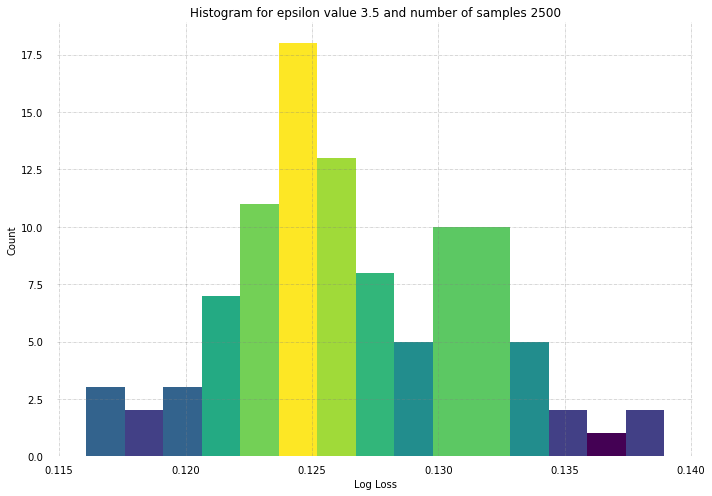

In [152]:
from matplotlib import pyplot as plt
import numpy as np
 
#fig, ax = plt.subplots(figsize =(10, 7))
#ax.hist(loss_final_100,bins = 15,color='red')
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)
 
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
 
# Creating histogram
N, bins, patches = axs.hist(loss_final_100, bins = 15)
 
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
 
# Show plot
plt.xlabel('Log Loss')
plt.ylabel('Count')
plt.title('Histogram for epsilon value 3.5 and number of samples 2500')
plt.show()

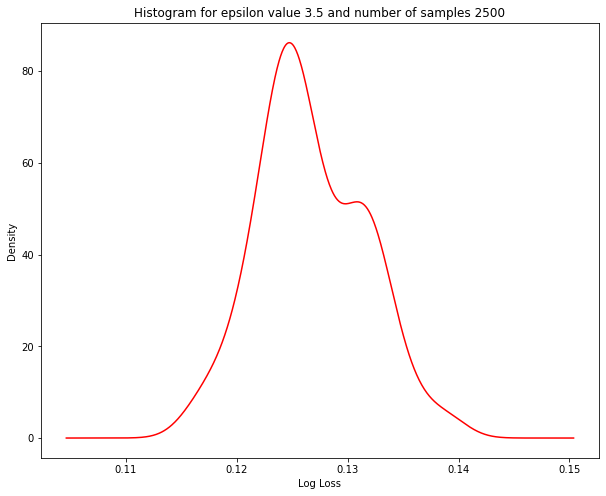

In [150]:
plt.figure(figsize=(10,8))
s = pd.Series(loss_final_100)
ax = s.plot.kde(color='red')
plt.xlabel('Log Loss')
plt.title('Histogram for epsilon value 3.5 and number of samples 2500')
plt.show()

In [151]:
weight_list

[[17014, 16911, 17292, 17277],
 [16133, 16593, 16890, 16622],
 [16356, 16864, 17156, 16395],
 [16388, 16351, 16552, 16995],
 [16762, 16474, 16278, 16216],
 [16840, 16704, 17303, 16502],
 [16923, 16798, 16339, 16480],
 [17380, 15890, 16042, 16973],
 [16563, 16543, 16373, 16231],
 [16539, 15883, 16877, 16695],
 [16263, 17115, 15709, 17054],
 [16463, 16085, 16919, 17309],
 [16282, 15647, 15902, 16544],
 [16837, 17516, 17504, 16996],
 [16131, 16386, 16118, 16328],
 [16346, 16712, 16055, 17087],
 [16334, 17251, 17302, 17199],
 [16426, 16094, 16863, 16483],
 [16297, 16861, 17496, 15961],
 [16922, 16447, 15904, 16631],
 [16388, 16735, 16217, 16895],
 [16601, 16873, 16859, 17040],
 [16951, 15889, 17301, 17096],
 [17427, 16676, 16673, 17075],
 [16939, 16740, 17224, 16271],
 [17174, 16487, 16502, 16780],
 [17075, 16456, 16656, 17108],
 [16700, 16350, 15986, 16940],
 [16265, 16352, 16647, 17253],
 [16633, 16848, 16742, 15898],
 [16325, 16608, 16877, 16498],
 [16416, 16391, 17810, 16472],
 [17059,

In [68]:
loss_final

[[[3, 4.5], nan, 0.5716617865813989, 0.5716617865813989, 1600, [0, 10]],
 [[3, 4.5],
  0.21828836151183928,
  0.5729185939918673,
  0.5374555707438645,
  1600,
  [1, 9]],
 [[3, 4.5],
  0.1982390377813339,
  0.5764202901854228,
  0.500784039704605,
  1600,
  [2, 8]],
 [[3, 4.5],
  0.18068425060085785,
  0.582300989225489,
  0.4618159676380997,
  1600,
  [3, 7]],
 [[3, 4.5],
  0.16203319010359438,
  0.5923738520646871,
  0.42023758728025,
  1600,
  [4, 6]],
 [[3, 4.5],
  0.14327706202249274,
  0.6077890878859669,
  0.3755330749542298,
  1600,
  [5, 5]],
 [[3, 4.5],
  0.12465873301537143,
  0.630780939989296,
  0.32710761580494124,
  1600,
  [6, 4]],
 [[3, 4.5],
  0.105862539163118,
  0.6661518243164104,
  0.2739493247091057,
  1600,
  [7, 3]],
 [[3, 4.5],
  0.08572819606923167,
  0.7277133531186961,
  0.21412522747912452,
  1600,
  [8, 2]],
 [[3, 4.5],
  0.06271501104203528,
  0.8653608234280944,
  0.1429795922806412,
  1600,
  [9, 1]],
 [[3, 4.5], 0.03427716280248951, nan, 0.03427716280

In [69]:
avg_list_loss_adversary1

[nan,
 0.21828836151183928,
 0.1982390377813339,
 0.18068425060085785,
 0.16203319010359438,
 0.14327706202249274,
 0.12465873301537143,
 0.105862539163118,
 0.08572819606923167,
 0.06271501104203528,
 0.03427716280248951]

In [70]:
avg_list_loss_adversary2

[0.5716617865813989,
 0.5729185939918673,
 0.5764202901854228,
 0.582300989225489,
 0.5923738520646871,
 0.6077890878859669,
 0.630780939989296,
 0.6661518243164104,
 0.7277133531186961,
 0.8653608234280944,
 nan]

In [71]:
def function_generator(x,weight_1,weight_2,avg_loss_adversary1,avg_loss_adversary2):
    y=((weight_1*avg_loss_adversary1)+(weight_2*avg_loss_adversary2)-(x*weight_1))/weight_2
    return y

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [73]:
x=np.linspace(-5,5,100)

In [74]:
y=function_generator(x,1,9,0.13092575714018276, 0.6951862895722297)

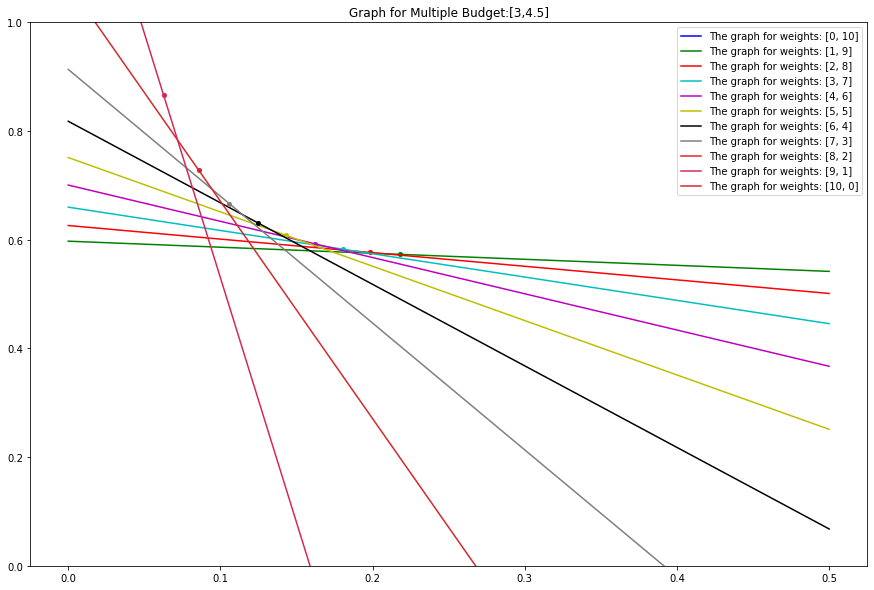

In [81]:
x=np.linspace(0,0.5,100)
weight_1=[0,1,2,3,4,5,6,7,8,9,10]
weight_2=[10,9,8,7,6,5,4,3,2,1,0]
colors=['b','g','r','c','m','y','k','#7f7f7f','#d62728','#d62756','#d62731']
plt.figure(figsize=(15,10))
for i in range(0,len(avg_list_loss_adversary1)):
 y=function_generator(x,weight_1[i],weight_2[i],avg_list_loss_adversary1[i],avg_list_loss_adversary2[i])
 plt.plot(x,y,colors[i],label="The graph for weights: "+str([weight_1[i],weight_2[i]]))
 plt.plot(avg_list_loss_adversary1[i],avg_list_loss_adversary2[i], colors[i], marker='o', markersize=4)
 plt.title("Graph for Multiple Budget:[3,4.5]")
 plt.ylim([0,1])
 plt.legend()



In [76]:
pip install sympy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\dell\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [77]:
from sympy import symbols, Eq, solve

In [78]:
def two_equation_calculator(a,b,c,d,e,f):
    x, y = symbols('x y')
    eq1 = Eq(a*x + b*y + c)
    eq2 = Eq(d*x + e*y + f)
    ans=solve((eq1,eq2), (x, y))
    return [ans[x],ans[y]]

In [79]:
two_equation_calculator(2,8,-5.81,1,9,-6.38)


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  This is separate from the ipykernel package so we can avoid doing imports until


[0.125000000000000, 0.695000000000000]

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
a=[1,0.2071,0.1895,0.1706,0.152,0.1335,0.1143,0.0945,0.0717,0.0342]
b=[0.5716,0.5741,0.5785,0.5866,0.599,0.6175,0.6463,0.6925,0.7837,1]

In [83]:
avg_list_loss_adversary1

[nan,
 0.21828836151183928,
 0.1982390377813339,
 0.18068425060085785,
 0.16203319010359438,
 0.14327706202249274,
 0.12465873301537143,
 0.105862539163118,
 0.08572819606923167,
 0.06271501104203528,
 0.03427716280248951]

In [84]:
avg_list_loss_adversary1[0]=1

In [3]:
avg_list_loss_adversary1=[1,
 0.21828836151183928,
 0.1982390377813339,
 0.18068425060085785,
 0.16203319010359438,
 0.14327706202249274,
 0.12465873301537143,
 0.105862539163118,
 0.08572819606923167,
 0.06271501104203528,
 0.03427716280248951]

In [86]:
avg_list_loss_adversary2[-1]=1

In [4]:
avg_list_loss_adversary2=[0.5716617865813989,
 0.5729185939918673,
 0.5764202901854228,
 0.582300989225489,
 0.5923738520646871,
 0.6077890878859669,
 0.630780939989296,
 0.6661518243164104,
 0.7277133531186961,
 0.8653608234280944,
 1]

In [5]:
#fill between
#function fill



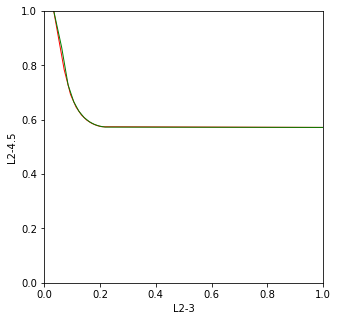

In [7]:
#plt.axhline(0, color='green')
#plt.axvline(0, color='green')
plt.figure(figsize=(5,5))
plt.plot(a, b, '-r', linewidth=1)
plt.plot(avg_list_loss_adversary1,avg_list_loss_adversary2, '-g', linewidth=1)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel('L2-3')
plt.ylabel('L2-4.5')
plt.savefig('L2_Mnist_paper_800_weights.png')

plt.show()

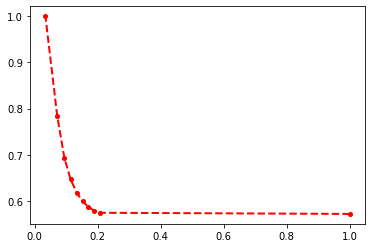

In [92]:
plt.plot(a, b, 'ro--', linewidth=2, markersize=4)

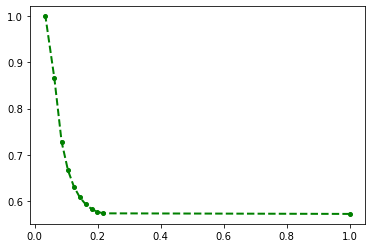

In [93]:
plt.plot(avg_list_loss_adversary1,avg_list_loss_adversary2, 'go--', linewidth=2, markersize=4)